# **Phishing URL detection: pre-processing**

**RQ1:** What characteristics provide the greatest discriminatory information for identifying phishing sites compared to legitimate ones?  

**RQ2:** Do synthetic data generated by Large Language Models preserve the same statistical properties as real data?

**RQ3:** What are the main differences between synthetic data generated by LLMs and real data in regression and clustering contexts?

**RQ4:** Can the features generated by LLMs be mapped to known statistical distributions?

<br>

**Author:** Raffaele Aurucci

## **Reading real dataset**

### 1. Preliminary operation

In [ ]:
download.file("https://drive.google.com/uc?id=1-dc2fGxwjfNjpxGTc71fXXahLH0mTJ_X&export=download", "Phishing_URL_Dataset_3.csv")

In [ ]:
if (!require(moments)) install.packages("moments")

library(moments)
library(utils)

In [ ]:
df <- read.csv('Phishing_URL_Dataset_3.csv', sep = ";")

head(df, 10)

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,⋯,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,617892.txt,https://www.vantien.com,22,www.vantien.com,15,0,com,100.00000,1.0000000,0.5229071,⋯,1,0,1,74,18,6,146,4,162,1
2,mw17539.txt,http://www.kommesantor.com,25,www.kommesantor.com,19,0,com,65.71429,1.0000000,0.5229071,⋯,0,0,0,0,0,1,1,0,1,0
3,770233.txt,https://www.legorreta.eus,24,www.legorreta.eus,17,0,eus,100.00000,1.0000000,0.0001069,⋯,0,0,1,37,44,44,153,3,67,1
4,159416.txt,https://www.volcanolodge.com,27,www.volcanolodge.com,20,0,com,100.00000,1.0000000,0.5229071,⋯,0,0,1,20,11,15,4,3,20,1
5,7970003.txt,https://www.ekel-nat.ekinsrr.lulhbc.top/load.php,47,www.ekel-nat.ekinsrr.lulhbc.top,31,0,top,25.46296,0.3478261,0.0002752,⋯,0,0,0,0,0,0,0,0,0,0
6,7998571.txt,https://confusedimpossiblecommand--mailbogota3245.repl.co/,57,confusedimpossiblecommand--mailbogota3245.repl.co,49,0,co,25.07955,0.6739130,0.0059772,⋯,0,0,0,0,0,0,0,0,2,0
7,228017.txt,https://www.laogai.org,21,www.laogai.org,14,0,org,100.00000,1.0000000,0.0799628,⋯,0,0,0,13,40,24,20,0,24,1
8,7971342.txt,https://f-e-t-0utlook-shar3point.web.app/,40,f-e-t-0utlook-shar3point.web.app,32,0,app,34.48745,0.2857143,0.0015020,⋯,0,0,0,0,0,1,0,0,0,0
9,7850082.txt,https://mercado.pago.email/,26,mercado.pago.email,18,0,email,63.35283,0.6666667,0.0000338,⋯,0,0,0,0,2,0,2,0,1,0


In [ ]:
str(df)

'data.frame':	23580 obs. of  56 variables:
 $ FILENAME                  : chr  "617892.txt" "mw17539.txt" "770233.txt" "159416.txt" ...
 $ URL                       : chr  "https://www.vantien.com" "http://www.kommesantor.com" "https://www.legorreta.eus" "https://www.volcanolodge.com" ...
 $ URLLength                 : int  22 25 24 27 47 57 21 40 26 21 ...
 $ Domain                    : chr  "www.vantien.com" "www.kommesantor.com" "www.legorreta.eus" "www.volcanolodge.com" ...
 $ DomainLength              : int  15 19 17 20 31 49 14 32 18 14 ...
 $ IsDomainIP                : int  0 0 0 0 0 0 0 0 0 0 ...
 $ TLD                       : chr  "com" "com" "eus" "com" ...
 $ URLSimilarityIndex        : num  100 65.7 100 100 25.5 ...
 $ CharContinuationRate      : num  1 1 1 1 0.348 ...
 $ TLDLegitimateProb         : num  0.522907 0.522907 0.000107 0.522907 0.000275 ...
 $ URLCharProb               : num  0.0656 0.0708 0.0668 0.0671 0.0539 ...
 $ TLDLength                 : int  3 3 3 3 3 2

In [ ]:
# count NA values
labels = names(df)

for (label in labels) {
  na_count <- sum(is.na(df[[label]]))
  if (na_count > 0)
    print(paste(label, ":", na_count))
}

# delete duplicated observations
df <- df[!duplicated(df), ]

# reset indices
row.names(df) <- NULL

# disable scientific notation view
options(scipen = 999)


# moda function
moda <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}


# count outliers function
count_outliers <- function(df, column) {

  q1 <- quantile(df[[column]], 0.25)
  q3 <- quantile(df[[column]], 0.75)

  iqr <- q3 - q1

  lower_bound <- q1 - 1.5 * iqr
  upper_bound <- q3 + 1.5 * iqr

  outliers <- sum(df[[column]] < lower_bound | df[[column]] > upper_bound)

  return(outliers)
}


# calculate overlap median function
calculate_overlap_median <- function(df_0, df_1, column) {

  # class 0
  IQR_0 <- quantile(df_0[[column]], 0.75) - quantile(df_0[[column]], 0.25)
  M1_0 <- quantile(df_0[[column]], 0.5) - 1.57 * IQR_0 / sqrt(length(df_0[[column]]))
  M2_0 <- quantile(df_0[[column]], 0.5) + 1.57 * IQR_0 / sqrt(length(df_0[[column]]))

  # class 1
  IQR_1 <- quantile(df_1[[column]], 0.75) - quantile(df_1[[column]], 0.25)
  M1_1 <- quantile(df_1[[column]], 0.5) - 1.57 * IQR_1 / sqrt(length(df_1[[column]]))
  M2_1 <- quantile(df_1[[column]], 0.5) + 1.57 * IQR_1 / sqrt(length(df_1[[column]]))

  return(list(
    "df_0" = list("M1" = M1_0, "M2" = M2_0),
    "df_1" = list("M1" = M1_1, "M2" = M2_1)
  ))
}

### 2. Feature **label**

*   0 indicate **phishing** URL
*   1 indicate **legitimate** URL

In [ ]:
table(df$label)


    0     1 
10078 13502 

In [ ]:
# undersampling to balance dataset
indices_label_1 <- which(df$label == 1)
indices_to_remove <- sample(indices_label_1, 3424) # 3424
df <- df[-indices_to_remove, ]
row.names(df) <- NULL

# divide dataset
df_0 <- df[df$label == 0, ]
df_1 <- df[df$label == 1, ]

table(df$label)


    0     1 
10078 10078 

## **Deleting non-discriminative features.**

### 3. Features **FILENAME**, **Url**, **Domain**  

Delete this features because have only unique values

In [ ]:
# FILENAME
df <- subset(df, select = -FILENAME)

# URL (as identifier)
df <- df[!duplicated(df$URL), ]
df <- subset(df, select = -URL)

# Domain
df <- subset(df, select = -Domain)

### 4. Feature **TLD**

#### Joint Relative Frequency

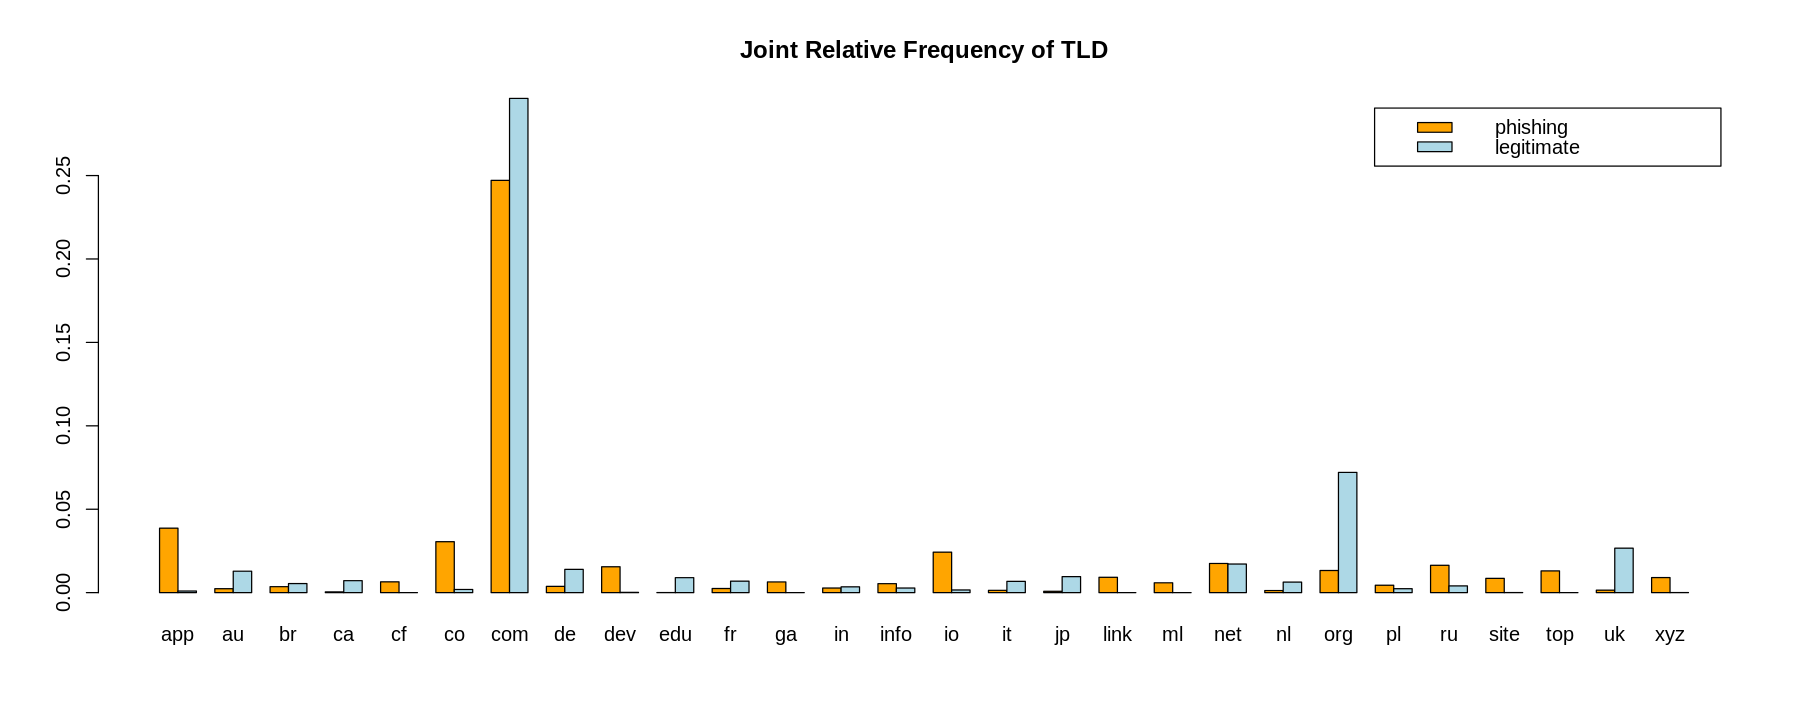

In [ ]:
# most frequent TLD category
tld_table <- table(df$TLD)
tld_df <- as.data.frame(tld_table)
tld_filtered <- tld_df[tld_df$Freq >= 100, ]

# the most frequent is 'com'
tld_max = moda(df$TLD)

filtered_df <- df[df$TLD %in% tld_filtered$Var1, ]
tld_freq <- prop.table(table(filtered_df$label, filtered_df$TLD))
# tld_freq

# barplot dimension
options(repr.plot.width = 15, repr.plot.height = 6)

barplot(tld_freq, col = c('orange', 'lightblue'), beside = TRUE,
        main = 'Joint Relative Frequency of TLD',
        legend = c('phishing', 'legitimate'))

#### Target Encoding

Transform this feature into the probability of a legitimate TLD within the dataset, formally:

$$
\text{TLDEncoding}_i = \frac{\sum_{j \in TLD} \text{label}_j}{n_{TLD}}
$$



In [ ]:
# encoding
tld_encoding <- aggregate(label ~ TLD, data = df, FUN = mean)
colnames(tld_encoding)[2] <- "TLDEncoding"
df <- merge(df, tld_encoding, by = "TLD", all.x = TRUE)

# remove TLD
df <- df[, -which(names(df) == "TLD")]
df <- df[, c(1, 2, ncol(df), 3:(ncol(df) - 1))]

# update df_0, df_1
df_0 <- df[df$label == 0, ]
df_1 <- df[df$label == 1, ]

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$TLDEncoding)

cat('\nvar: ', var(df$TLDEncoding), '\n')
cat('std: ', sd(df$TLDEncoding))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.4694  0.5452  0.5001  0.5452  1.0000 


var:  0.07883241 
std:  0.2807711

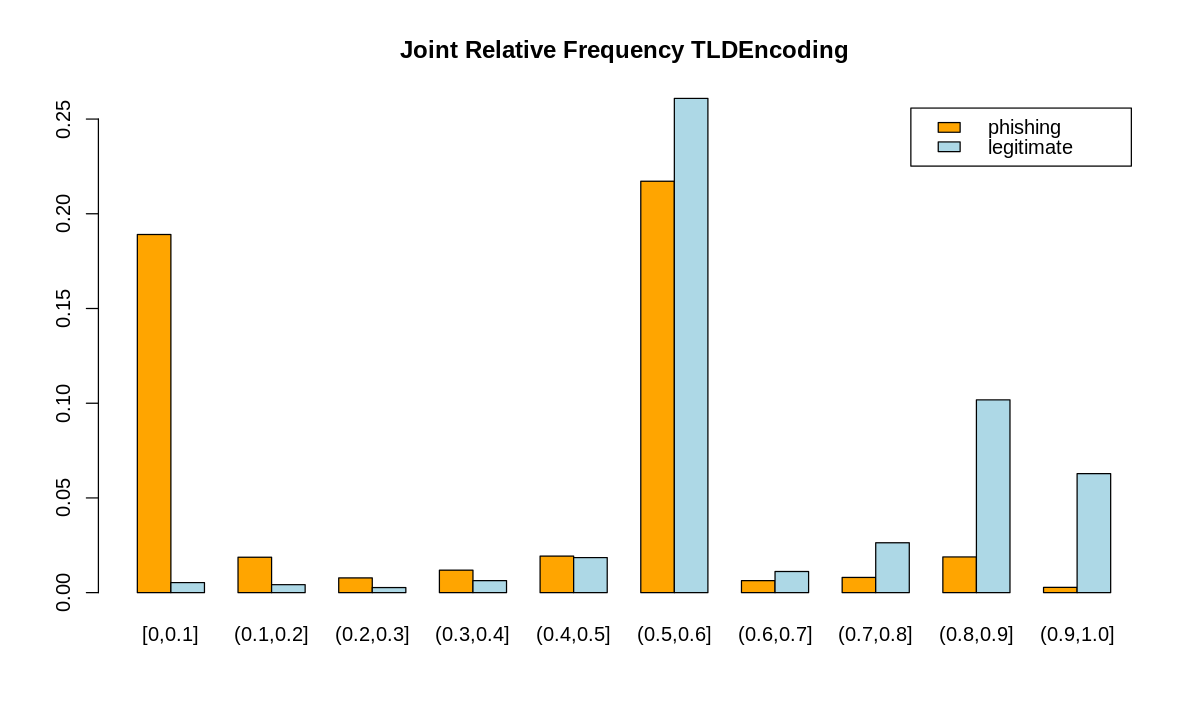

In [ ]:
# distribution
breaks <- c(-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

labels <- c("[0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
            "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]")

j_freq <- table(df$label, cut(df$TLDEncoding, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        legend = c("phishing", "legitimate"),
        main = "Joint Relative Frequency TLDEncoding", beside=TRUE)

#### Outliers and overlap median

In [ ]:
summary(df_0$TLDEncoding)
summary(df_1$TLDEncoding)

outliers <- count_outliers(df, "TLDEncoding")
outliers_0 <- count_outliers(df_0, "TLDEncoding")
outliers_1 <- count_outliers(df_1, "TLDEncoding")

cat('\nn. outliers TLDEncoding: \t', outliers)
cat('\nn. outliers TLDEncoding (0): \t', outliers_0)
cat('\nn. outliers TLDEncoding (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02485 0.54521 0.34239 0.54521 0.99359 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.006369 0.545212 0.545212 0.657708 0.844535 1.000000 


n. outliers TLDEncoding: 	 9497
n. outliers TLDEncoding (0): 	 0
n. outliers TLDEncoding (1): 	 98

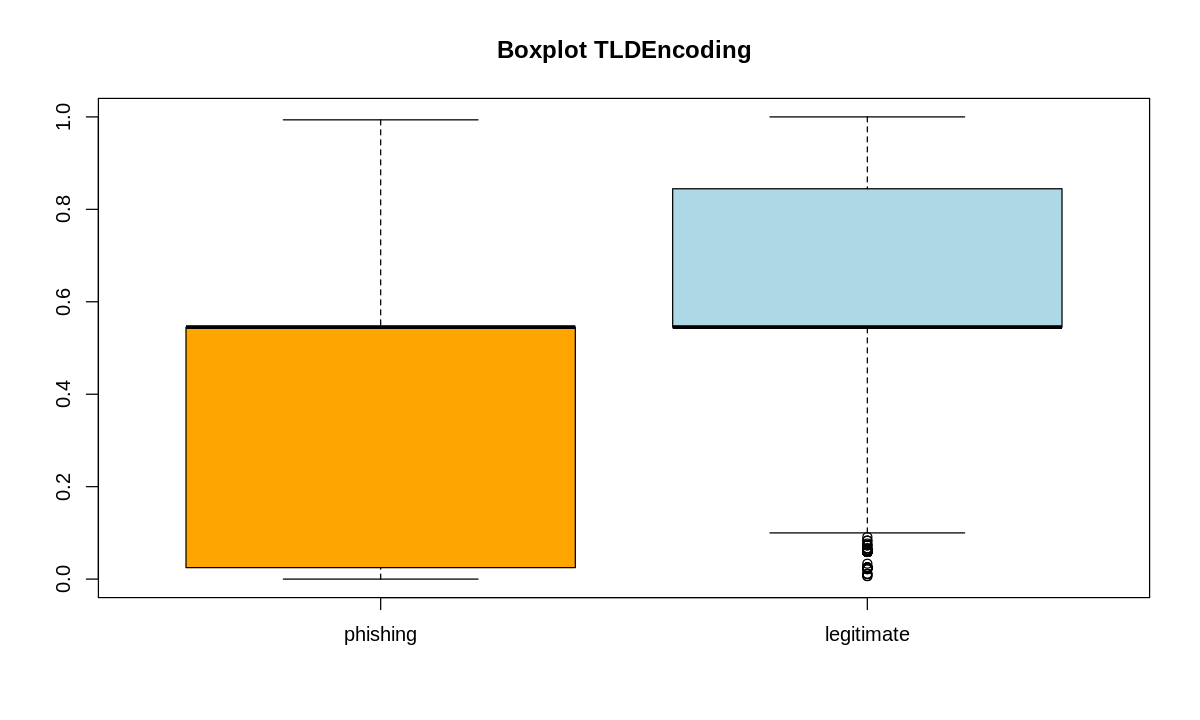

In [ ]:
boxplot(df_0$TLDEncoding, df_1$TLDEncoding,
        main = 'Boxplot TLDEncoding', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "TLDEncoding")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 0.537073 M2 = 0.5533514 
Overlap df_1: M1 = 0.5405311 M2 = 0.5498933 


#### Distribution form

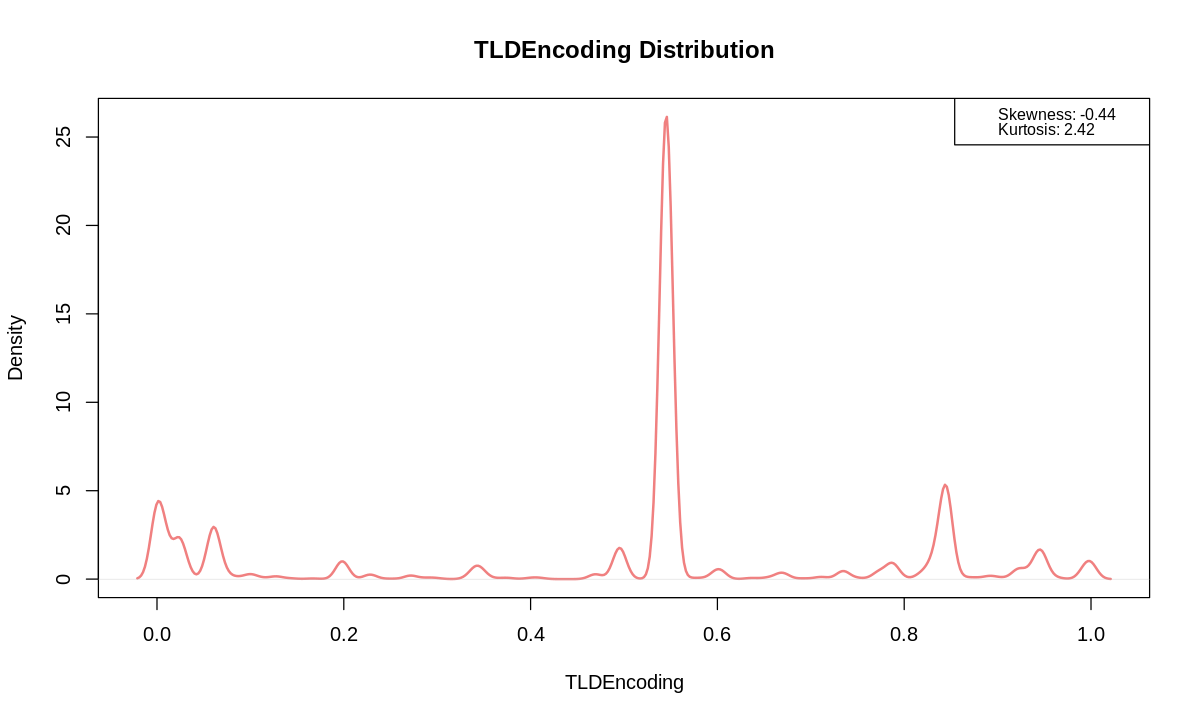

In [ ]:
skw_value <- skewness(df$TLDEncoding)
kurtosis_value <- kurtosis(df$TLDEncoding)

density <- density(df$TLDEncoding)

plot(density, main = "TLDEncoding Distribution",
     col = "lightcoral", lwd = 2, xlab = 'TLDEncoding')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
       bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

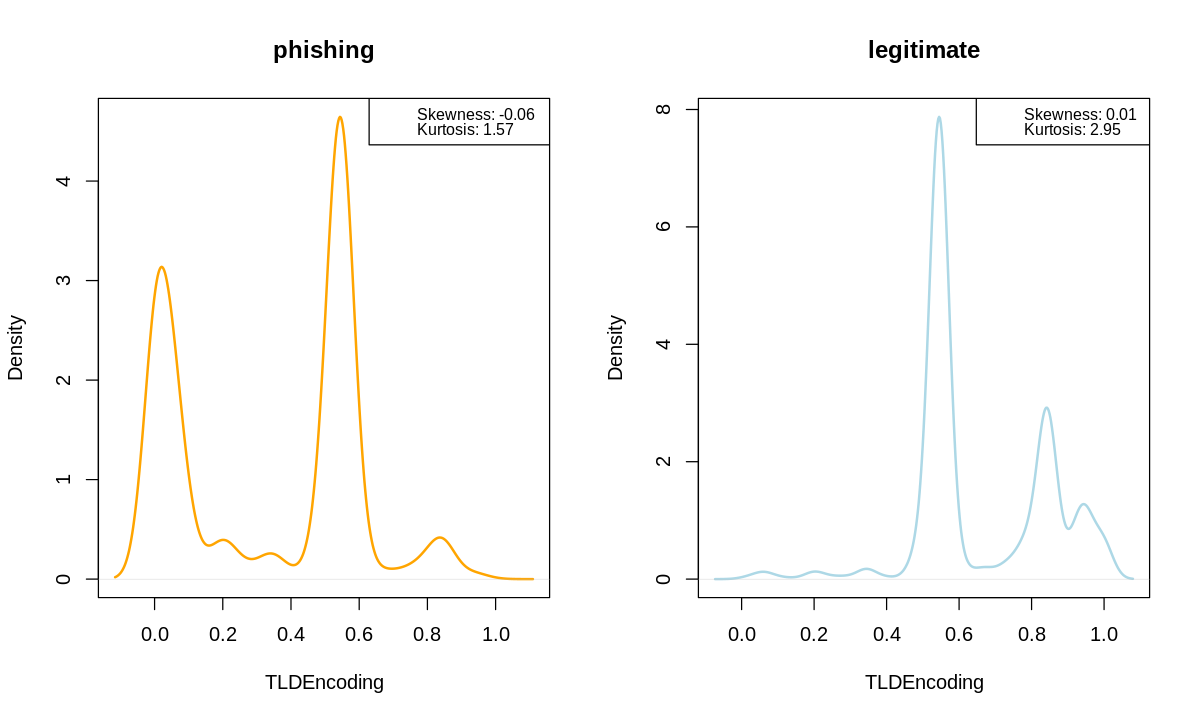

In [ ]:
skw_value_0 <- skewness(df_0$TLDEncoding)
kurtosis_value_0 <- kurtosis(df_0$TLDEncoding)

skw_value_1 <- skewness(df_1$TLDEncoding)
kurtosis_value_1 <- kurtosis(df_1$TLDEncoding)

density_0 <- density(df_0$TLDEncoding)
density_1 <- density(df_1$TLDEncoding)

# plot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "TLDEncoding", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
                  bty = "o", cex = 0.8, inset = c(-0.20, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "TLDEncoding", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       bty = "o", cex = 0.8, inset = c(-0.18, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$TLDEncoding, df$label)
spearman <- cor(df$TLDEncoding, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5615283
Spearman: 	 0.5445397

### 5. Fature **URLLength**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$URLLength)

cat('\nvar: ', var(df$URLLength), '\n')
cat('std: ', sd(df$URLLength))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14.00   24.00   28.00   36.52   36.00  945.00 


var:  1157.035 
std:  34.01521

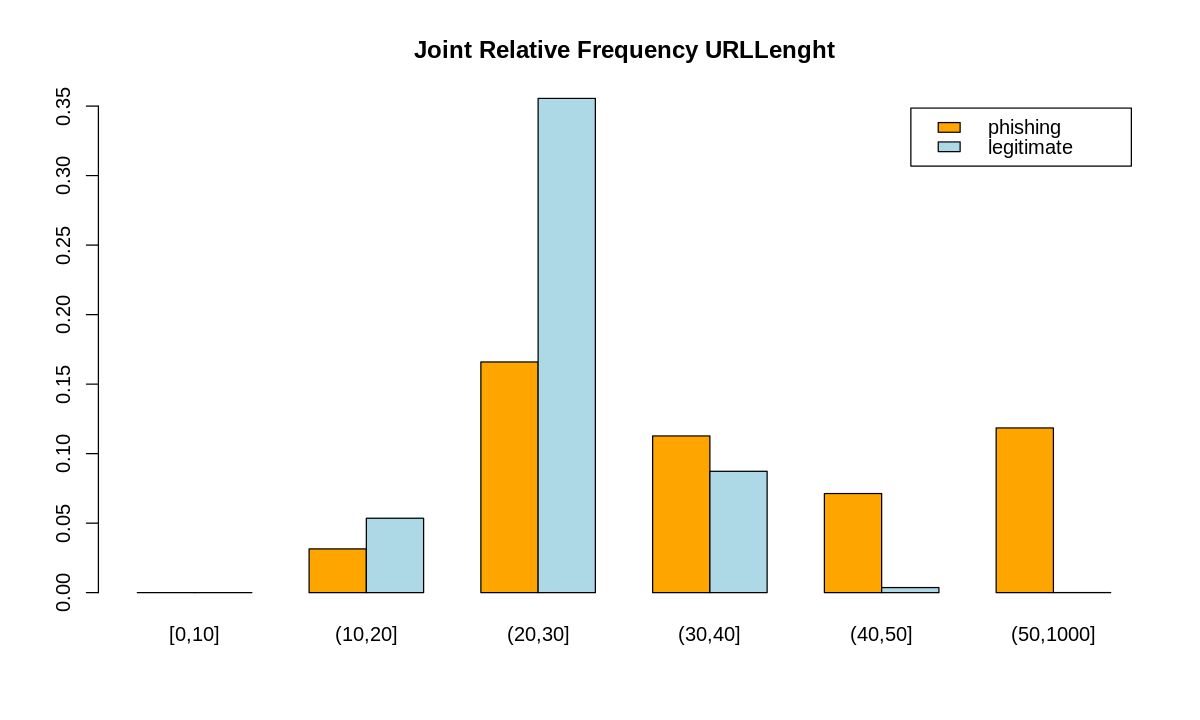

In [ ]:
breaks <- c(0, 10, 20, 30, 40, 50, 1000)

labels <- c("[0,10]", "(10,20]", "(20,30]", "(30,40]", "(40,50]", "(50,1000]")

j_freq <- table(df$label, cut(df$URLLength, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# plot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        legend = c("phishing", "legitimate"),
        main = "Joint Relative Frequency URLLenght", beside=TRUE)

#### Outliers and overlap median

In [ ]:
summary(df_0$URLLength)
summary(df_1$URLLength)

outliers <- count_outliers(df, "URLLength")
outliers_0 <- count_outliers(df_0, "URLLength")
outliers_1 <- count_outliers(df_1, "URLLength")

cat('\nn. outliers URLLength: \t \t', outliers)
cat('\nn. outliers URLLength (0): \t', outliers_0)
cat('\nn. outliers URLLength (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14.00   26.00   35.00   46.78   49.00  945.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  16.00   23.00   26.00   26.27   29.00   51.00 


n. outliers URLLength: 	 	 2066
n. outliers URLLength (0): 	 944
n. outliers URLLength (1): 	 148

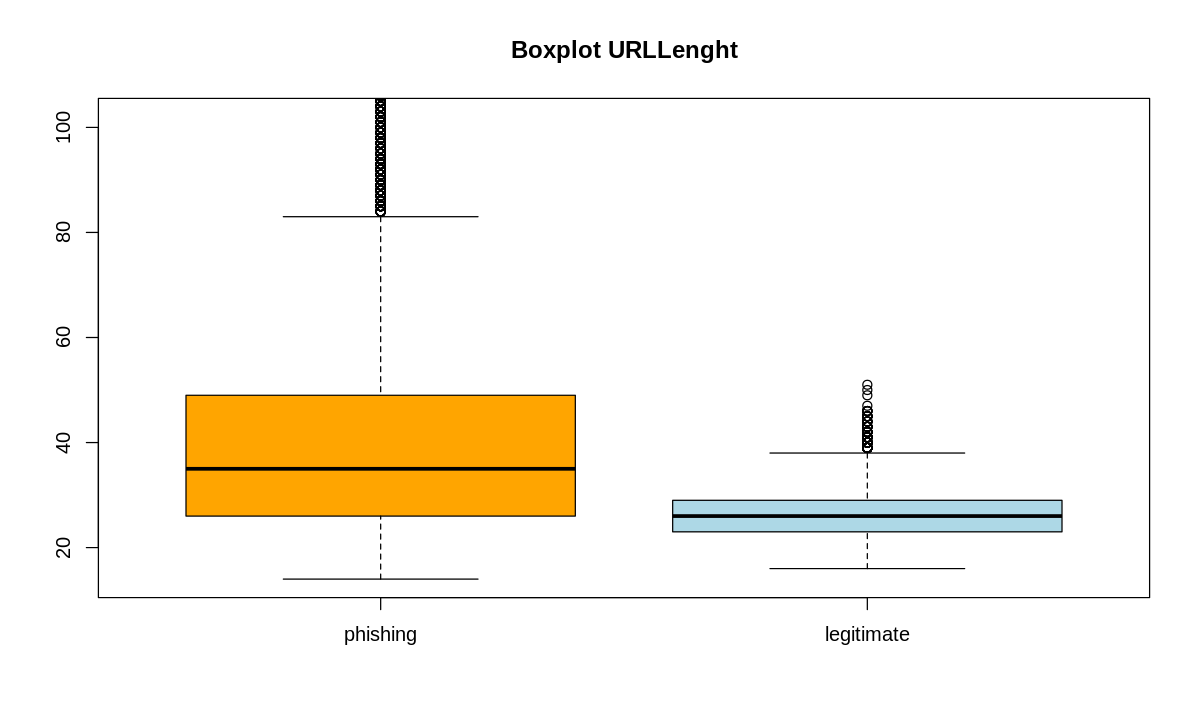

In [ ]:
boxplot(df_0$URLLength, df_1$URLLength,
        ylim = c(min(df_0$URLLength), quantile(df_0$URLLength, 0.95)),
        main = 'Boxplot URLLenght', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "URLLength")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 34.64025 M2 = 35.35975 
Overlap df_1: M1 = 25.90617 M2 = 26.09383 


#### Distribution form

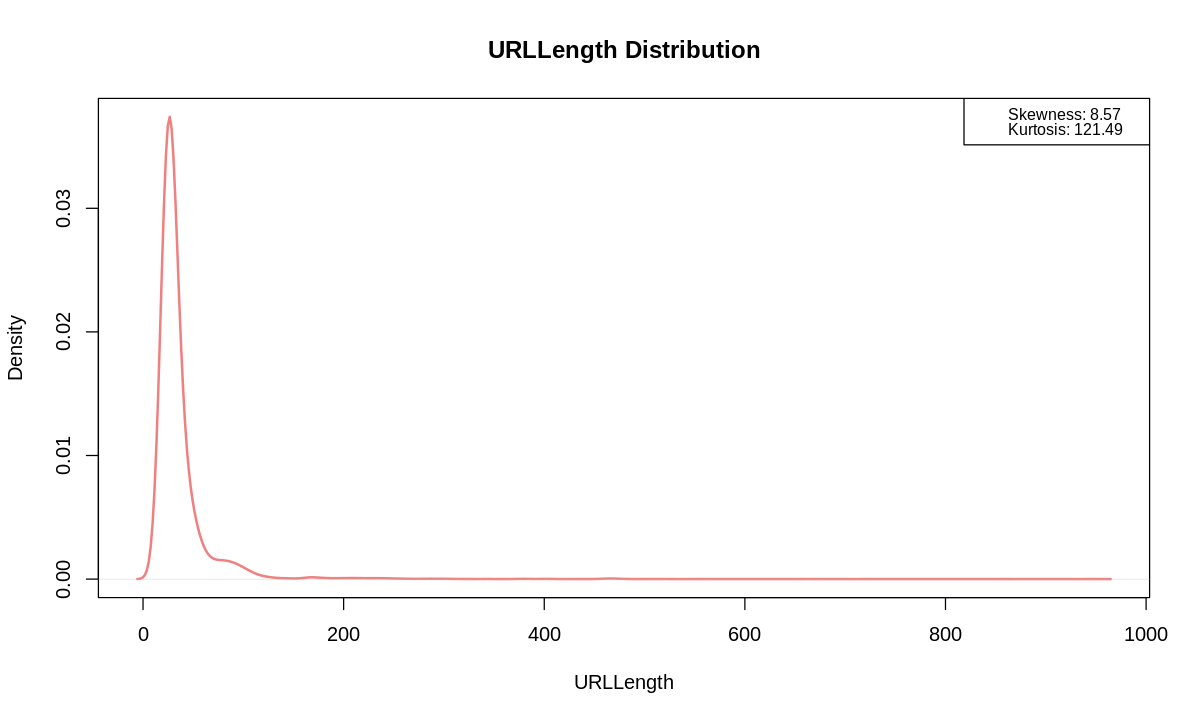

In [ ]:
skw_value <- skewness(df$URLLength)
kurtosis_value <- kurtosis(df$URLLength)

n <- length(df$URLLength)
h_sturges <- (max(df$URLLength) - min(df$URLLength)) / sqrt(n)
density_sturges <- density(df$URLLength, bw = h_sturges)

plot(density_sturges, main = "URLLength Distribution",
     col = "lightcoral", lwd = 2, xlab = 'URLLength')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
       bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

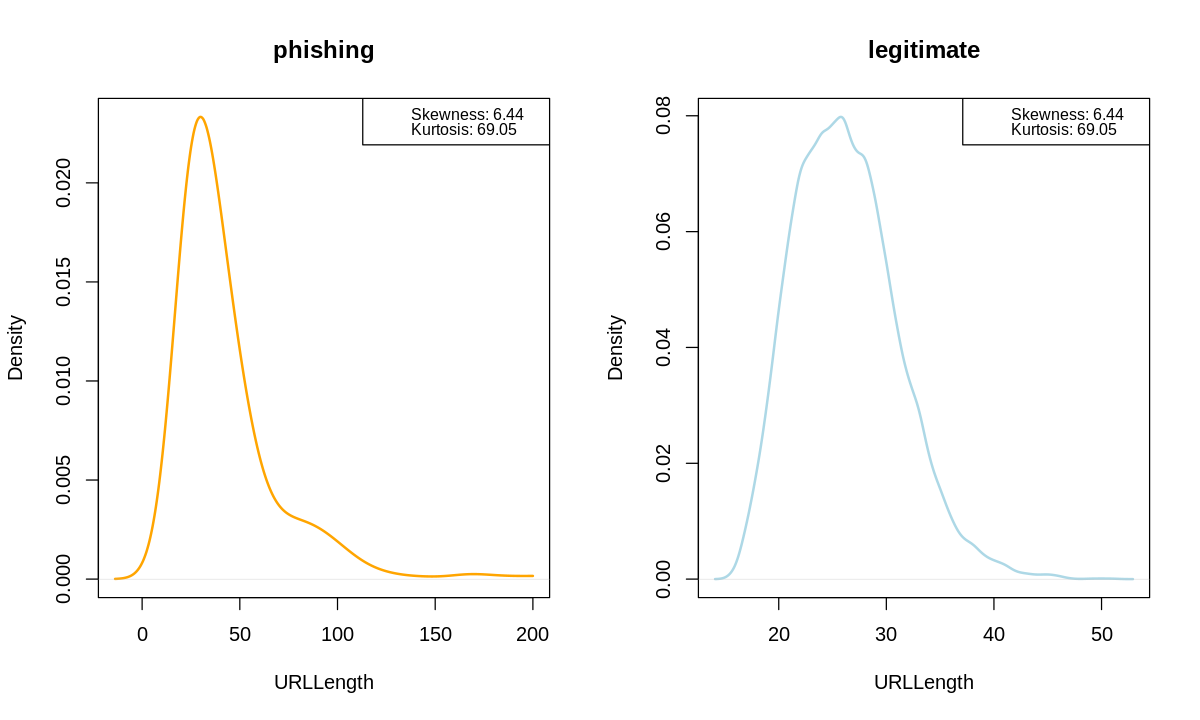

In [ ]:
skw_value_0 <- skewness(df_0$URLLength)
kurtosis_value_0 <- kurtosis(df_0$URLLength)

skw_value_1 <- skewness(df_1$URLLength)
kurtosis_value_1 <- kurtosis(df_1$URLLength)

n_0 <- length(df_0$URLLength)
h_sturges_0 <- (max(df_0$URLLength) - min(df_0$URLLength)) / sqrt(n_0)
density_sturges_0 <- density(df_0$URLLength, bw = h_sturges_0, to=200)

density_1 <- density(df_1$URLLength)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_sturges_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "URLLength", ylab = "Density",
     ylim = c(0, max(density_sturges_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
                  bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "URLLength", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
                  bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$URLLength, df$label)
spearman <- cor(df$URLLength, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.3015611
Spearman: 	 -0.428989

### 6. Feature **DomainLength**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$DomainLength)

cat('\nvar: ', var(df$DomainLength), '\n')
cat('std: ', sd(df$DomainLength))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      4      16      20      22      25      93 


var:  97.28795 
std:  9.863465

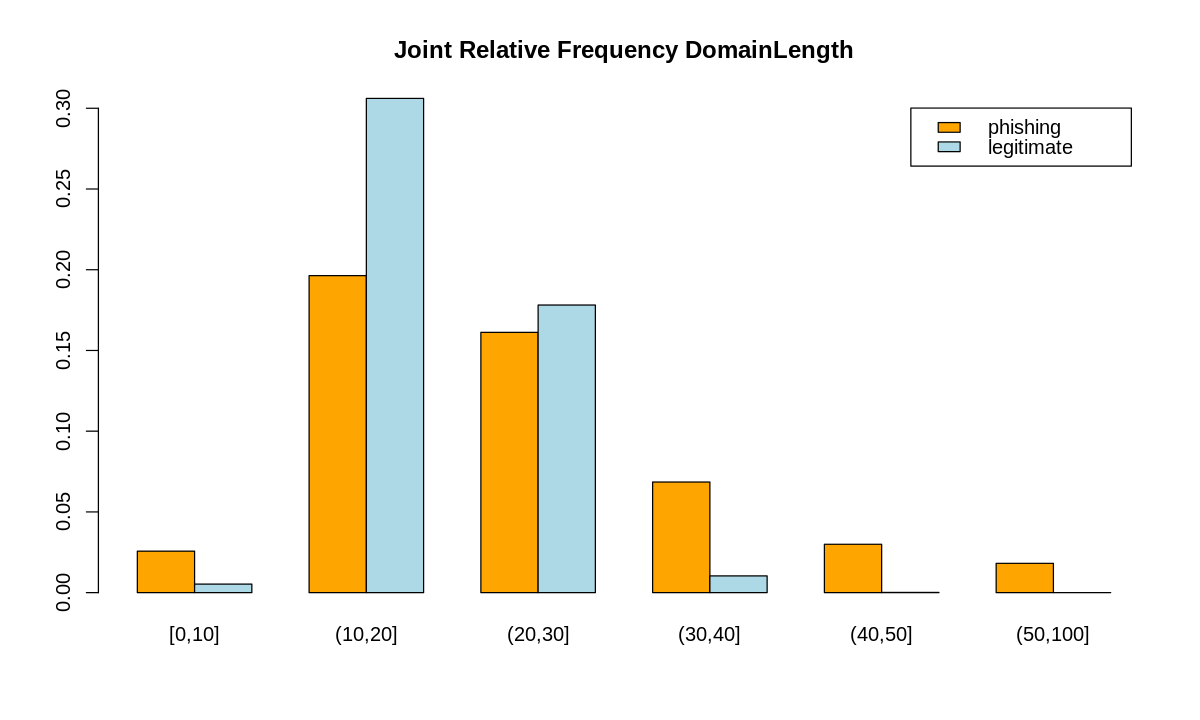

In [ ]:
breaks <- c(0, 10, 20, 30, 40, 50, 100)

labels <- c("[0,10]", "(10,20]", "(20,30]", "(30,40]", "(40,50]", "(50,100]")

j_freq <- table(df$label, cut(df$DomainLength, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

barplot(j_freq_rel, col = c("orange", "lightblue"),
        legend = c("phishing", "legitimate"),
        main = "Joint Relative Frequency DomainLength", beside=TRUE)

#### Outliers and overlap median

In [ ]:
summary(df_0$DomainLength)
summary(df_1$DomainLength)

outliers <- count_outliers(df, "DomainLength")
outliers_0 <- count_outliers(df_0, "DomainLength")
outliers_1 <- count_outliers(df_1, "DomainLength")

cat('\nn. outliers DomainLength: \t', outliers)
cat('\nn. outliers DomainLength (0): \t', outliers_0)
cat('\nn. outliers DomainLength (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4.00   17.00   22.00   24.74   30.00   93.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9.00   16.00   19.00   19.27   22.00   44.00 


n. outliers DomainLength: 	 1166
n. outliers DomainLength (0): 	 378
n. outliers DomainLength (1): 	 148

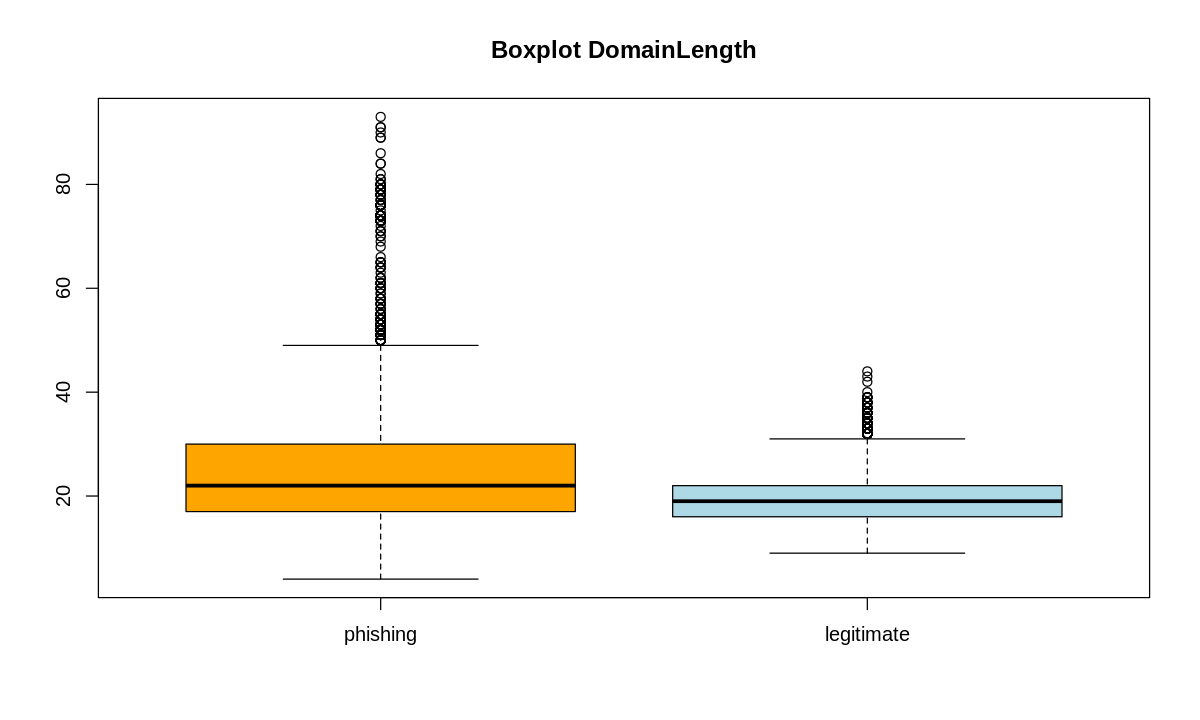

In [ ]:
boxplot(df_0$DomainLength, df_1$DomainLength,
        main = 'Boxplot DomainLength', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "DomainLength")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 21.79666 M2 = 22.20334 
Overlap df_1: M1 = 18.90617 M2 = 19.09383 


#### Distribution Form

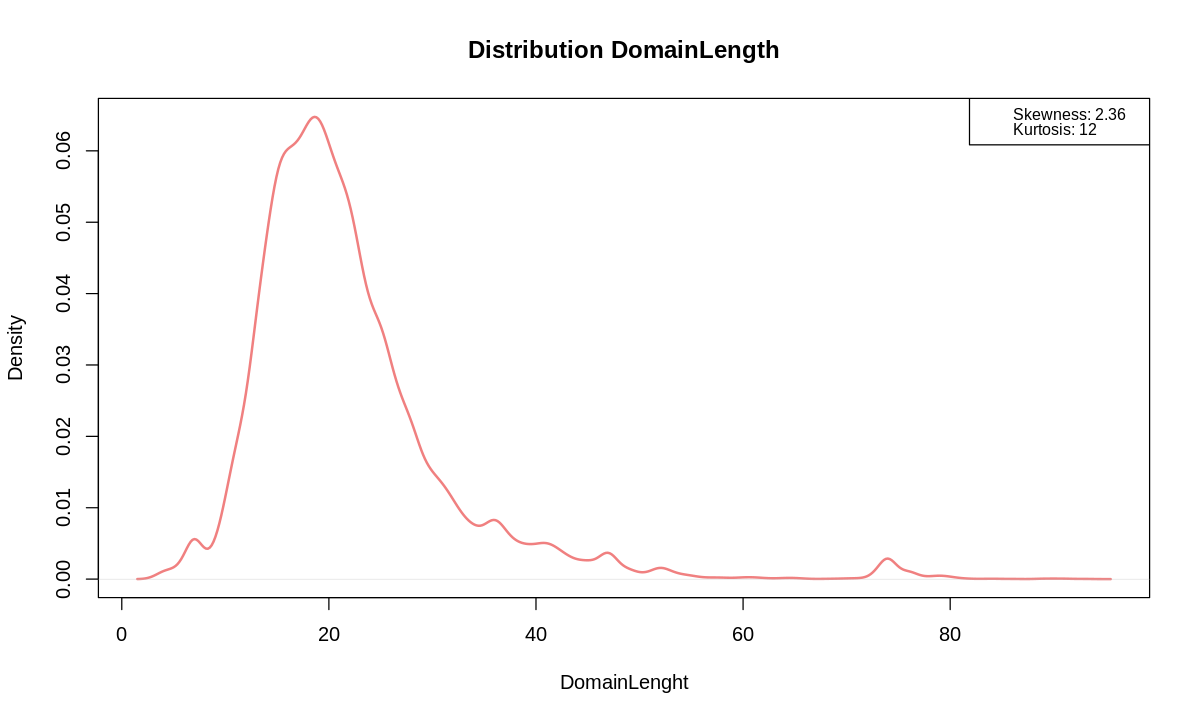

In [ ]:
skw_value <- skewness(df$DomainLength)
kurtosis_value <- kurtosis(df$DomainLength)

density <- density(df$DomainLength)

plot(density, main = "Distribution DomainLength",
     col = "lightcoral", lwd = 2, xlab = 'DomainLenght')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

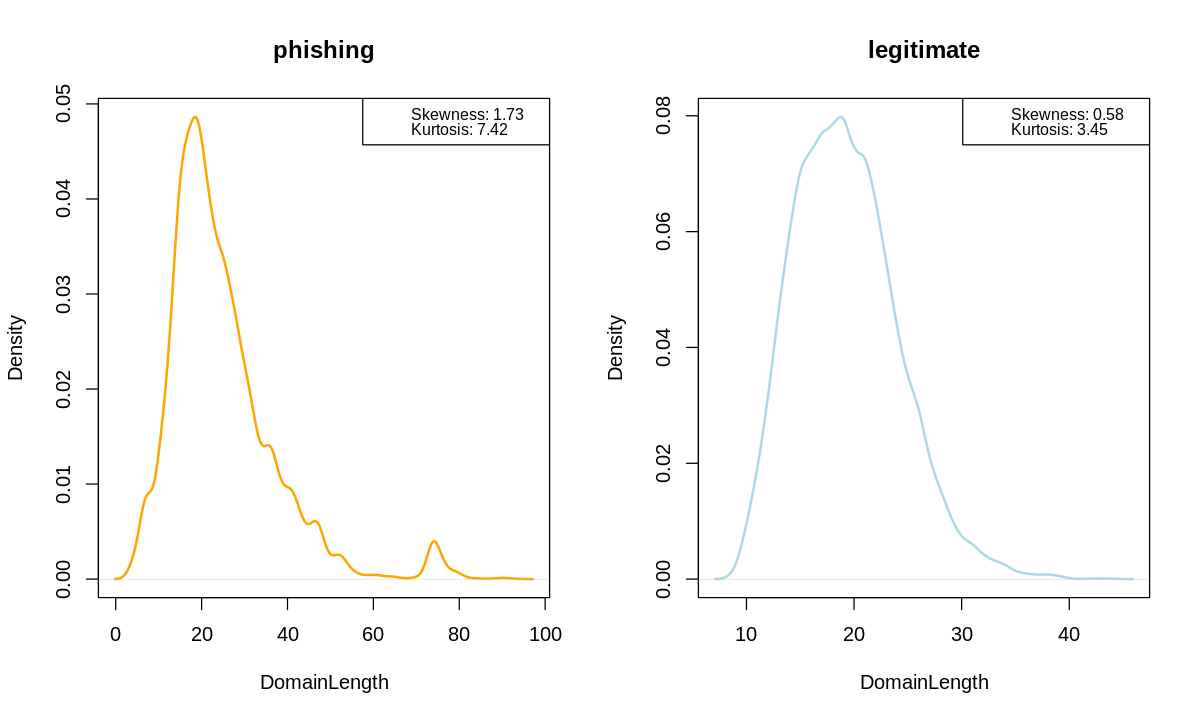

In [ ]:
skw_value_0 <- skewness(df_0$DomainLength)
kurtosis_value_0 <- kurtosis(df_0$DomainLength)

skw_value_1 <- skewness(df_1$DomainLength)
kurtosis_value_1 <- kurtosis(df_1$DomainLength)

density_0 <- density(df_0$DomainLength)
density_1 <- density(df_1$DomainLength)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "DomainLength", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "DomainLength", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$DomainLength, df$label)
spearman <- cor(df$DomainLength, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.2773157
Spearman: 	 -0.2248308

### 7. Feature **IsDomainIP**

Delete this feature because has:
* only 81 values setting to 1
* lower variance tending to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$IsDomainIP)

cat('\nvar: ', var(df$IsDomainIP), '\n')
cat('std: ', sd(df$IsDomainIP))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.004019 0.000000 1.000000 


var:  0.004003297 
std:  0.06327161

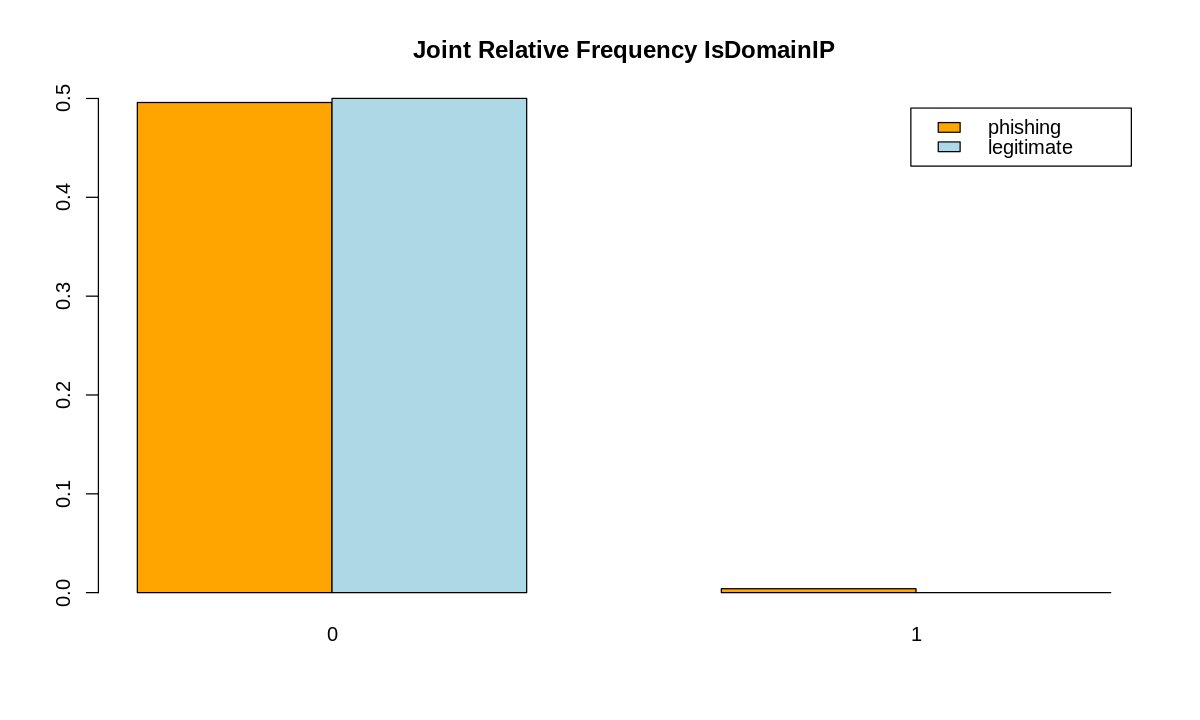

In [ ]:
j_freq <- table(df$label, df$IsDomainIP)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

barplot(j_freq_rel, beside=TRUE, col = c("orange", "lightblue"),
        legend = c("phishing", "legitimate"),
        main = "Joint Relative Frequency IsDomainIP")

#### Correlation with label

In [ ]:
pearson <- cor(df$IsDomainIP, df$label)
spearman <- cor(df$IsDomainIP, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.06353482
Spearman: 	 -0.06353482

In [ ]:
df <- subset(df, select = -IsDomainIP)

### 8. Feature **URLSimilarityIndex**

Delete this feature because:

*   It's an heuristic calculated by authors of dataset
*   It depends to a repository of Legitimate URLs (dataset specific)
*   50% of data is setting to 100 (the legitimate URLs are into previous repository)

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$URLSimilarityIndex)

cat('\nvar: ', var(df$URLSimilarityIndex), '\n')
cat('std: ', sd(df$URLSimilarityIndex))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.9925  49.8056 100.0000  74.2068 100.0000 100.0000 


var:  921.0133 
std:  30.3482

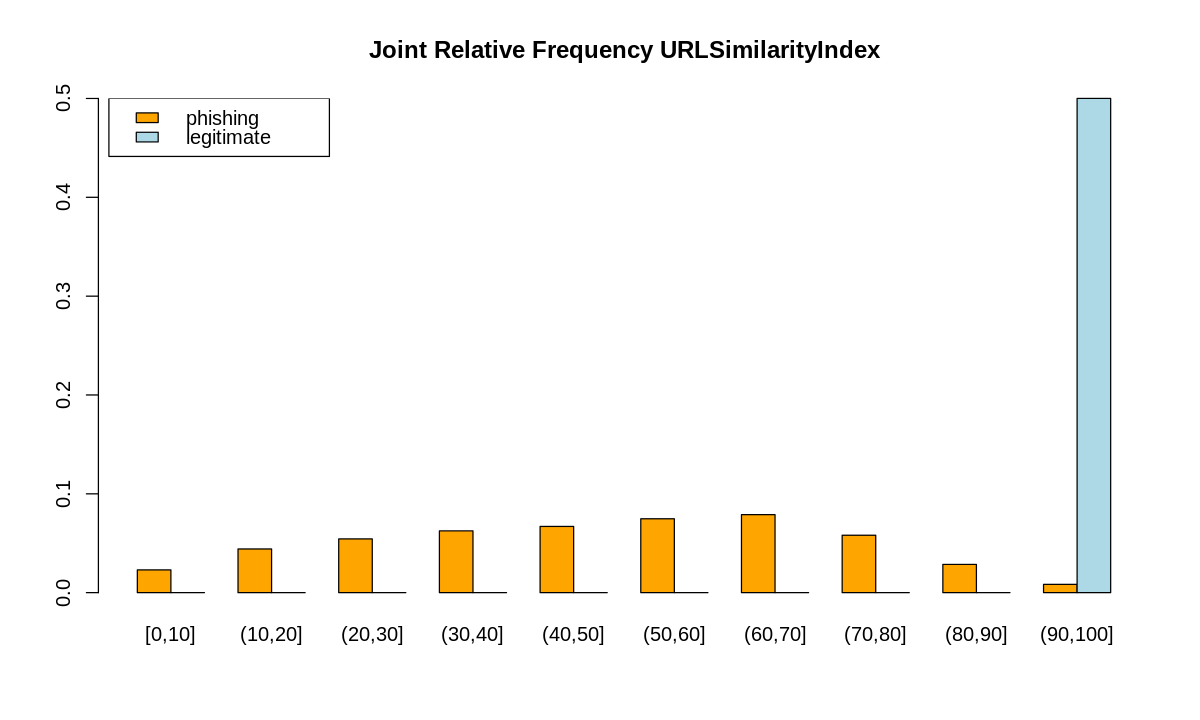

In [ ]:
breaks <- c(-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

labels <- c("[0,10]", "(10,20]", "(20,30]", "(30,40]", "(40,50]", "(50,60]",
            "(60,70]", "(70,80]", "(80,90]", "(90,100]")

j_freq <- table(df$label, cut(df$URLSimilarityIndex, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency URLSimilarityIndex", beside = TRUE)

legend("topleft", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o", inset = c(0.01, 0))

#### Correlation with label

In [ ]:
pearson <- cor(df$URLSimilarityIndex, df$label)
spearman <- cor(df$URLSimilarityIndex, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.8500576
Spearman: 	 0.9216642

In [ ]:
df <- subset(df, select = -URLSimilarityIndex)

### 9. Feature **CharContinuationRate**

Delete this feature because:
*   It's an heuristic not detailed calculated by authors of dataset
*   It depends to a repository of Phishing/Legitimate URL (dataset specific)

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$CharContinuationRate)

cat('\nvar: ', var(df$CharContinuationRate), '\n')
cat('std: ', sd(df$CharContinuationRate))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1429  0.6471  1.0000  0.8253  1.0000  1.0000 


var:  0.0510435 
std:  0.2259281

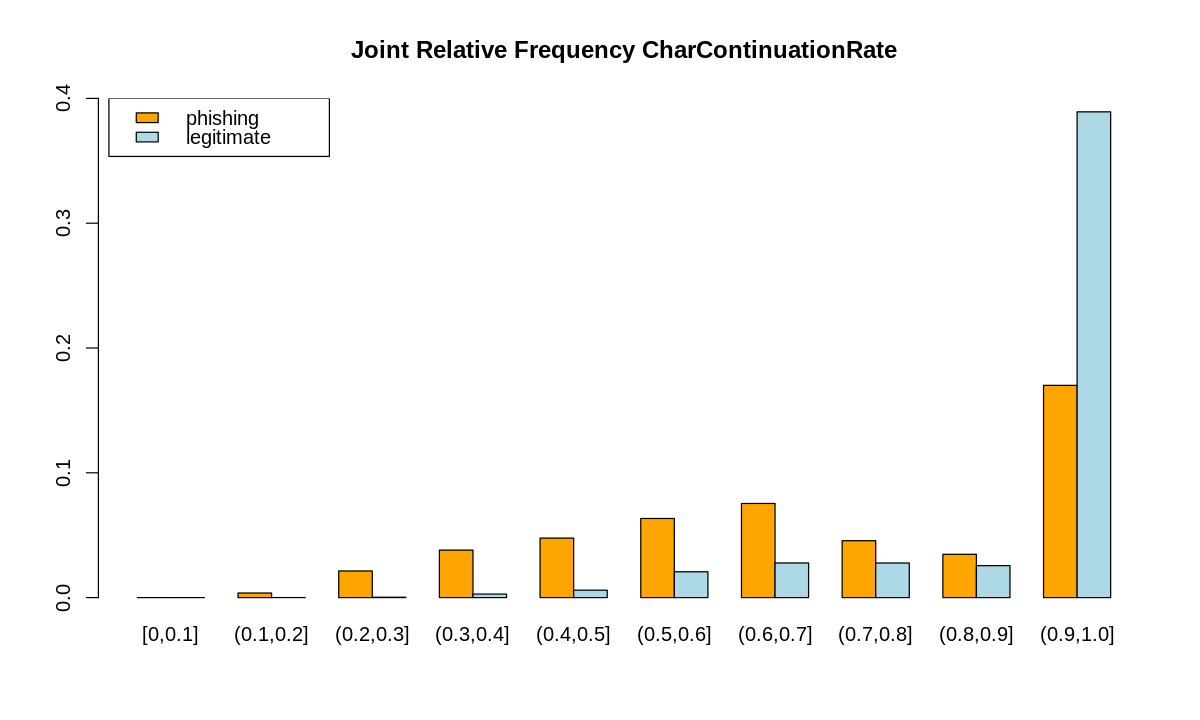

In [ ]:
# distribution
breaks <- c(-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

labels <- c("[0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
            "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]")

j_freq <- table(df$label, cut(df$CharContinuationRate, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency CharContinuationRate", beside=TRUE,
        ylim = c(0, 0.4))

legend("topleft", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o", inset = c(0.01, 0))

#### Correlation with label

In [ ]:
pearson <- cor(df$CharContinuationRate, df$label)
spearman <- cor(df$CharContinuationRate, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.46861
Spearman: 	 0.4770657

In [ ]:
df <- subset(df, select = -CharContinuationRate)

### 10. Feature **TLDLegitimateProb**

Delete this feature because:
*   It's an heuristic calculated by authors of dataset
*   It depends to a repository of Phishing/Legitimate URL (dataset specific)

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$TLDLegitimateProb)

cat('\nvar: ', var(df$TLDLegitimateProb), '\n')
cat('std: ', sd(df$TLDLegitimateProb))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.005977 0.079963 0.253541 0.522907 0.522907 


var:  0.06352939 
std:  0.2520504

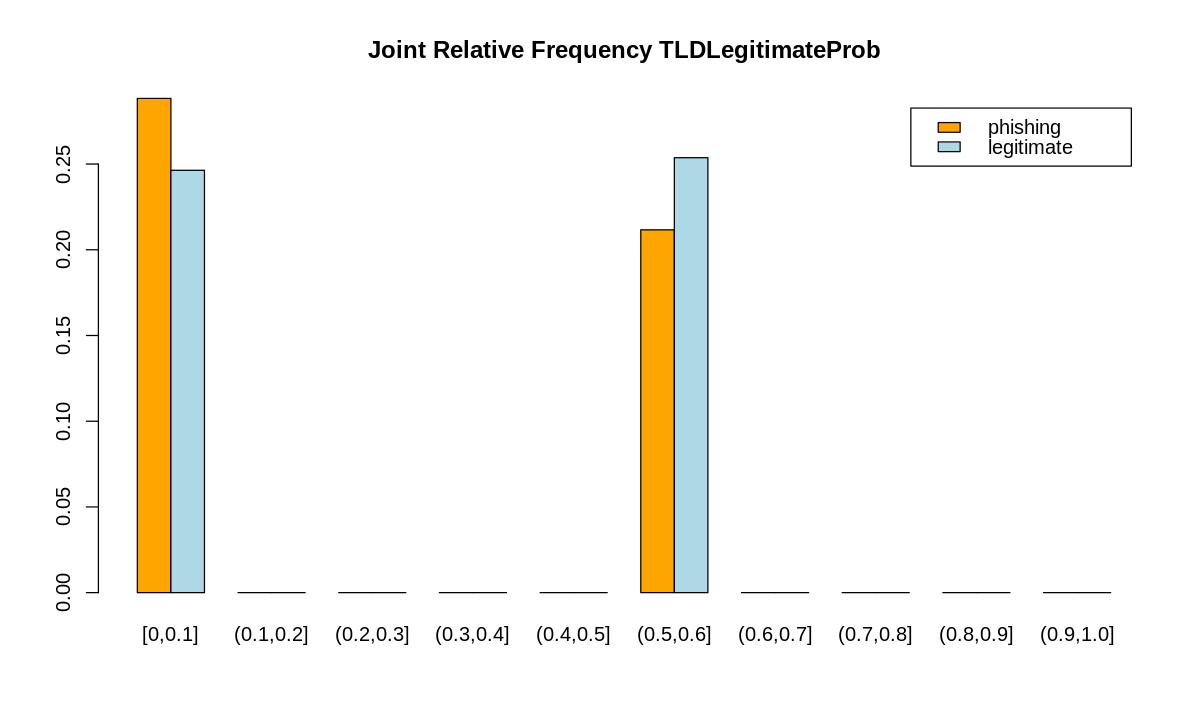

In [ ]:
# distribution
breaks <- c(-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

labels <- c("[0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
            "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]")

j_freq <- table(df$label, cut(df$TLDLegitimateProb, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency TLDLegitimateProb", beside=TRUE,
        legend = c("phishing", "legitimate"))

#### Correlation with label

In [ ]:
pearson <- cor(df$TLDLegitimateProb, df$label)
spearman <- cor(df$TLDLegitimateProb, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1063453
Spearman: 	 0.2127104

In [ ]:
df <- subset(df, select = -TLDLegitimateProb)

### 11. Feature **URLCharProb**

Delete this feature because:
*   It's an heuristic not detailed calculated by authors of dataset (probability not esplicated)
*   It depends to a repository of Phishing/Legitimate URL (dataset specific)
*   The totality of data is setting to 0 and variance is 0


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$URLCharProb)

cat('\nvar: ', var(df$URLCharProb), '\n')
cat('std: ', sd(df$URLCharProb))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001383 0.049183 0.057285 0.054867 0.062384 0.083819 


var:  0.0001198711 
std:  0.01094857

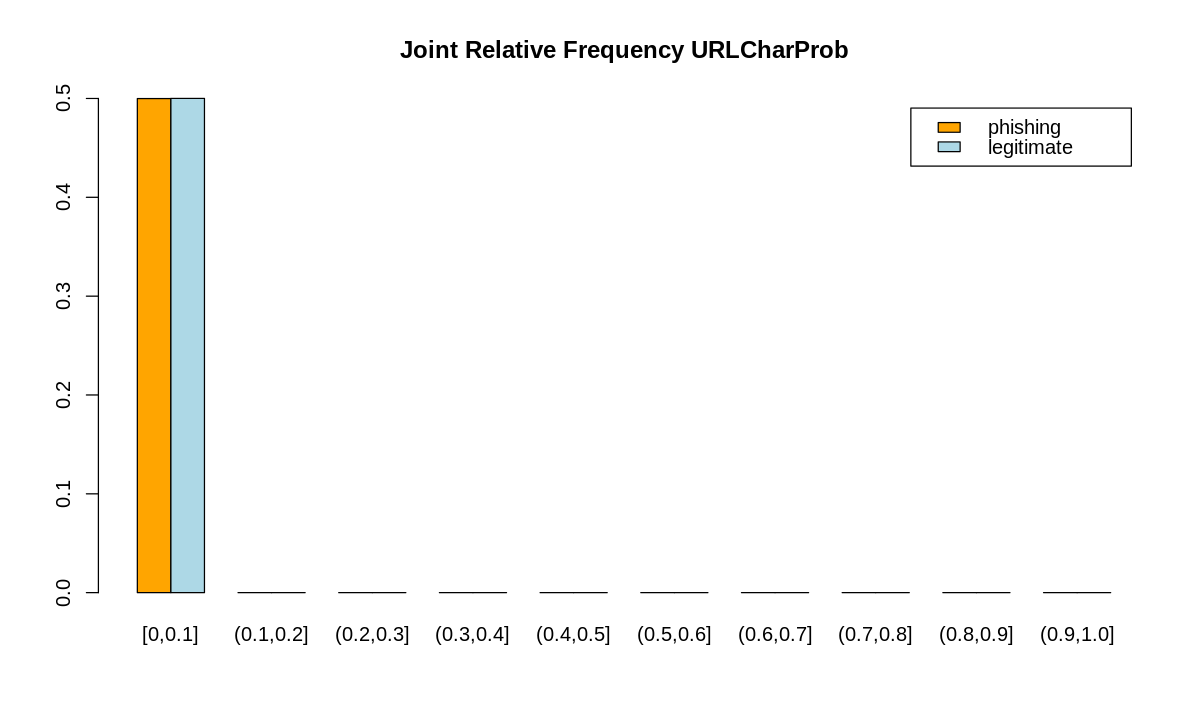

In [ ]:
# distribution
breaks <- c(-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

labels <- c("[0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
            "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]")

j_freq <- table(df$label, cut(df$URLCharProb, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency URLCharProb", beside=TRUE,
        legend = c("phishing", "legitimate"))

#### Correlation with label

In [ ]:
pearson <- cor(df$URLCharProb, df$label)
spearman <- cor(df$URLCharProb, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.4707727
Spearman: 	 0.4754136

In [ ]:
df <- subset(df, select = -URLCharProb)

### 12. Feature **URLTitleMatchScore**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$URLTitleMatchScore)

cat('\nvar: ', var(df$URLTitleMatchScore), '\n')
cat('std: ', sd(df$URLTitleMatchScore))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.075  47.638 100.000 100.000 


var:  2461.612 
std:  49.61464

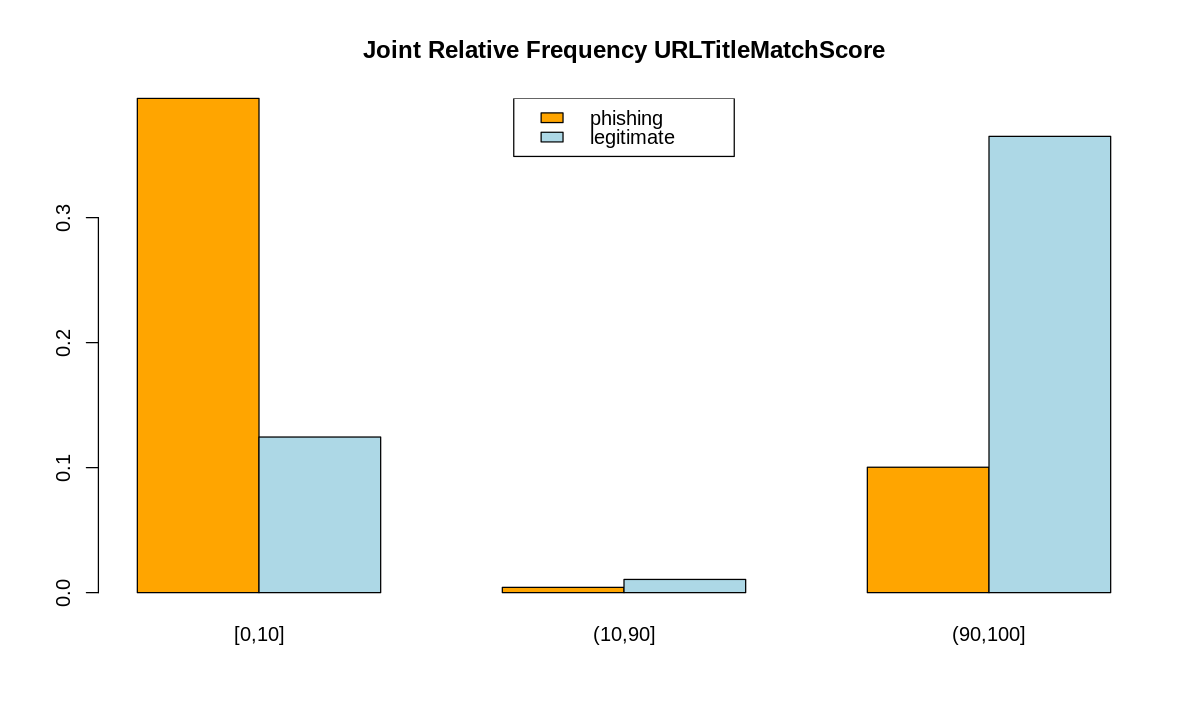

In [ ]:
breaks <- c(-1, 10, 90, 100)

labels <- c("[0,10]", "(10,90]", "(90,100]")

j_freq <- table(df$label, cut(df$URLTitleMatchScore, breaks = breaks,
                              labels = labels))
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency URLTitleMatchScore", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$URLTitleMatchScore)
summary(df_1$URLTitleMatchScore)

outliers <- count_outliers(df, "URLTitleMatchScore")
outliers_0 <- count_outliers(df_0, "URLTitleMatchScore")
outliers_1 <- count_outliers(df_1, "URLTitleMatchScore")

cat('\nn. outliers URLTitleMatchScore: \t', outliers)
cat('\nn. outliers URLTitleMatchScore (0): \t', outliers_0)
cat('\nn. outliers URLTitleMatchScore (1): \t', outliers_1)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.0000   0.0000  20.6477   0.9756 100.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   60.00  100.00   74.62  100.00  100.00 


n. outliers URLTitleMatchScore: 	 0
n. outliers URLTitleMatchScore (0): 	 2329
n. outliers URLTitleMatchScore (1): 	 0

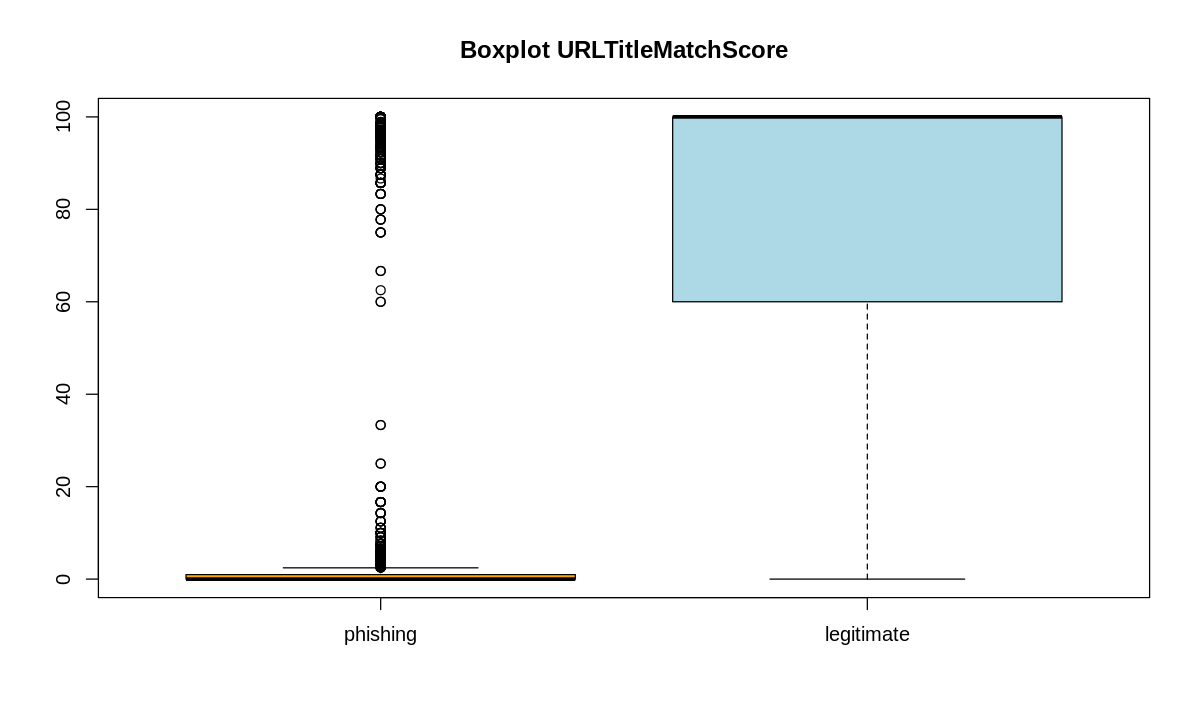

In [ ]:
boxplot(df_0$URLTitleMatchScore, df_1$URLTitleMatchScore,
        main = 'Boxplot URLTitleMatchScore', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "URLTitleMatchScore")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = -0.01526032 M2 = 0.01526032 
Overlap df_1: M1 = 99.37443 M2 = 100.6256 


#### Distribution form

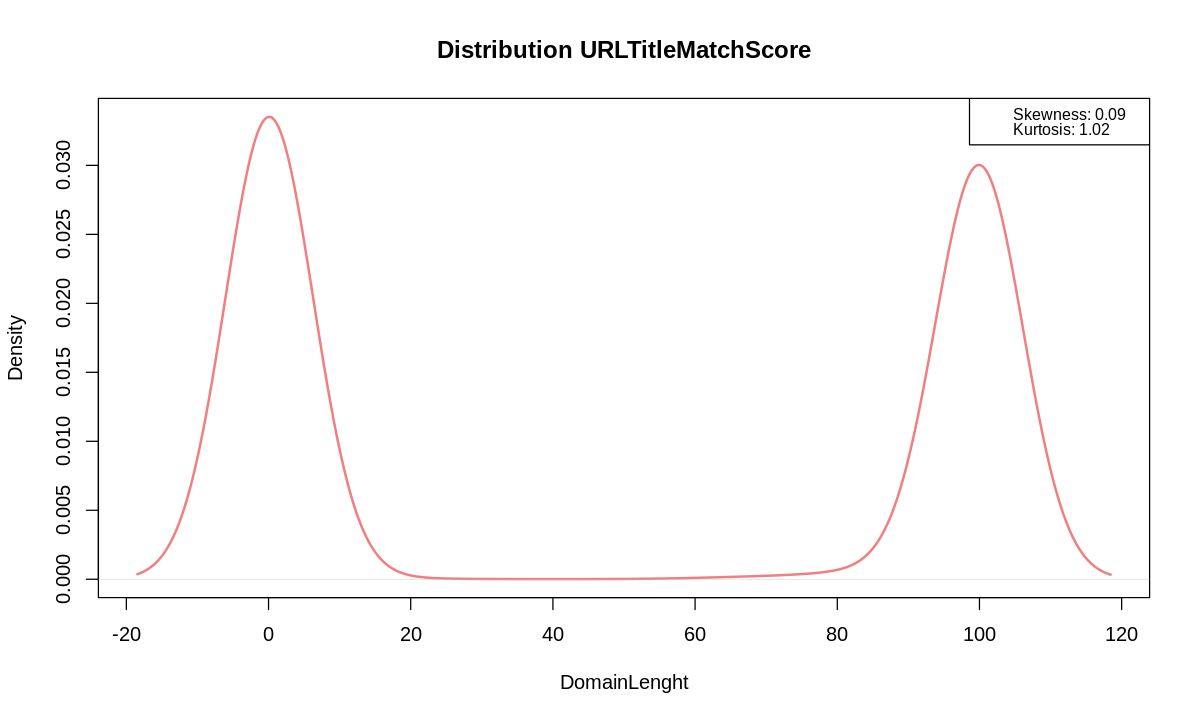

In [ ]:
skw_value <- skewness(df$URLTitleMatchScore)
kurtosis_value <- kurtosis(df$URLTitleMatchScore)

density <- density(df$URLTitleMatchScore)

plot(density, main = "Distribution URLTitleMatchScore",
     col = "lightcoral", lwd = 2, xlab = 'DomainLenght')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

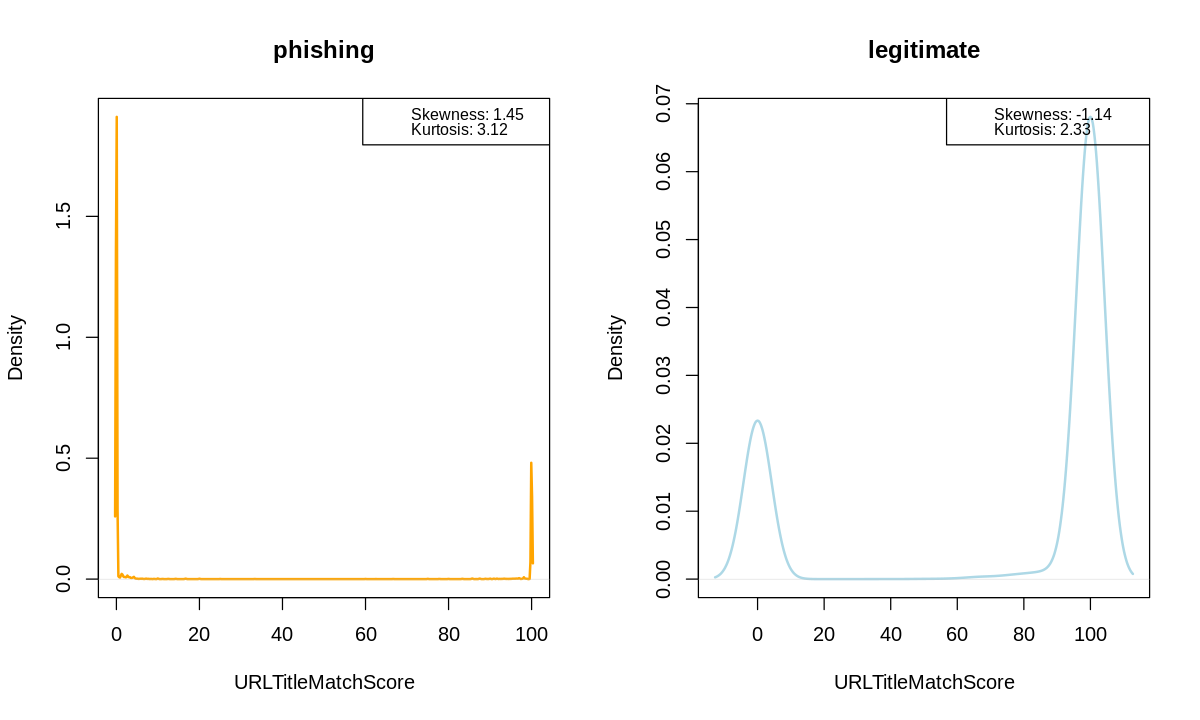

In [ ]:
skw_value_0 <- skewness(df_0$URLTitleMatchScore)
kurtosis_value_0 <- kurtosis(df_0$URLTitleMatchScore)

skw_value_1 <- skewness(df_1$URLTitleMatchScore)
kurtosis_value_1 <- kurtosis(df_1$URLTitleMatchScore)

density_0 <- density(df_0$URLTitleMatchScore)
density_1 <- density(df_1$URLTitleMatchScore)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "URLTitleMatchScore", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "URLTitleMatchScore", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$URLTitleMatchScore, df$label)
spearman <- cor(df$URLTitleMatchScore, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5439297
Spearman: 	 0.5295116

### 13. Feature **DomainTitleMatchScore**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$DomainTitleMatchScore)

cat('\nvar: ', var(df$DomainTitleMatchScore), '\n')
cat('std: ', sd(df$DomainTitleMatchScore))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   45.04  100.00  100.00 


var:  2446.309 
std:  49.46018

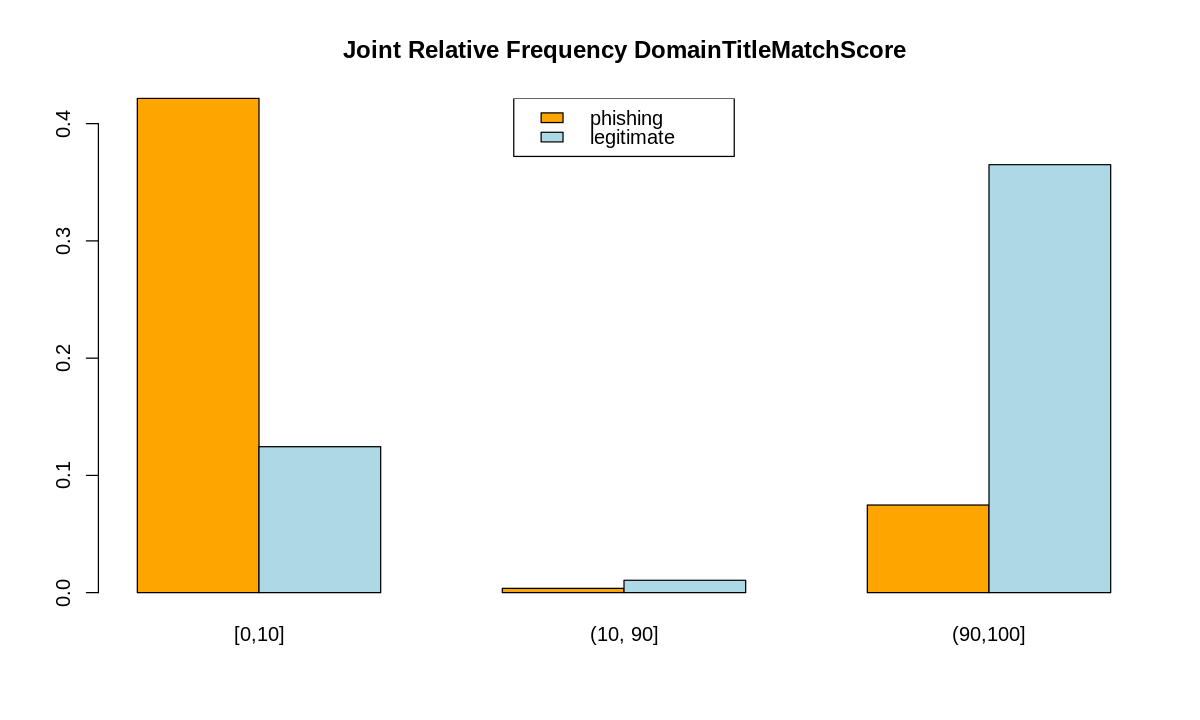

In [ ]:
breaks <- c(-1, 10, 90, 100)

labels <- c("[0,10]", "(10, 90]", "(90,100]")

j_freq <- table(df$label, cut(df$DomainTitleMatchScore, breaks = breaks,
                              labels = labels))
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency DomainTitleMatchScore", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$DomainTitleMatchScore)
summary(df_1$DomainTitleMatchScore)

outliers <- count_outliers(df, "DomainTitleMatchScore")
outliers_0 <- count_outliers(df_0, "DomainTitleMatchScore")
outliers_1 <- count_outliers(df_1, "DomainTitleMatchScore")

cat('\nn. outliers DomainTitleMatchScore: \t', outliers)
cat('\nn. outliers DomainTitleMatchScore (0): \t', outliers_0)
cat('\nn. outliers DomainTitleMatchScore (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   15.46    0.00  100.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   60.00  100.00   74.62  100.00  100.00 


n. outliers DomainTitleMatchScore: 	 0
n. outliers DomainTitleMatchScore (0): 	 1879
n. outliers DomainTitleMatchScore (1): 	 0

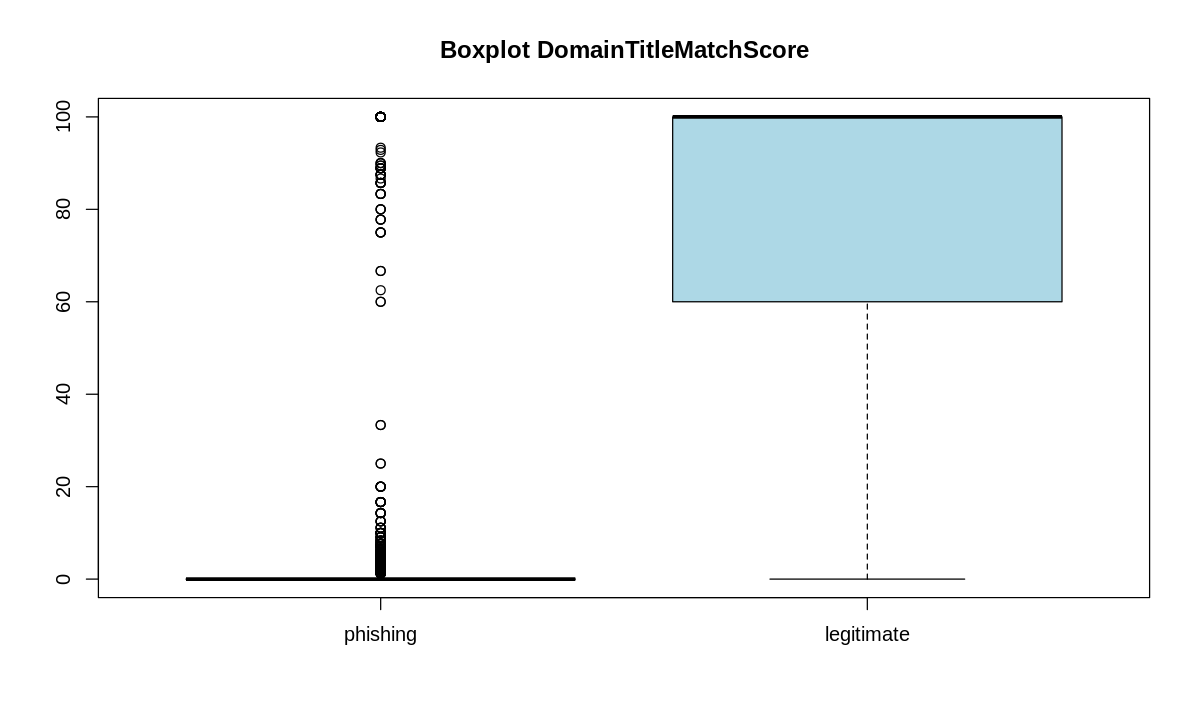

In [ ]:
boxplot(df_0$DomainTitleMatchScore, df_1$DomainTitleMatchScore,
        main = 'Boxplot DomainTitleMatchScore', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

#### Distribution Form

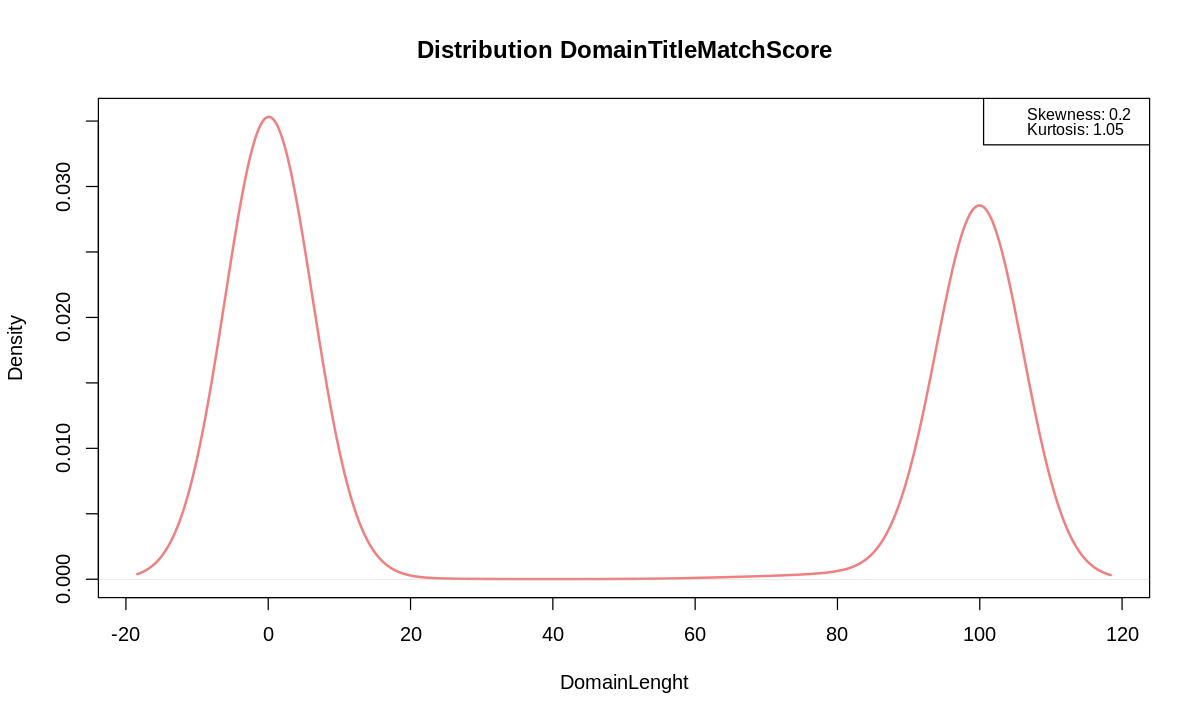

In [ ]:
skw_value <- skewness(df$DomainTitleMatchScore)
kurtosis_value <- kurtosis(df$DomainTitleMatchScore)

density <- density(df$DomainTitleMatchScore)

plot(density, main = "Distribution DomainTitleMatchScore",
     col = "lightcoral", lwd = 2, xlab = 'DomainLenght')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

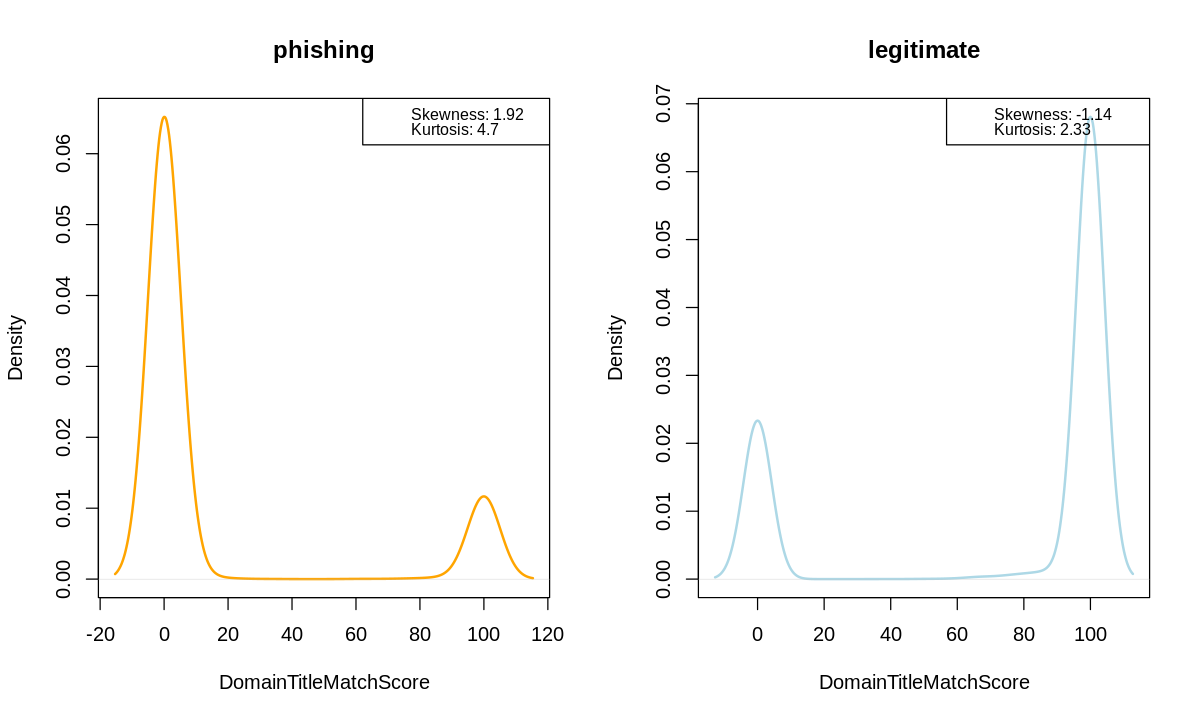

In [ ]:
skw_value_0 <- skewness(df_0$DomainTitleMatchScore)
kurtosis_value_0 <- kurtosis(df_0$DomainTitleMatchScore)

skw_value_1 <- skewness(df_1$DomainTitleMatchScore)
kurtosis_value_1 <- kurtosis(df_1$DomainTitleMatchScore)

density_0 <- density(df_0$DomainTitleMatchScore)
density_1 <- density(df_1$DomainTitleMatchScore)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "DomainTitleMatchScore", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "DomainTitleMatchScore", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$DomainTitleMatchScore, df$label)
spearman <- cor(df$DomainTitleMatchScore, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5980744
Spearman: 	 0.582144

### 14. Feature **TLDLenght**

Delete this feature because has:
* lower variance
* overlap median for both distribution (phishing/legitimate)
* correlation with feature target tending to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$TLDLength)

cat('\nvar: ', var(df$TLDLength), '\n')
cat('std: ', sd(df$TLDLength))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    2.00    3.00    2.77    3.00   13.00 


var:  0.3711935 
std:  0.6092566

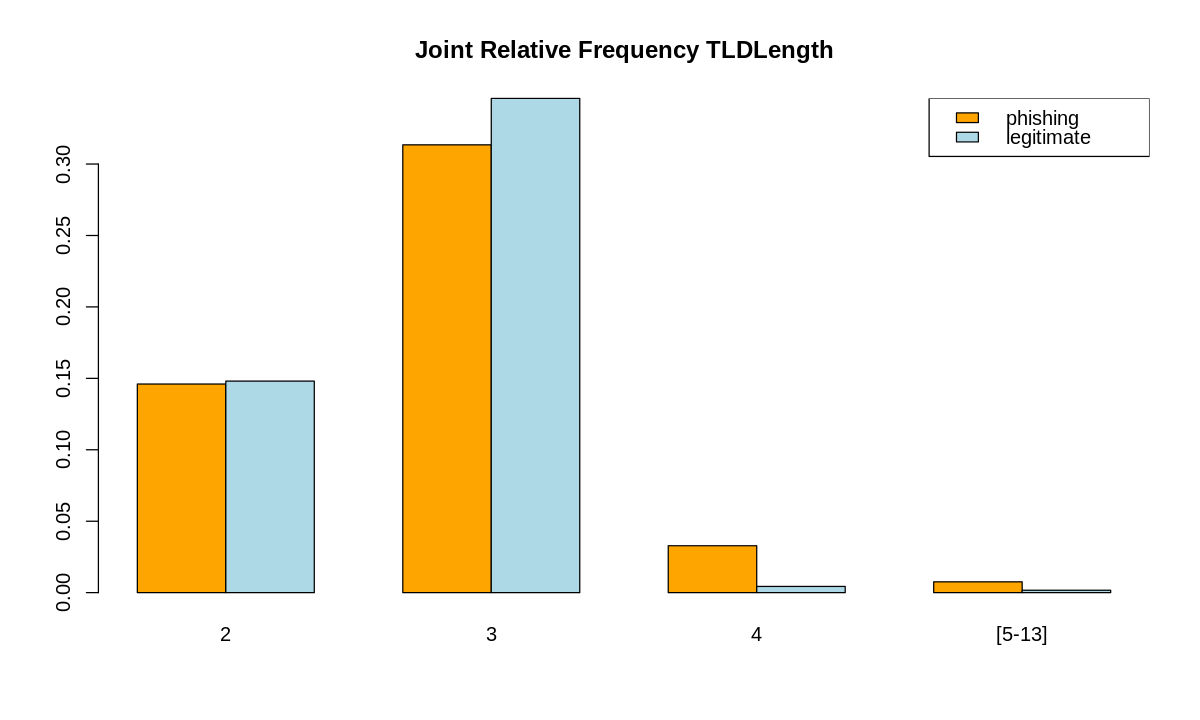

In [ ]:
breaks <- c(1, 2, 3, 4, 13)

labels <- c("2", "3", "4", "[5-13]")

j_freq <- table(df$label, cut(df$TLDLength, breaks = breaks,
                              labels = labels))
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency TLDLength", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$TLDLength)
summary(df_1$TLDLength)

outliers <- count_outliers(df, "TLDLength")
outliers_0 <- count_outliers(df_0, "TLDLength")
outliers_1 <- count_outliers(df_1, "TLDLength")

cat('\nn. outliers TLDLenght: \t\t', outliers)
cat('\nn. outliers TLDLength (0): \t', outliers_0)
cat('\nn. outliers TLDLength (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   3.000   2.817   3.000  12.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   3.000   2.724   3.000  13.000 


n. outliers TLDLenght: 		 187
n. outliers TLDLength (0): 	 153
n. outliers TLDLength (1): 	 34

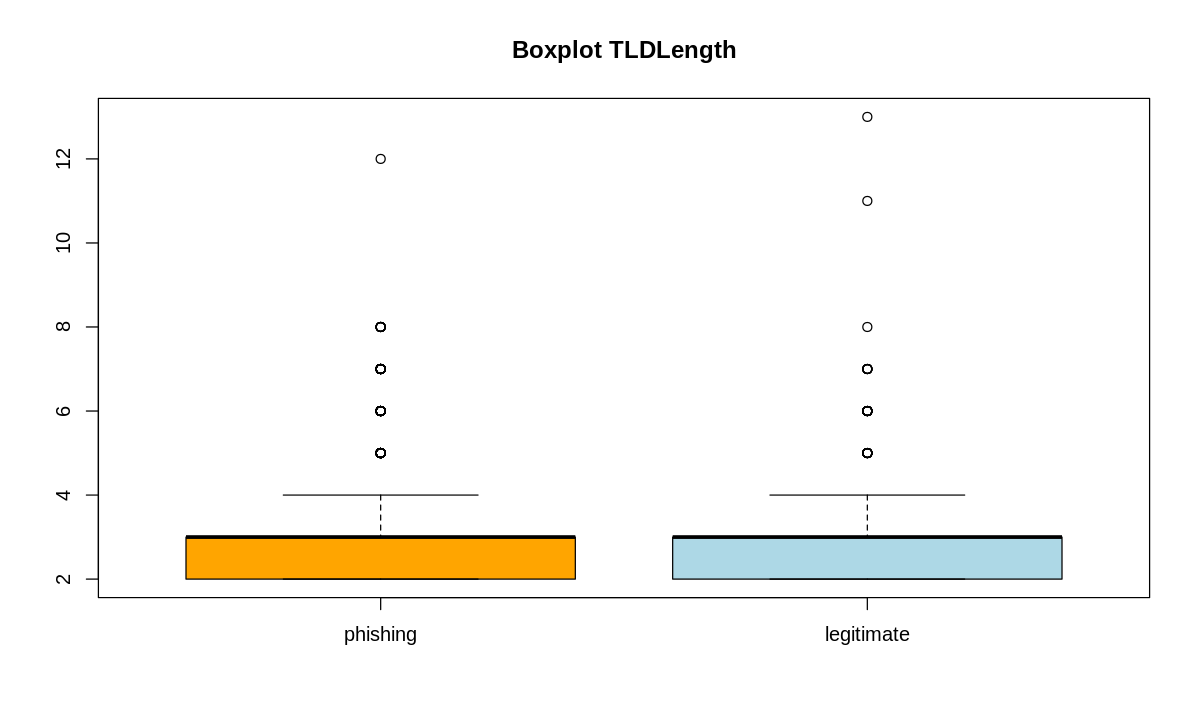

In [ ]:
boxplot(df_0$TLDLength, df_1$TLDLength,
        main = 'Boxplot TLDLength', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "TLDLenght")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = NA M2 = NA 
Overlap df_1: M1 = NA M2 = NA 


#### Correlation with label

In [ ]:
pearson <- cor(df$TLDLength, df$label)
spearman <- cor(df$TLDLength, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.0765033
Spearman: 	 -0.0545694

In [ ]:
df <- subset(df, select = -TLDLength)

### 15. Feature **NoOfSubdomain**

Delete this feature because has:
* lower variance
* overlap median for both distribution (phishing/legitimate)
* correlation with feature target tending to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfSubDomain)

cat('\nvar: ', var(df$NoOfSubDomain), '\n')
cat('std: ', sd(df$NoOfSubDomain))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.172   1.000   6.000 


var:  0.4119983 
std:  0.641871

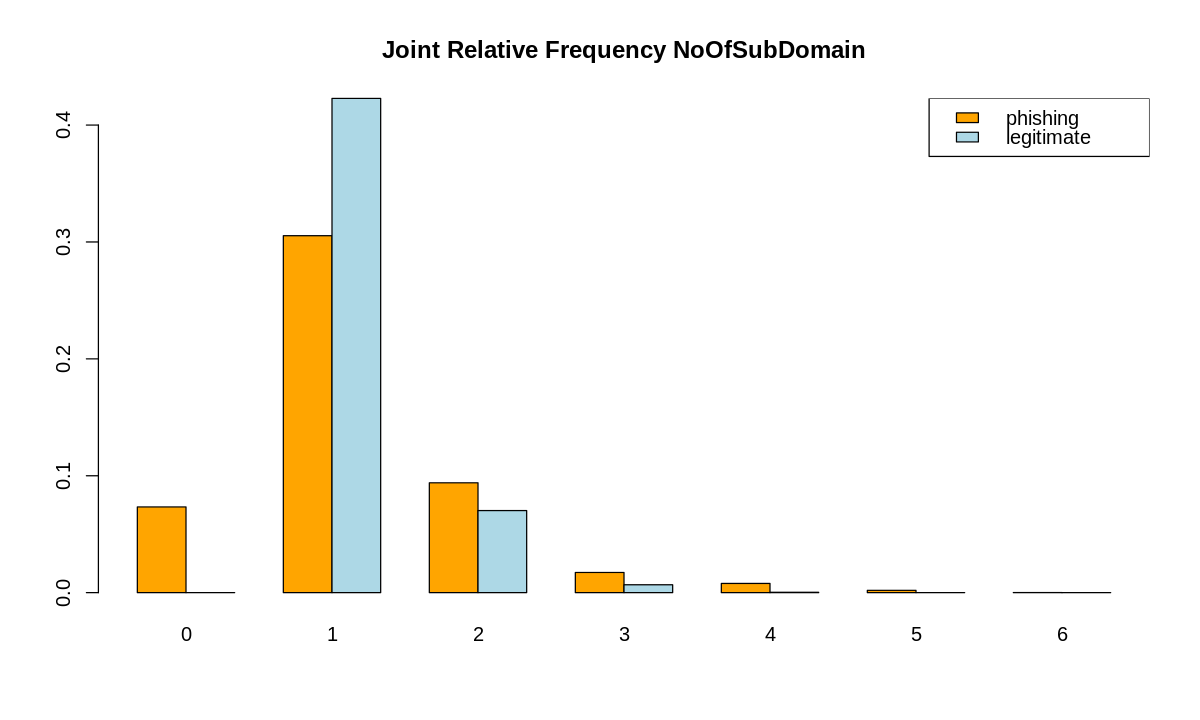

In [ ]:
j_freq <- table(df$label, df$NoOfSubDomain)

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfSubDomain", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfSubDomain)
summary(df_1$NoOfSubDomain)

outliers <- count_outliers(df, "NoOfSubDomain")
outliers_0 <- count_outliers(df_0, "NoOfSubDomain")
outliers_1 <- count_outliers(df_1, "NoOfSubDomain")

cat('\nn. outliers NoOfSubDomain: \t', outliers)
cat('\nn. outliers NoOfSubDomain (0): \t', outliers_0)
cat('\nn. outliers NoOfSubDomain (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.175   1.000   6.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.169   1.000   4.000 


n. outliers NoOfSubDomain: 	 5478
n. outliers NoOfSubDomain (0): 	 3921
n. outliers NoOfSubDomain (1): 	 1557

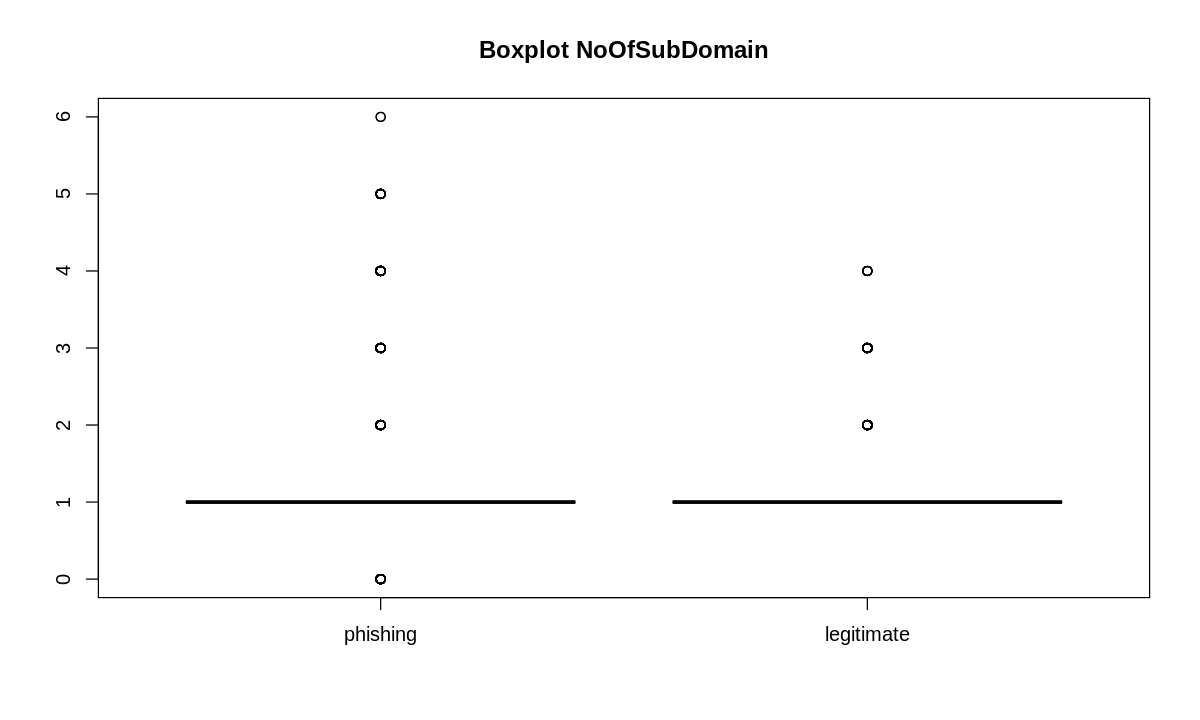

In [ ]:
boxplot(df_0$NoOfSubDomain, df_1$NoOfSubDomain,
        main = 'Boxplot NoOfSubDomain', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfSubdomain")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = NA M2 = NA 
Overlap df_1: M1 = NA M2 = NA 


#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfSubDomain, df$label)
spearman <- cor(df$NoOfSubDomain, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.004214486
Spearman: 	 0.0341739

In [ ]:
df <- subset(df, select = -NoOfSubDomain)

### 16. Feature **HasObfuscation**

Delete this feature because has:
* lower variance tending to 0
* all values setting to 0
* correlation with feature target tending to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasObfuscation)

cat('\nvar: ', var(df$HasObfuscation), '\n')
cat('std: ', sd(df$HasObfuscation))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.002382 0.000000 1.000000 


var:  0.002376224 
std:  0.04874653

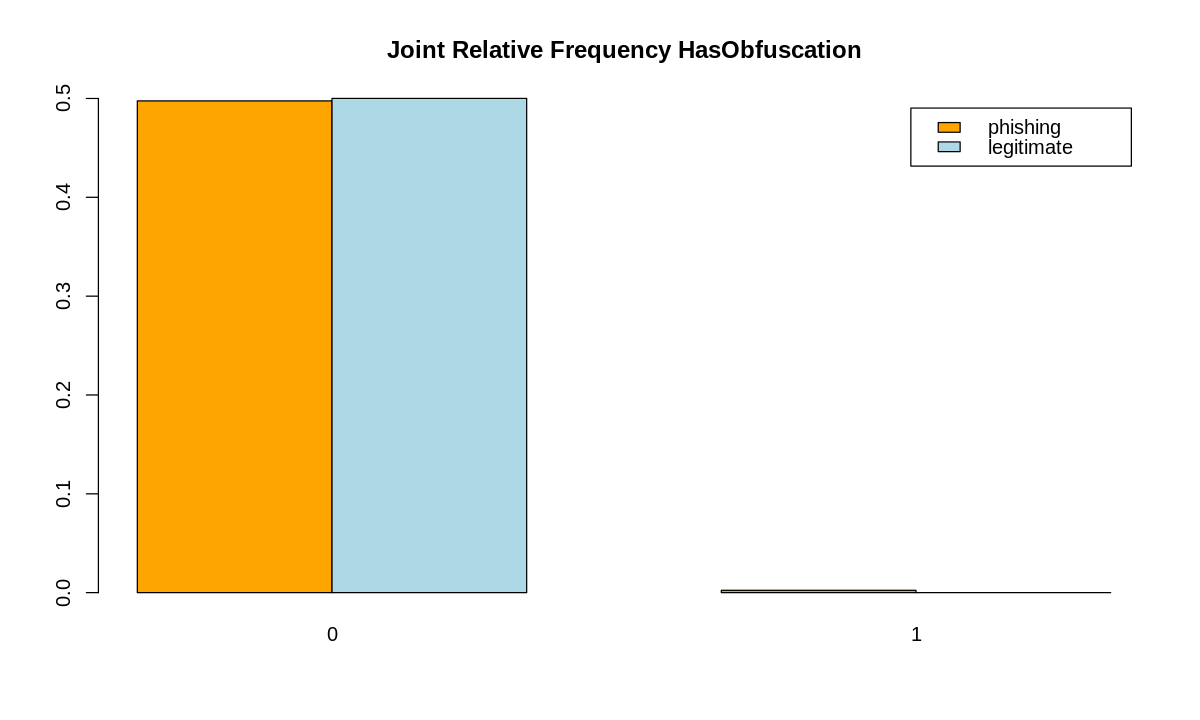

In [ ]:
j_freq <- table(df$label, df$HasObfuscation)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

barplot(j_freq_rel, beside=TRUE, col = c("orange", "lightblue"),
        legend = c("phishing", "legitimate"),
        main = "Joint Relative Frequency HasObfuscation")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasObfuscation, df$label)
spearman <- cor(df$HasObfuscation, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.04886897
Spearman: 	 -0.04886897

In [ ]:
df <- subset(df, select = -HasObfuscation)

### 17. Feature **NoOfObfuscatedChar**

Delete this feature because has:
* lower variance
* overlap median for both distribution (phishing/legitimate)
* correlation with feature target tending to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfObfuscatedChar)

cat('\nvar: ', var(df$NoOfObfuscatedChar), '\n')
cat('std: ', sd(df$NoOfObfuscatedChar))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00000  0.00000  0.00000  0.01801  0.00000 24.00000 


var:  0.1957355 
std:  0.44242

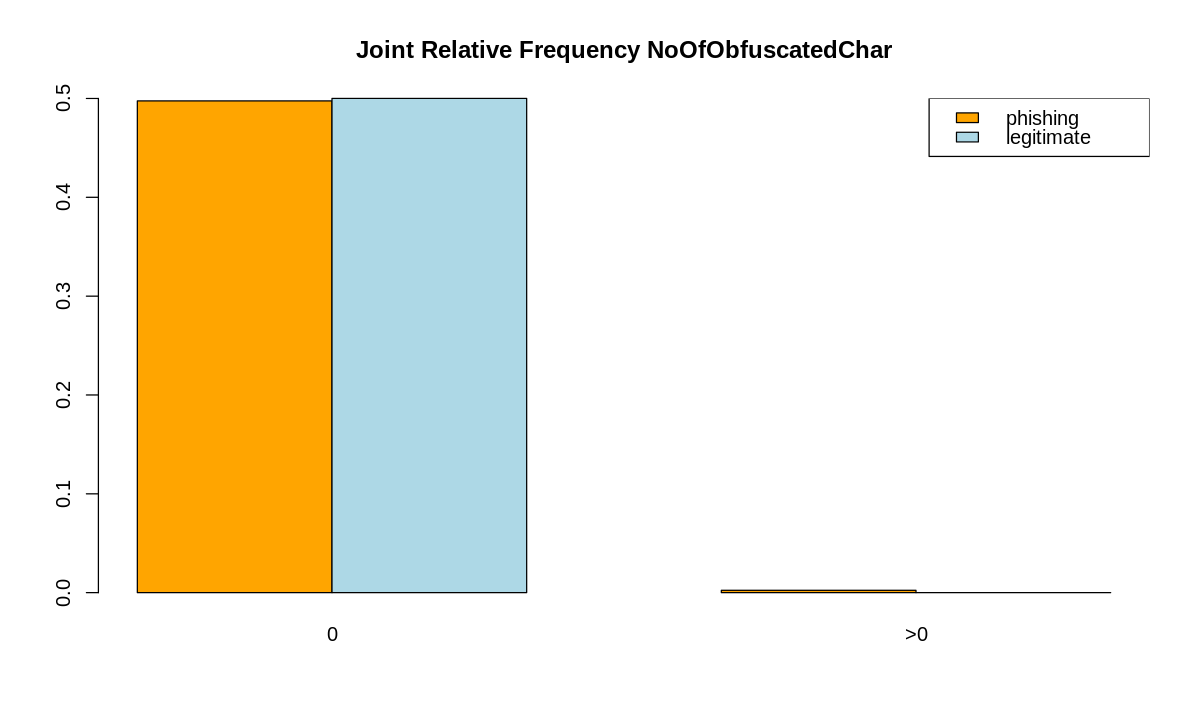

In [ ]:
j_freq <- t(table(ObfuscationRatio = ifelse(df$NoOfObfuscatedChar == 0, "0", ">0"),
                label = df$label))

j_freq_rel <- prop.table(j_freq)

j_freq_rel <- j_freq_rel[, rev(colnames(j_freq))]

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfObfuscatedChar", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfObfuscatedChar)
summary(df_1$NoOfObfuscatedChar)

outliers <- count_outliers(df, "NoOfObfuscatedChar")
outliers_0 <- count_outliers(df_0, "NoOfObfuscatedChar")
outliers_1 <- count_outliers(df_1, "NoOfObfuscatedChar")

cat('\nn. outliers NoOfObfuscatedChar: \t', outliers)
cat('\nn. outliers NoOfObfuscatedChar (0): \t', outliers_0)
cat('\nn. outliers NoOfObfuscatedChar (1): \t', outliers_1)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00000  0.00000  0.00000  0.03603  0.00000 24.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


n. outliers NoOfObfuscatedChar: 	 48
n. outliers NoOfObfuscatedChar (0): 	 48
n. outliers NoOfObfuscatedChar (1): 	 0

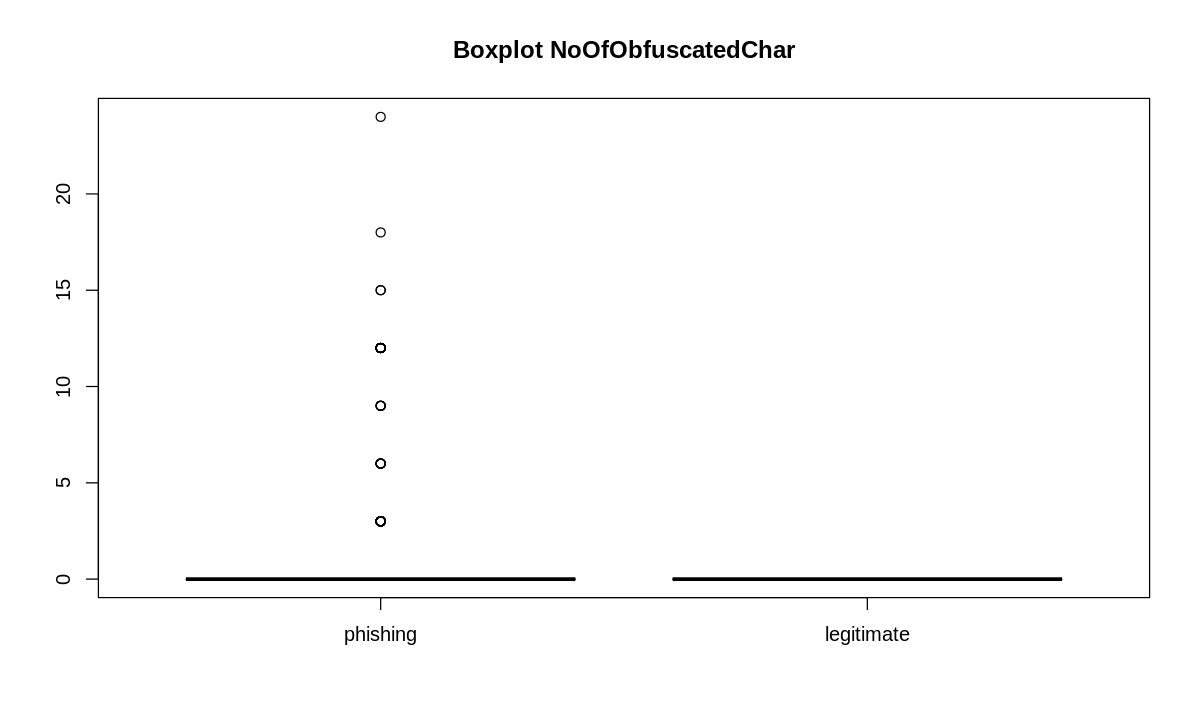

In [ ]:
boxplot(df_0$NoOfObfuscatedChar, df_1$NoOfObfuscatedChar,
        main = 'Boxplot NoOfObfuscatedChar', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfObfuscatedChar")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 0 M2 = 0 
Overlap df_1: M1 = 0 M2 = 0 


#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfObfuscatedChar, df$label)
spearman <- cor(df$NoOfObfuscatedChar, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.04071998
Spearman: 	 -0.04886893

In [ ]:
df <- subset(df, select = -NoOfObfuscatedChar)

### 18. Feature **ObfuscationRatio**

Delete this feature because has:
* lower variance
* overlap median for both distribution (phishing/legitimate)
* correlation with feature target tending to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$ObfuscationRatio)

cat('\nvar: ', var(df$ObfuscationRatio), '\n')
cat('std: ', sd(df$ObfuscationRatio))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0001619 0.0000000 0.2030000 


var:  0.00001493155 
std:  0.003864137

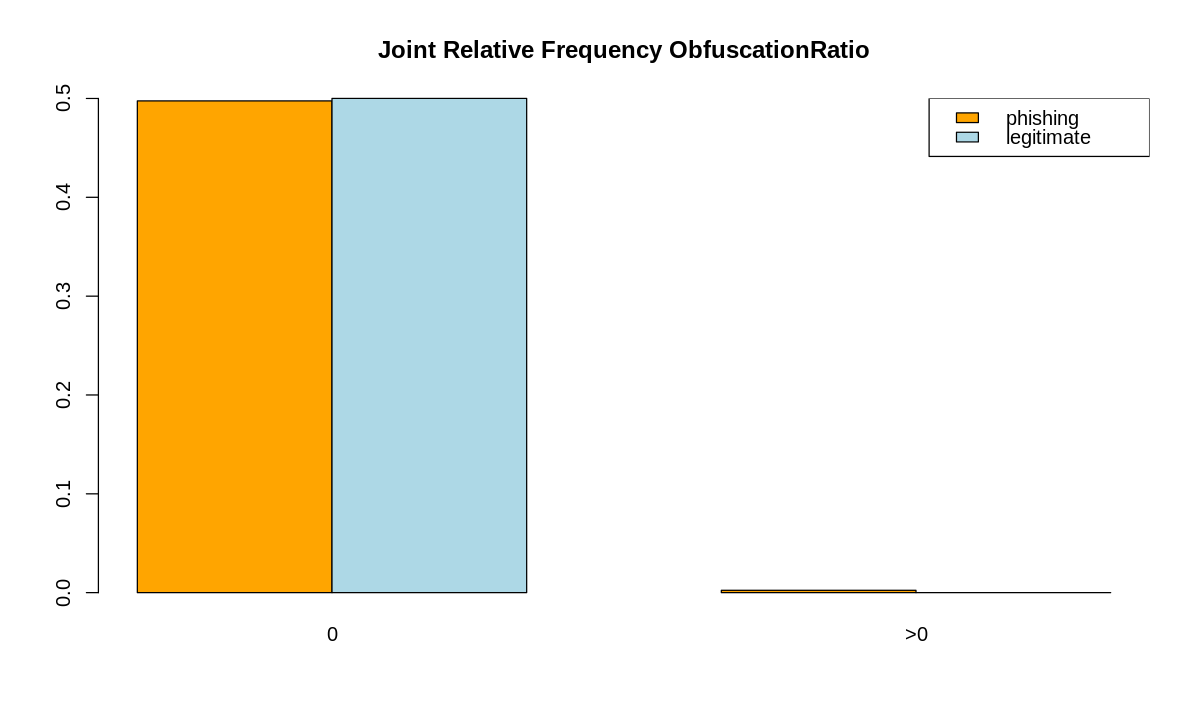

In [ ]:
j_freq <- t(table(ObfuscationRatio = ifelse(df$ObfuscationRatio == 0, "0", ">0"),
                label = df$label))

j_freq_rel <- prop.table(j_freq)

j_freq_rel <- j_freq_rel[, rev(colnames(j_freq))]

# # barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency ObfuscationRatio", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$ObfuscationRatio)
summary(df_1$ObfuscationRatio)

outliers <- count_outliers(df, "ObfuscationRatio")
outliers_0 <- count_outliers(df_0, "ObfuscationRatio")
outliers_1 <- count_outliers(df_1, "ObfuscationRatio")

cat('\nn. outliers ObfuscationRatio: \t\t', outliers)
cat('\nn. outliers ObfuscationRatio (0): \t', outliers_0)
cat('\nn. outliers ObfuscationRatio (1): \t', outliers_1)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0003239 0.0000000 0.2030000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


n. outliers ObfuscationRatio: 		 48
n. outliers ObfuscationRatio (0): 	 48
n. outliers ObfuscationRatio (1): 	 0

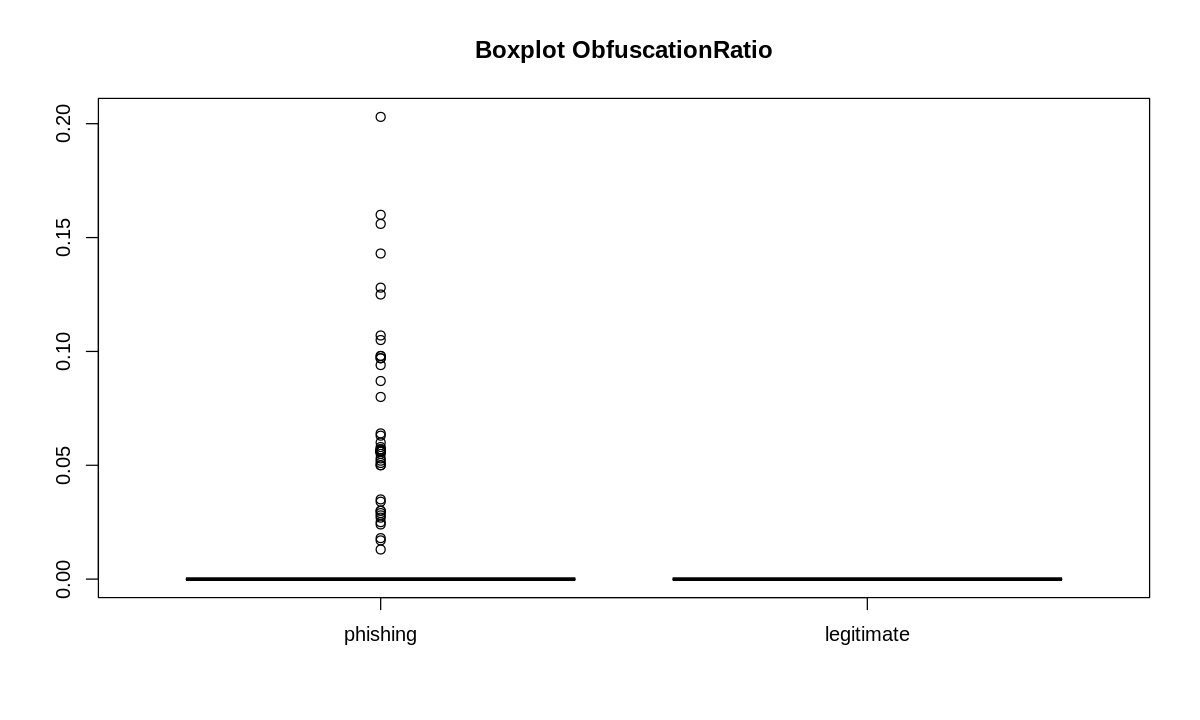

In [ ]:
boxplot(df_0$ObfuscationRatio, df_1$ObfuscationRatio,
        main = 'Boxplot ObfuscationRatio', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "ObfuscationRatio")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 0 M2 = 0 
Overlap df_1: M1 = 0 M2 = 0 


#### Correlation with label

In [ ]:
pearson <- cor(df$ObfuscationRatio, df$label)
spearman <- cor(df$ObfuscationRatio, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.04190832
Spearman: 	 -0.04886893

In [ ]:
df <- subset(df, select = -ObfuscationRatio)

### 19. Feature **NoOfLettersInURL**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfLettersInURL)

cat('\nvar: ', var(df$NoOfLettersInURL), '\n')
cat('std: ', sd(df$NoOfLettersInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0      11      15      21      22     656 


var:  607.7286 
std:  24.65215

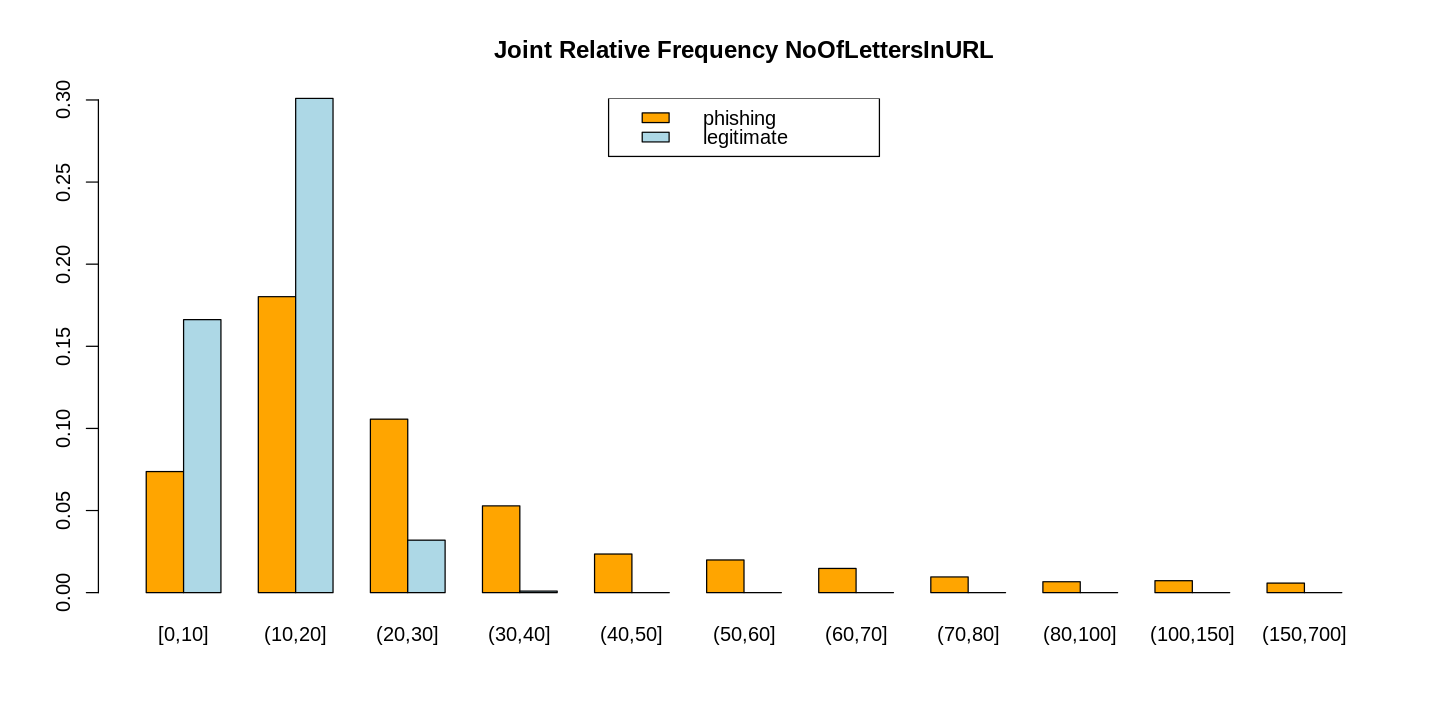

In [ ]:
breaks <- c(-1, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 700)

labels <- c("[0,10]", "(10,20]", "(20,30]", "(30,40]", "(40,50]", "(50,60]",
            "(60,70]", "(70,80]", "(80,100]", "(100,150]", "(150,700]")

j_freq <- table(df$label, cut(df$NoOfLettersInURL, breaks = breaks,
                              labels = labels))
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfLettersInURL", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfLettersInURL)
summary(df_1$NoOfLettersInURL)

outliers <- count_outliers(df, "NoOfLettersInURL")
outliers_0 <- count_outliers(df_0, "NoOfLettersInURL")
outliers_1 <- count_outliers(df_1, "NoOfLettersInURL")

cat('\nn. outliers NoOfLettersInURL: \t\t', outliers)
cat('\nn. outliers NoOfLettersInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfLettersInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   13.00   20.00   29.04   32.00  656.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    9.00   13.00   12.97   16.00   36.00 


n. outliers NoOfLettersInURL: 		 1867
n. outliers NoOfLettersInURL (0): 	 888
n. outliers NoOfLettersInURL (1): 	 89

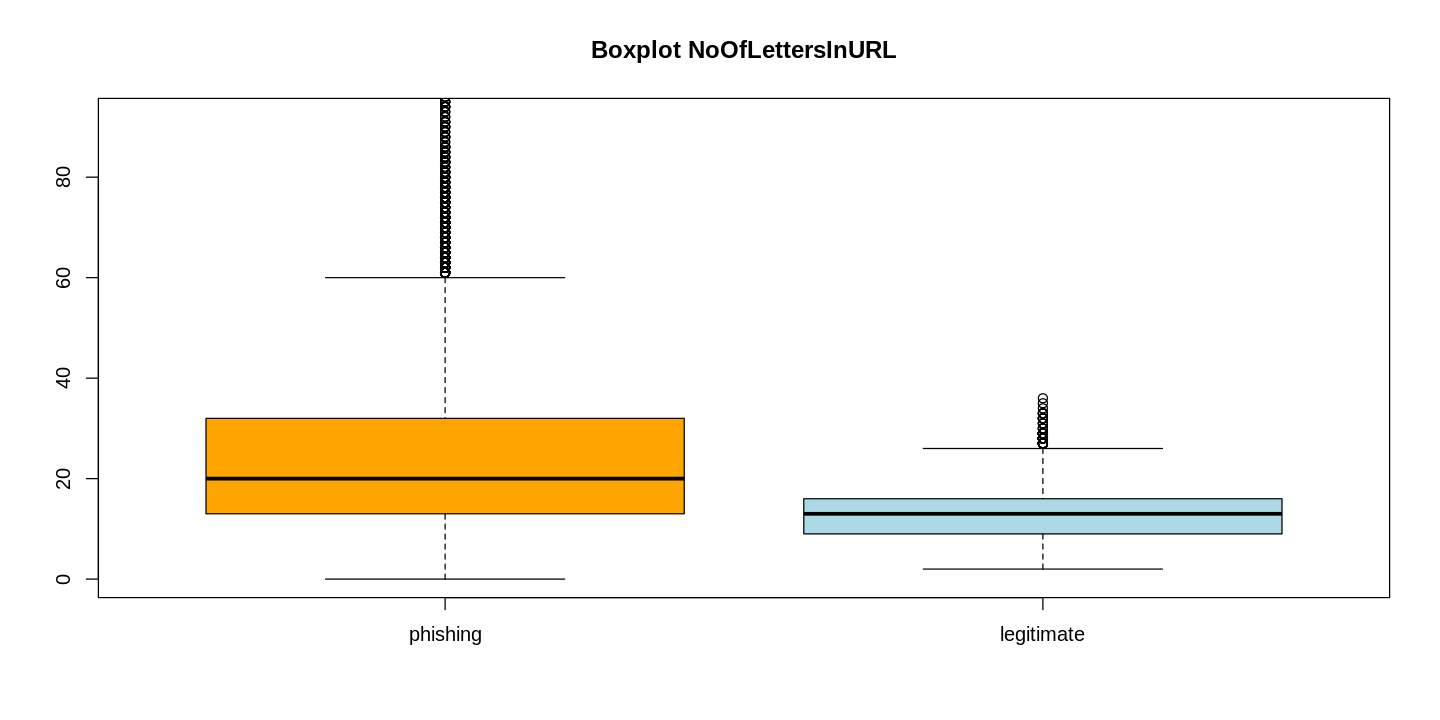

In [ ]:
boxplot(df_0$NoOfLettersInURL, df_1$NoOfLettersInURL,
        main = 'Boxplot NoOfLettersInURL', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfLettersInURL), quantile(df_0$NoOfLettersInURL, 0.97)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfLettersInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 19.70281 M2 = 20.29719 
Overlap df_1: M1 = 12.89053 M2 = 13.10947 


#### Distribution form

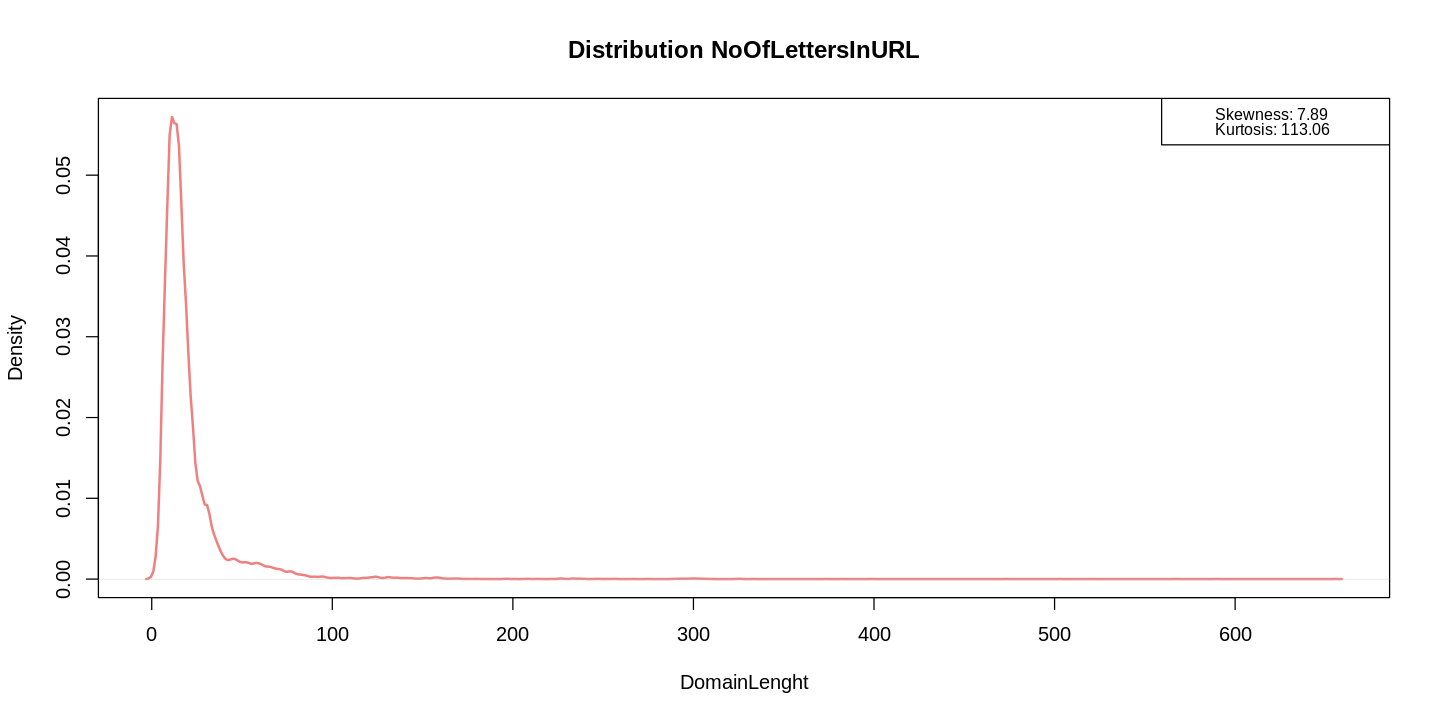

In [ ]:
skw_value <- skewness(df$NoOfLettersInURL)
kurtosis_value <- kurtosis(df$NoOfLettersInURL)

density <- density(df$NoOfLettersInURL)

plot(density, main = "Distribution NoOfLettersInURL",
     col = "lightcoral", lwd = 2, xlab = 'DomainLenght')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

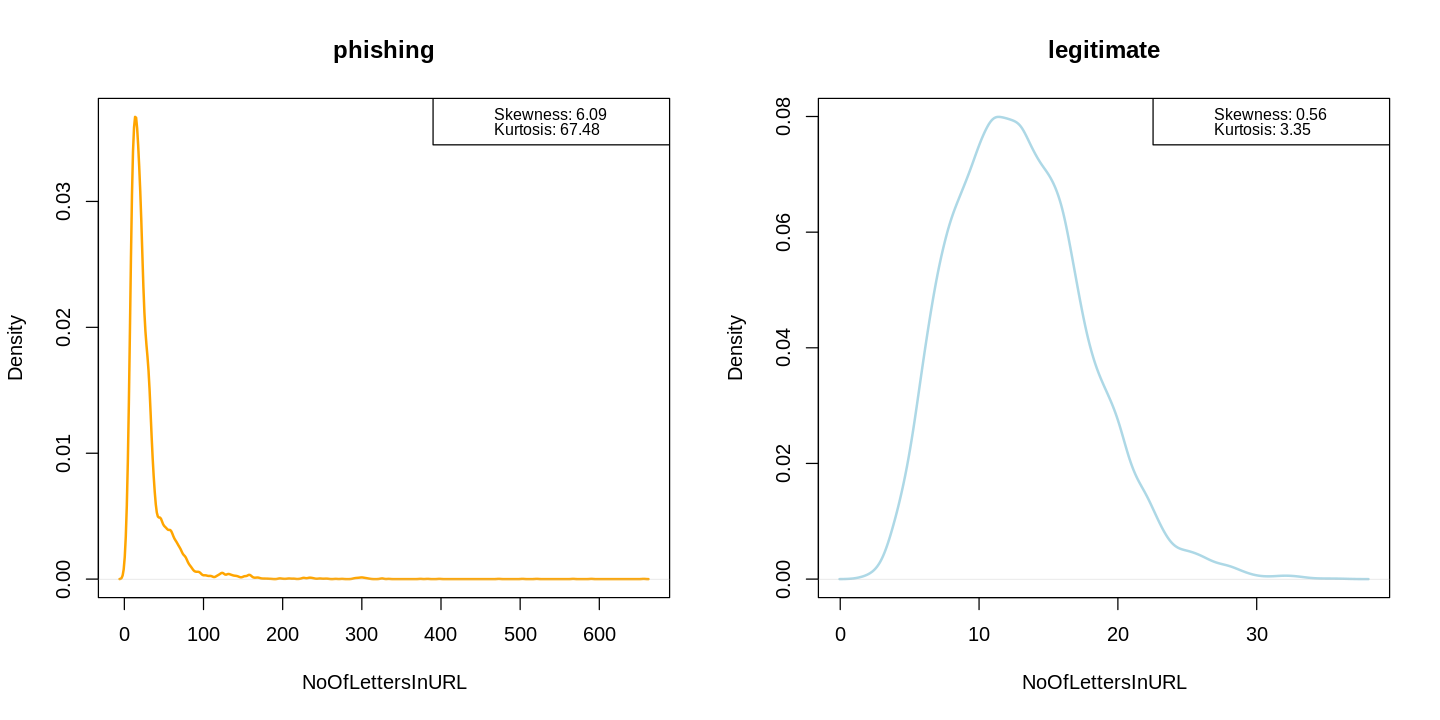

In [ ]:
skw_value_0 <- skewness(df_0$NoOfLettersInURL)
kurtosis_value_0 <- kurtosis(df_0$NoOfLettersInURL)

skw_value_1 <- skewness(df_1$NoOfLettersInURL)
kurtosis_value_1 <- kurtosis(df_1$NoOfLettersInURL)

density_0 <- density(df_0$NoOfLettersInURL)
density_1 <- density(df_1$NoOfLettersInURL)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "NoOfLettersInURL", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "NoOfLettersInURL", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfLettersInURL, df$label)
spearman <- cor(df$NoOfLettersInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.3261155
Spearman: 	 -0.4456935

### 20. Feature **LetterRatioInURL**

Delete this feature because has:
* lower variance tending 0 than **NoOfLettersInURL**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$LetterRatioInURL)

cat('\nvar: ', var(df$LetterRatioInURL), '\n')
cat('std: ', sd(df$LetterRatioInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.4400  0.5200  0.5262  0.6110  0.8860 


var:  0.01624238 
std:  0.1274456

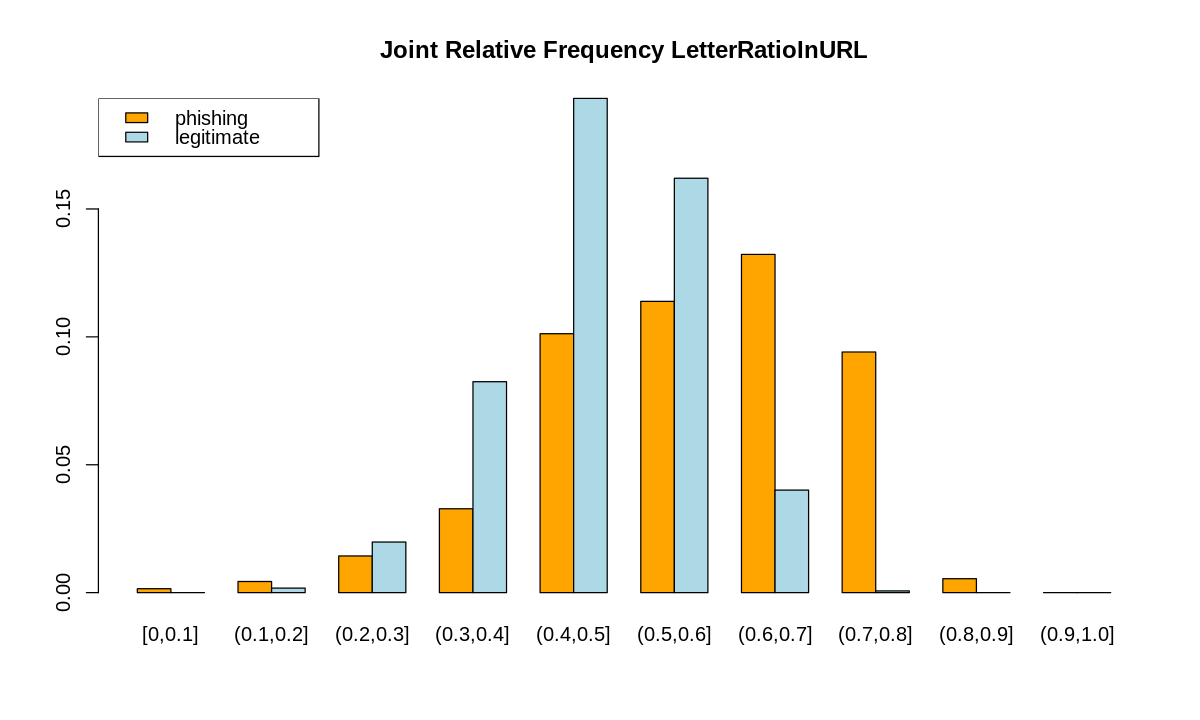

In [ ]:
# distribution
breaks <- c(-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

labels <- c("[0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
            "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]")

j_freq <- table(df$label, cut(df$LetterRatioInURL, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency LetterRatioInURL", beside = TRUE)

legend("topleft", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$LetterRatioInURL)
summary(df_1$LetterRatioInURL)

outliers <- count_outliers(df, "LetterRatioInURL")
outliers_0 <- count_outliers(df_0, "LetterRatioInURL")
outliers_1 <- count_outliers(df_1, "LetterRatioInURL")

cat('\nn. outliers LetterRatioInURL: \t\t', outliers)
cat('\nn. outliers LetterRatioInURL (0): \t', outliers_0)
cat('\nn. outliers LetterRatioInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.4800  0.5880  0.5753  0.6830  0.8860 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1050  0.4090  0.4810  0.4772  0.5520  0.7350 


n. outliers LetterRatioInURL: 		 96
n. outliers LetterRatioInURL (0): 	 71
n. outliers LetterRatioInURL (1): 	 32

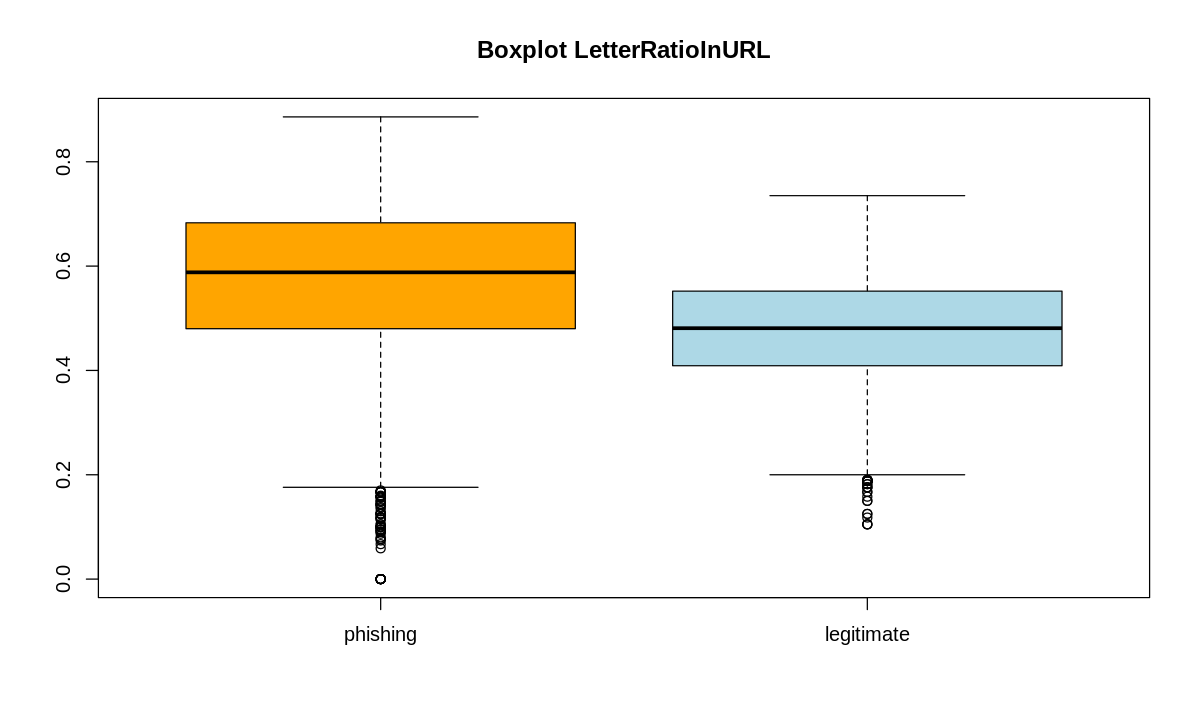

In [ ]:
boxplot(df_0$LetterRatioInURL, df_1$LetterRatioInURL,
        main = 'Boxplot LetterRatioInURL', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "LetterRatioInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 0.5848248 M2 = 0.5911752 
Overlap df_1: M1 = 0.4787636 M2 = 0.4832364 


#### Correlation with label

In [ ]:
pearson <- cor(df$LetterRatioInURL, df$label)
spearman <- cor(df$LetterRatioInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.3847554
Spearman: 	 -0.3978248

#### Correlation with similar feature **NoOfLettersInURL**

In [ ]:
pearson <- cor(df$LetterRatioInURL, df$NoOfLettersInURL)
spearman <- cor(df$LetterRatioInURL, df$NoOfLettersInURL, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5297944
Spearman: 	 0.9218939

In [ ]:
df <- subset(df, select = -LetterRatioInURL)

### 21. Feature **NoOfDegitsInURL**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfDegitsInURL)

cat('\nvar: ', var(df$NoOfDegitsInURL), '\n')
cat('std: ', sd(df$NoOfDegitsInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   2.236   1.000 264.000 


var:  65.31214 
std:  8.081593

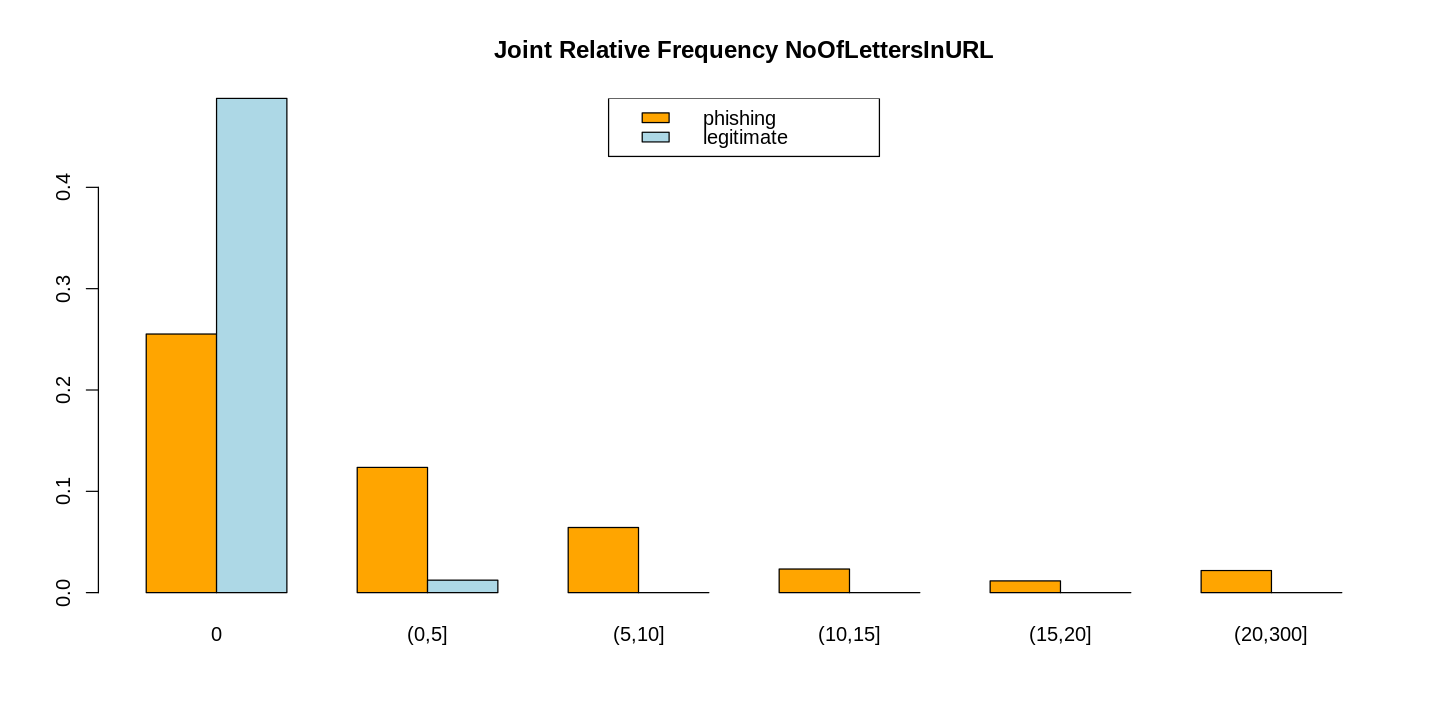

In [ ]:
breaks <- c(-1, 0, 5, 10, 15, 20, 300)

labels <- c("0", "(0,5]", "(5,10]", "(10,15]", "(15,20]", "(20,300]")

j_freq <- table(df$label, cut(df$NoOfDegitsInURL, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfLettersInURL", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfDegitsInURL)
summary(df_1$NoOfDegitsInURL)

outliers <- count_outliers(df, "NoOfDegitsInURL")
outliers_0 <- count_outliers(df_0, "NoOfDegitsInURL")
outliers_1 <- count_outliers(df_1, "NoOfDegitsInURL")

cat('\nn. outliers NoOfDegitsInURL: \t\t', outliers)
cat('\nn. outliers NoOfDegitsInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfDegitsInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   4.423   5.000 264.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04892 0.00000 5.00000 


n. outliers NoOfDegitsInURL: 		 3720
n. outliers NoOfDegitsInURL (0): 	 883
n. outliers NoOfDegitsInURL (1): 	 248

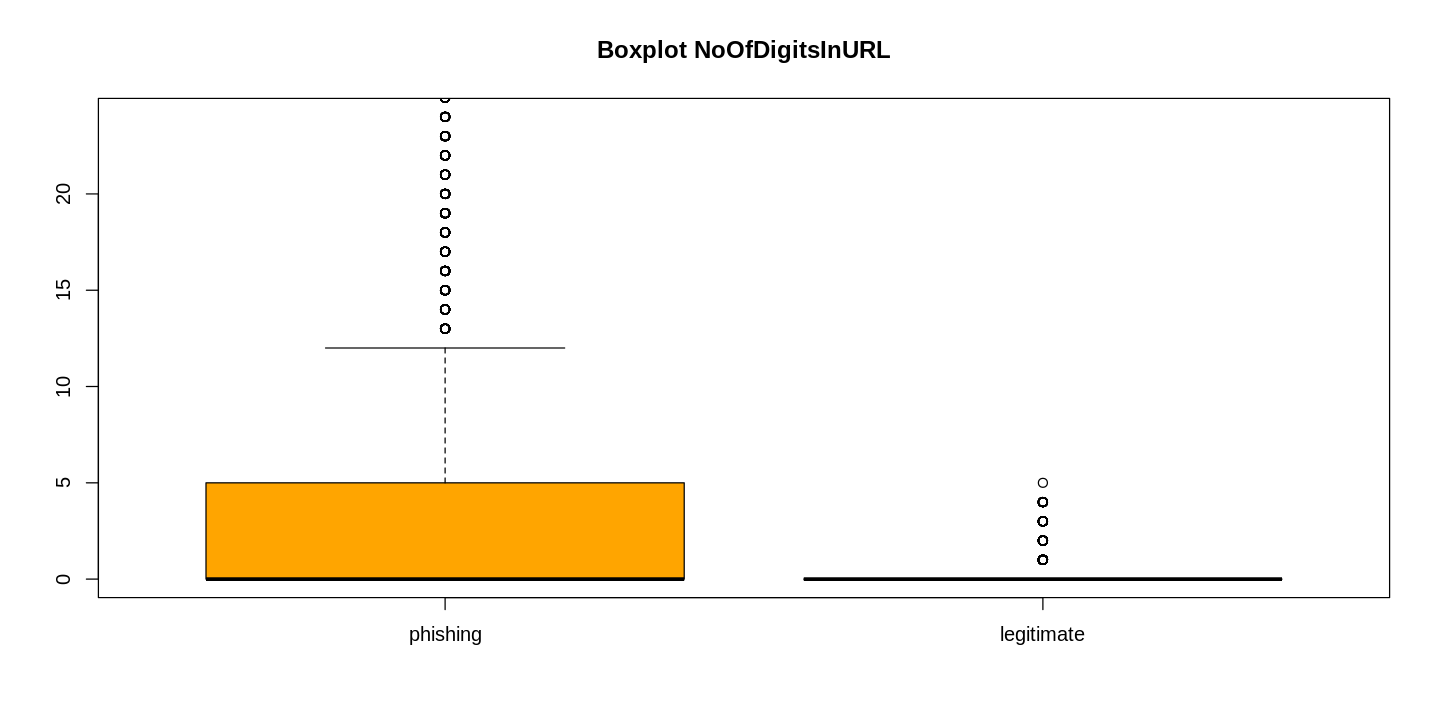

In [ ]:
boxplot(df_0$NoOfDegitsInURL, df_1$NoOfDegitsInURL,
        main = 'Boxplot NoOfDigitsInURL', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfDegitsInURL), quantile(df_0$NoOfDegitsInURL, 0.97)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfDegitsInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = -0.07820727 M2 = 0.07820727 
Overlap df_1: M1 = 0 M2 = 0 


#### Distribution form

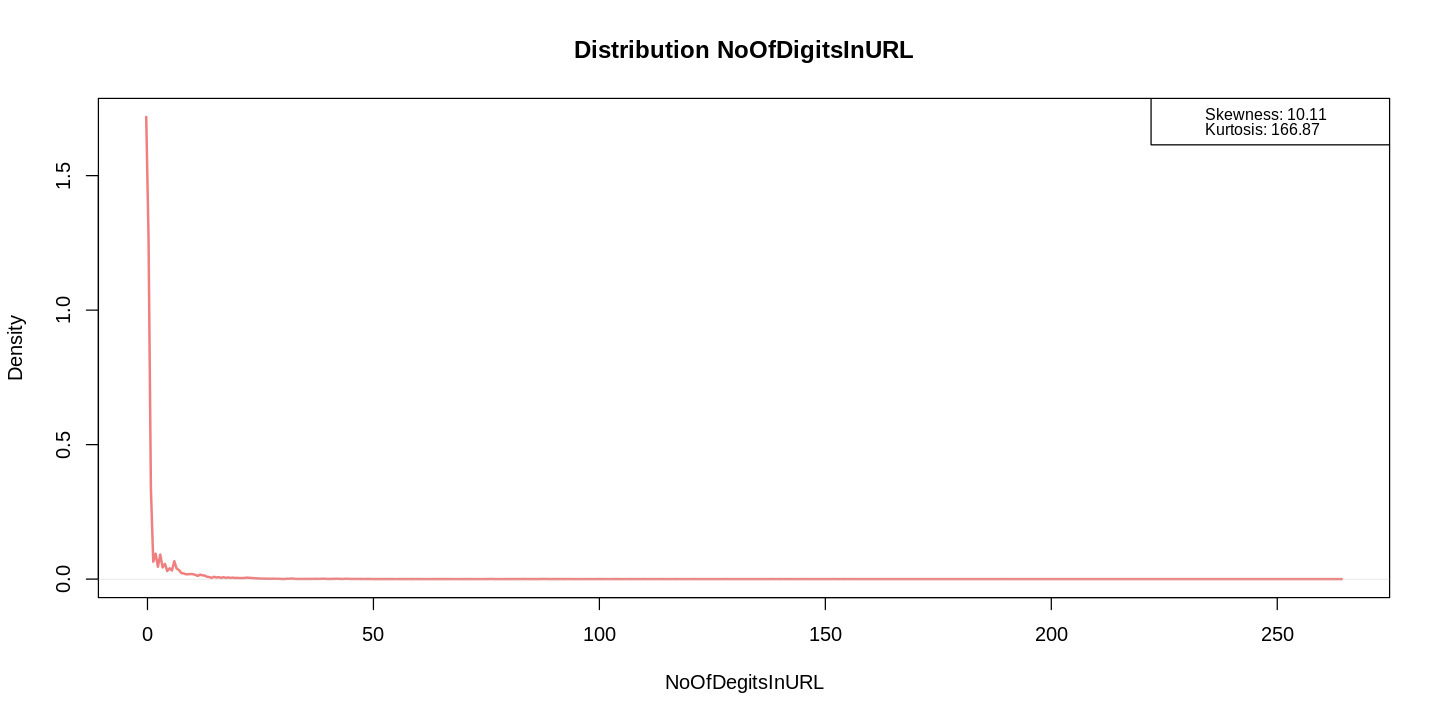

In [ ]:
skw_value <- skewness(df$NoOfDegitsInURL)
kurtosis_value <- kurtosis(df$NoOfDegitsInURL)

density <- density(df$NoOfDegitsInURL)

plot(density, main = "Distribution NoOfDigitsInURL",
     col = "lightcoral", lwd = 2, xlab = 'NoOfDegitsInURL')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

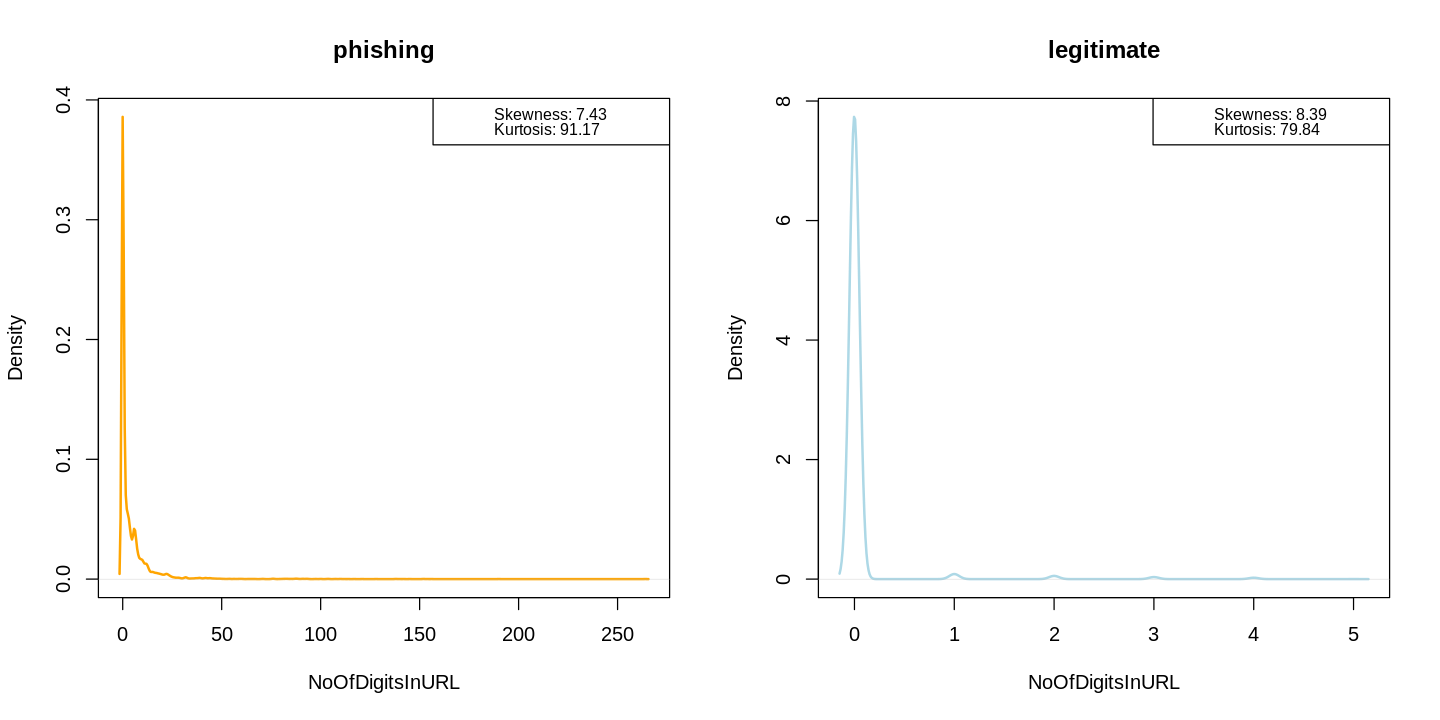

In [ ]:
skw_value_0 <- skewness(df_0$NoOfDegitsInURL)
kurtosis_value_0 <- kurtosis(df_0$NoOfDegitsInURL)

skw_value_1 <- skewness(df_1$NoOfDegitsInURL)
kurtosis_value_1 <- kurtosis(df_1$NoOfDegitsInURL)

density_0 <- density(df_0$NoOfDegitsInURL)
density_1 <- density(df_1$NoOfDegitsInURL)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "NoOfDigitsInURL", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "NoOfDigitsInURL", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfDegitsInURL, df$label)
spearman <- cor(df$NoOfDegitsInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.27061
Spearman: 	 -0.532599

### 22. Feature **DegitRatioInURL**

Delete this feature because has:
* lower variance tending 0 than **NoOfDegitsInURL**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$DegitRatioInURL)

cat('\nvar: ', var(df$DegitRatioInURL), '\n')
cat('std: ', sd(df$DegitRatioInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.0336  0.0220  0.6590 


var:  0.005716723 
std:  0.07560902

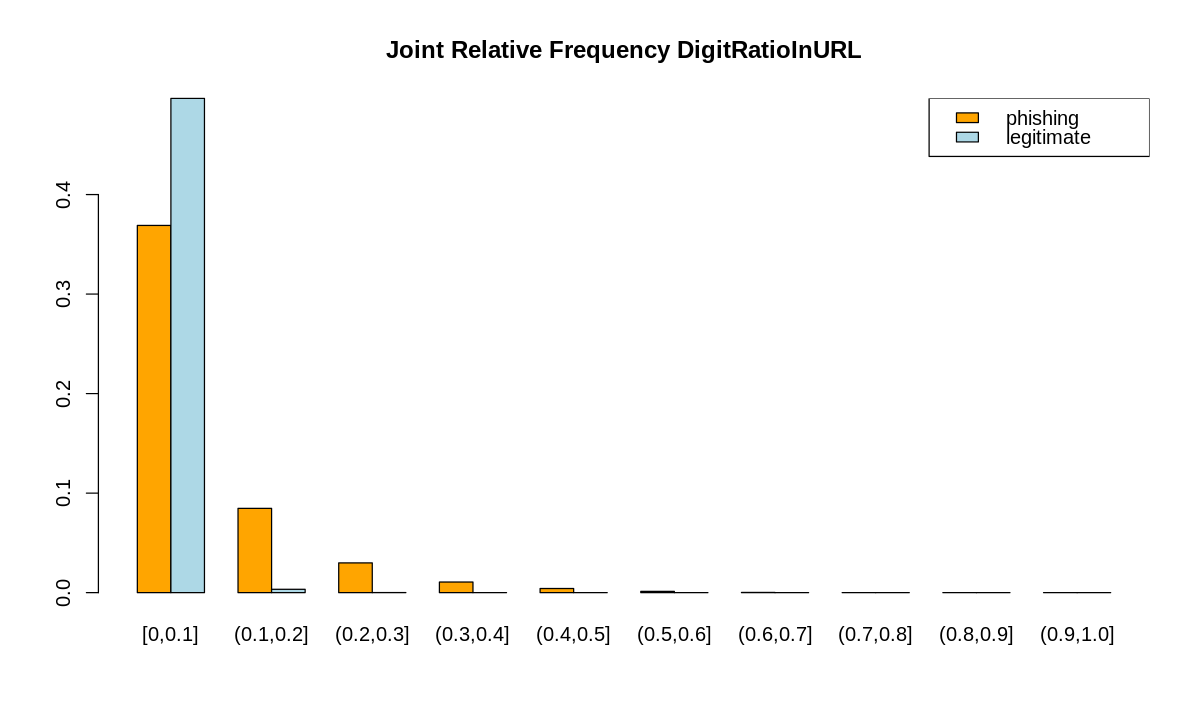

In [ ]:
# distribution
breaks <- c(-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

labels <- c("[0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
            "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]")

j_freq <- table(df$label, cut(df$DegitRatioInURL, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency DigitRatioInURL", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$DegitRatioInURL)
summary(df_1$DegitRatioInURL)

outliers <- count_outliers(df, "DegitRatioInURL")
outliers_0 <- count_outliers(df_0, "DegitRatioInURL")
outliers_1 <- count_outliers(df_1, "DegitRatioInURL")

cat('\nn. outliers DegitRatioInURL: \t\t', outliers)
cat('\nn. outliers DegitRatioInURL (0): \t', outliers_0)
cat('\nn. outliers DegitRatioInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.0652  0.1060  0.6590 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.002006 0.000000 0.211000 


n. outliers DegitRatioInURL: 		 4014
n. outliers DegitRatioInURL (0): 	 557
n. outliers DegitRatioInURL (1): 	 248

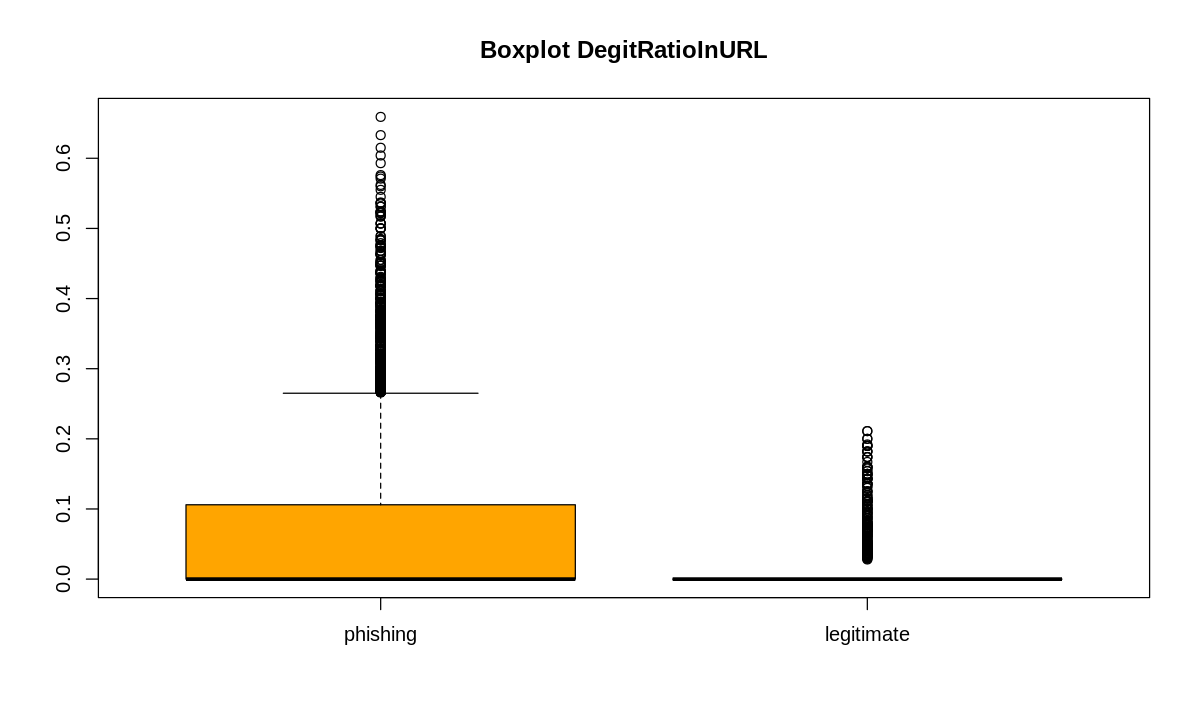

In [ ]:
boxplot(df_0$DegitRatioInURL, df_1$DegitRatioInURL,
        main = 'Boxplot DegitRatioInURL', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "DegitRatioInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = -0.001657994 M2 = 0.001657994 
Overlap df_1: M1 = 0 M2 = 0 


#### Correlation with label

In [ ]:
pearson <- cor(df$DegitRatioInURL, df$label)
spearman <- cor(df$DegitRatioInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.4178961
Spearman: 	 -0.5283544

#### Correlation with similar feature **NoOfDegitsInURL**

In [ ]:
pearson <- cor(df$DegitRatioInURL, df$NoOfDegitsInURL)
spearman <- cor(df$DegitRatioInURL, df$NoOfDegitsInURL, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.6611196
Spearman: 	 0.9951636

In [ ]:
df <- subset(df, select = -DegitRatioInURL)

### 23. Feature **NoOfEqualsInURL**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfEqualsInURL)

cat('\nvar: ', var(df$NoOfEqualsInURL), '\n')
cat('std: ', sd(df$NoOfEqualsInURL))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00000  0.00000  0.00000  0.07299  0.00000 15.00000 


var:  0.3610376 
std:  0.600864

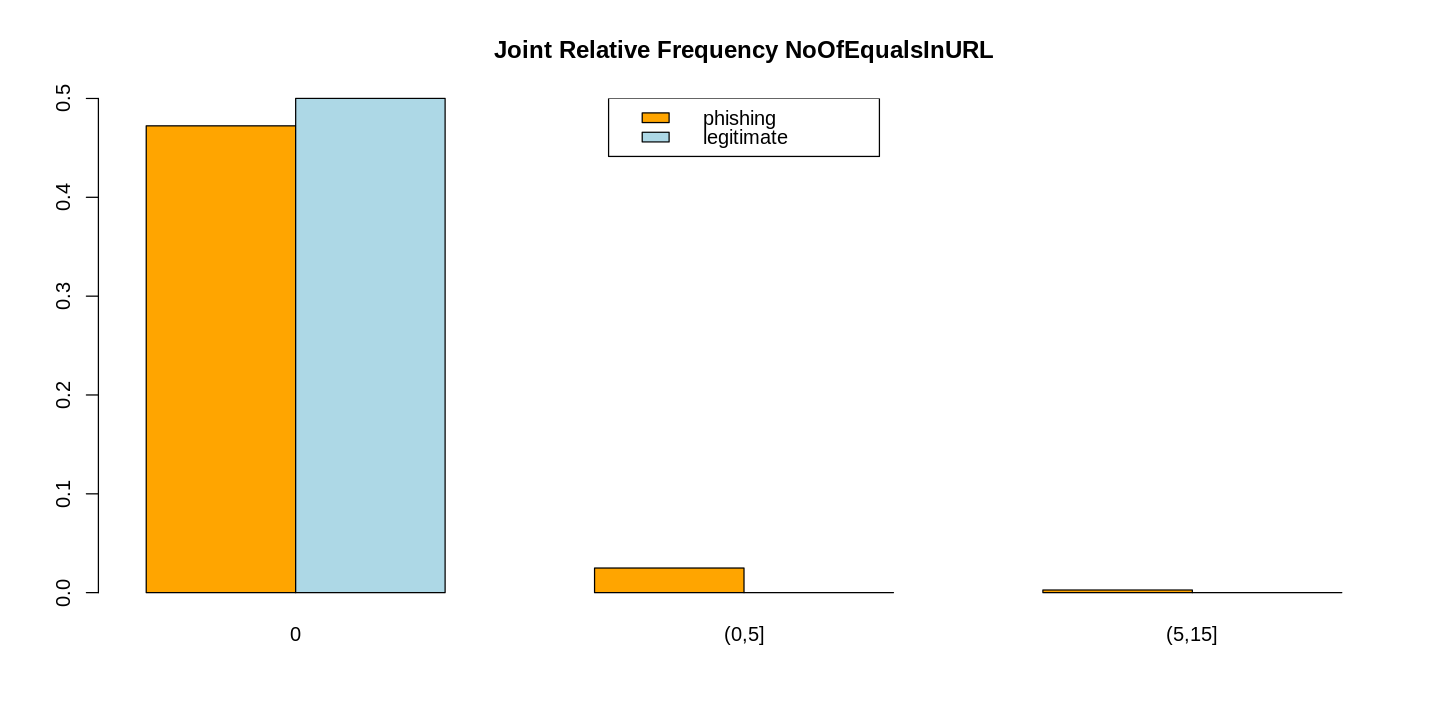

In [ ]:
breaks <- c(-1, 0, 5, 15)

labels <- c("0", "(0,5]", "(5,15]")

j_freq <- table(df$label, cut(df$NoOfEqualsInURL, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfEqualsInURL", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfEqualsInURL)
summary(df_1$NoOfEqualsInURL)

outliers <- count_outliers(df, "NoOfEqualsInURL")
outliers_0 <- count_outliers(df_0, "NoOfEqualsInURL")
outliers_1 <- count_outliers(df_1, "NoOfEqualsInURL")

cat('\nn. outliers NoOfEqualsInURL: \t\t', outliers)
cat('\nn. outliers NoOfEqualsInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfEqualsInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.146   0.000  15.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


n. outliers NoOfEqualsInURL: 		 556
n. outliers NoOfEqualsInURL (0): 	 556
n. outliers NoOfEqualsInURL (1): 	 0

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfEqualsInURL, df$label)
spearman <- cor(df$NoOfEqualsInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.1214989
Spearman: 	 -0.1684451

### 24. Feature **NoOfQMarkInURL**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfQMarkInURL)

cat('\nvar: ', var(df$NoOfQMarkInURL), '\n')
cat('std: ', sd(df$NoOfQMarkInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.03726 0.00000 3.00000 


var:  0.04947469 
std:  0.2224291

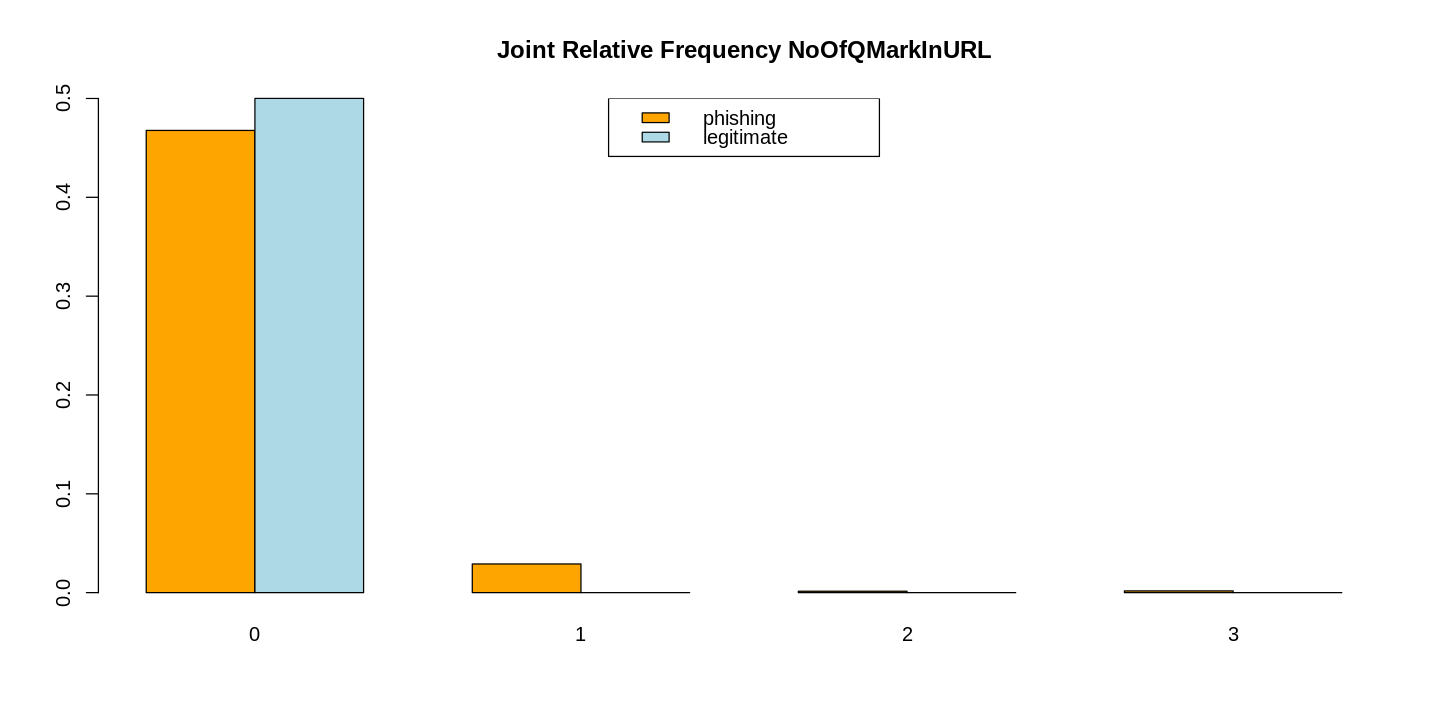

In [ ]:
j_freq <- table(df$label, df$NoOfQMarkInURL)

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfQMarkInURL", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfQMarkInURL)
summary(df_1$NoOfQMarkInURL)

outliers <- count_outliers(df, "NoOfQMarkInURL")
outliers_0 <- count_outliers(df_0, "NoOfQMarkInURL")
outliers_1 <- count_outliers(df_1, "NoOfQMarkInURL")

cat('\nn. outliers NoOfQMarkInURL: \t\t', outliers)
cat('\nn. outliers NoOfQMarkInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfQMarkInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.07454 0.00000 3.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


n. outliers NoOfQMarkInURL: 		 650
n. outliers NoOfQMarkInURL (0): 	 650
n. outliers NoOfQMarkInURL (1): 	 0

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfQMarkInURL, df$label)
spearman <- cor(df$NoOfQMarkInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.1675653
Spearman: 	 -0.1825785

### 25. Feature **NoOfAmpersandInURL**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfAmpersandInURL)

cat('\nvar: ', var(df$NoOfAmpersandInURL), '\n')
cat('std: ', sd(df$NoOfAmpersandInURL))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00000  0.00000  0.00000  0.02446  0.00000 20.00000 


var:  0.2619561 
std:  0.5118165

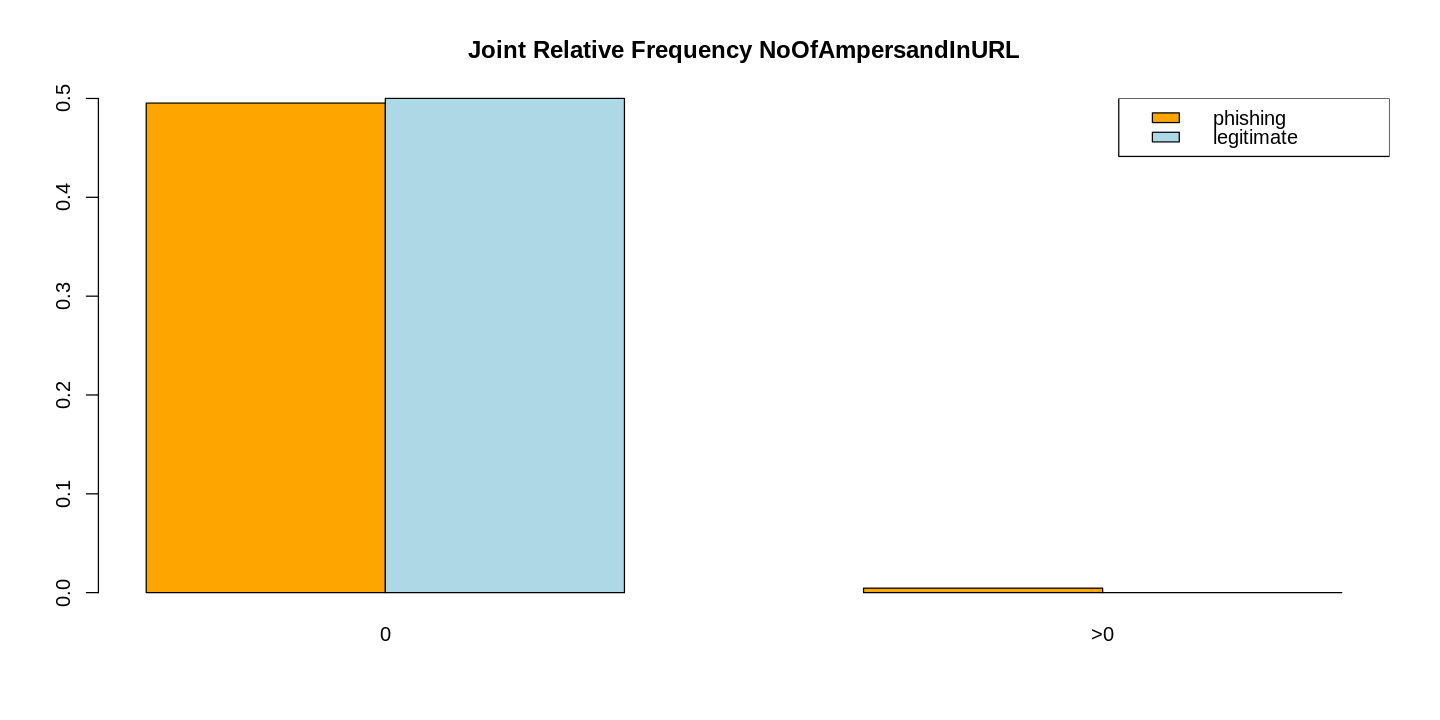

In [ ]:
j_freq <- t(table(NoOfAmpersandInURL = ifelse(df$NoOfAmpersandInURL == 0, "0", ">0"),
                label = df$label))

j_freq_rel <- prop.table(j_freq)

j_freq_rel <- j_freq_rel[, rev(colnames(j_freq))]

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfAmpersandInURL", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfAmpersandInURL)
summary(df_1$NoOfAmpersandInURL)

outliers <- count_outliers(df, "NoOfAmpersandInURL")
outliers_0 <- count_outliers(df_0, "NoOfAmpersandInURL")
outliers_1 <- count_outliers(df_1, "NoOfAmpersandInURL")

cat('\nn. outliers NoOfAmpersandInURL: \t', outliers)
cat('\nn. outliers NoOfAmpersandInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfAmpersandInURL (1): \t', outliers_1)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00000  0.00000  0.00000  0.04893  0.00000 20.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


n. outliers NoOfAmpersandInURL: 	 92
n. outliers NoOfAmpersandInURL (0): 	 92
n. outliers NoOfAmpersandInURL (1): 	 0

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfAmpersandInURL, df$label)
spearman <- cor(df$NoOfAmpersandInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.04780445
Spearman: 	 -0.06772996

### 26. Feature **NoOfOtherSpecialCharsInURL**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfOtherSpecialCharsInURL)

cat('\nvar: ', var(df$NoOfOtherSpecialCharsInURL), '\n')
cat('std: ', sd(df$NoOfOtherSpecialCharsInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   2.582   3.000 112.000 


var:  9.952581 
std:  3.154771

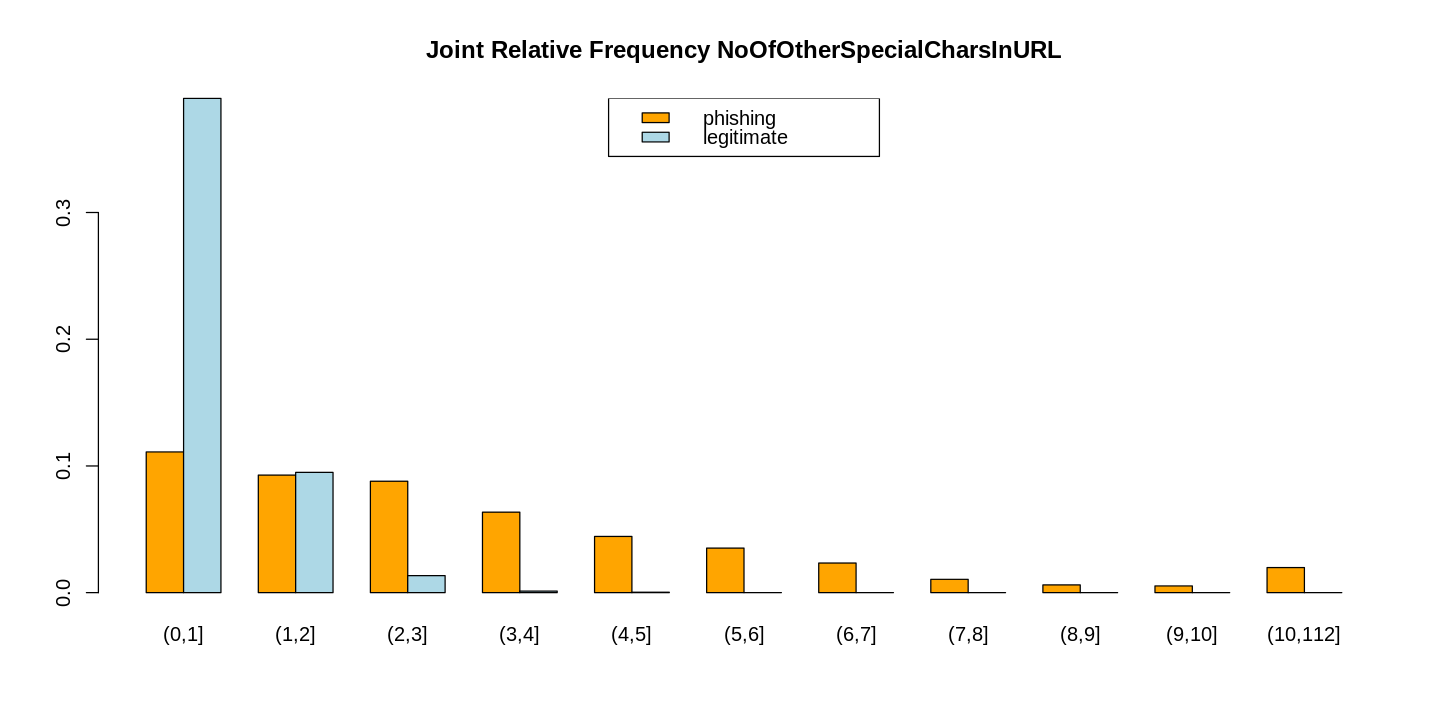

In [ ]:
breaks <- c(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 115)

labels <- c("(0,1]", "(1,2]", "(2,3]", "(3,4]", "(4,5]", "(5,6]",
            "(6,7]", "(7,8]", "(8,9]", "(9,10]", "(10,112]")

j_freq <- table(df$label, cut(df$NoOfOtherSpecialCharsInURL, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfOtherSpecialCharsInURL", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfOtherSpecialCharsInURL)
summary(df_1$NoOfOtherSpecialCharsInURL)

outliers <- count_outliers(df, "NoOfOtherSpecialCharsInURL")
outliers_0 <- count_outliers(df_0, "NoOfOtherSpecialCharsInURL")
outliers_1 <- count_outliers(df_1, "NoOfOtherSpecialCharsInURL")

cat('\nn. outliers NoOfOtherSpecialCharsInURL: \t', outliers)
cat('\nn. outliers NoOfOtherSpecialCharsInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfOtherSpecialCharsInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    3.00    3.91    5.00  112.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.254   1.000   6.000 


n. outliers NoOfOtherSpecialCharsInURL: 	 1312
n. outliers NoOfOtherSpecialCharsInURL (0): 	 506
n. outliers NoOfOtherSpecialCharsInURL (1): 	 2217

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfOtherSpecialCharsInURL, df$label)
spearman <- cor(df$NoOfOtherSpecialCharsInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.4209533
Spearman: 	 -0.6291471

### 27. Feature **NoOfSpecialCharsInURL**

Create a new feature that aggregate the values of:
- NoOfOtherSpecialCharsInURL
- NoOfAmpersandInURL
- NoOfQMarkInURL
- NoOfEqualsInURL

In [ ]:
df['NoOfSpecialCharsInURL'] <- df['NoOfOtherSpecialCharsInURL'] +
                               df['NoOfAmpersandInURL'] + df['NoOfQMarkInURL'] +
                               df['NoOfEqualsInURL']

df <- subset(df, select = -NoOfOtherSpecialCharsInURL)
df <- subset(df, select = -NoOfAmpersandInURL)
df <- subset(df, select = -NoOfQMarkInURL)
df <- subset(df, select = -NoOfEqualsInURL)

# reorder column
cols_order <- append(names(df), 'NoOfSpecialCharsInURL', after = 5)
df <- df[, cols_order]

df <- subset(df, select = -NoOfSpecialCharsInURL.1)

# update df_0 and df_1
df_0 <- df[df$label == 0, ]
df_1 <- df[df$label == 1, ]

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfSpecialCharsInURL)

cat('\nvar: ', var(df$NoOfSpecialCharsInURL), '\n')
cat('std: ', sd(df$NoOfSpecialCharsInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   2.717   3.000 121.000 


var:  15.46342 
std:  3.932356

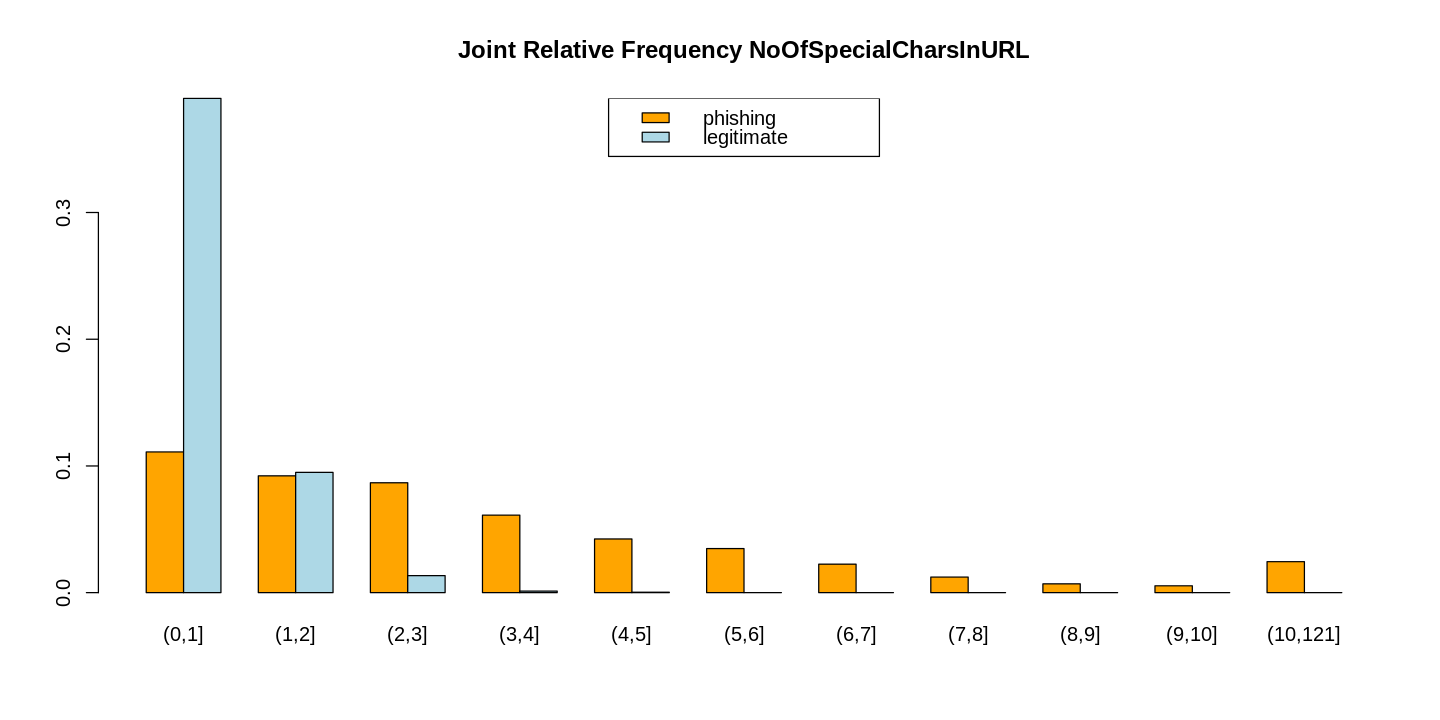

In [ ]:
breaks <- c(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 122)

labels <- c("(0,1]", "(1,2]", "(2,3]", "(3,4]", "(4,5]", "(5,6]",
            "(6,7]", "(7,8]", "(8,9]", "(9,10]", "(10,121]")

j_freq <- table(df$label, cut(df$NoOfSpecialCharsInURL, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfSpecialCharsInURL", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfSpecialCharsInURL)
summary(df_1$NoOfSpecialCharsInURL)

outliers <- count_outliers(df, "NoOfSpecialCharsInURL")
outliers_0 <- count_outliers(df_0, "NoOfSpecialCharsInURL")
outliers_1 <- count_outliers(df_1, "NoOfSpecialCharsInURL")

cat('\nn. outliers NoOfSpecialCharsInURL: \t', outliers)
cat('\nn. outliers NoOfSpecialCharsInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfSpecialCharsInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    3.00    4.18    5.00  121.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.254   1.000   6.000 


n. outliers NoOfSpecialCharsInURL: 	 1443
n. outliers NoOfSpecialCharsInURL (0): 	 602
n. outliers NoOfSpecialCharsInURL (1): 	 2217

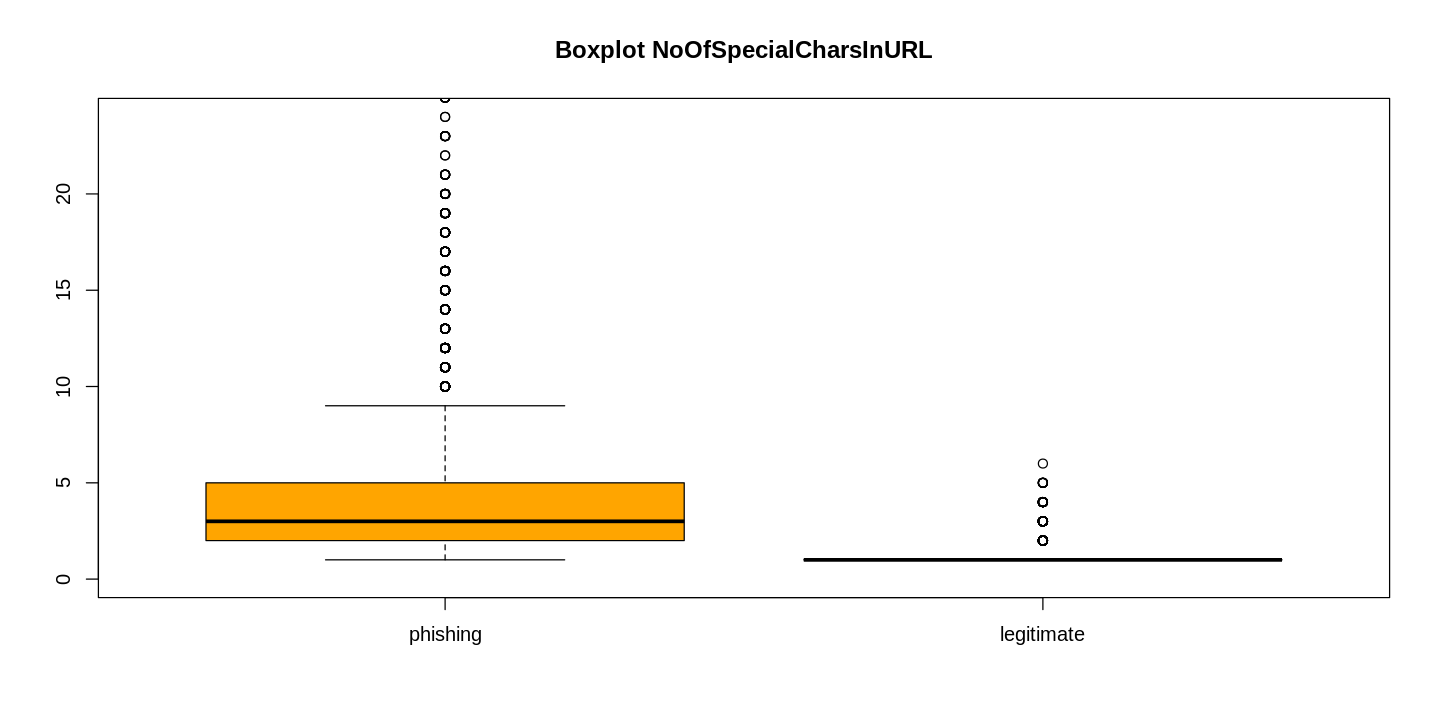

In [ ]:
boxplot(df_0$NoOfSpecialCharsInURL, df_1$NoOfSpecialCharsInURL,
        main = 'Boxplot NoOfSpecialCharsInURL', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfDegitsInURL), quantile(df_0$NoOfDegitsInURL, 0.97)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfSpecialCharsInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 2.953076 M2 = 3.046924 
Overlap df_1: M1 = 1 M2 = 1 


#### Distribution form

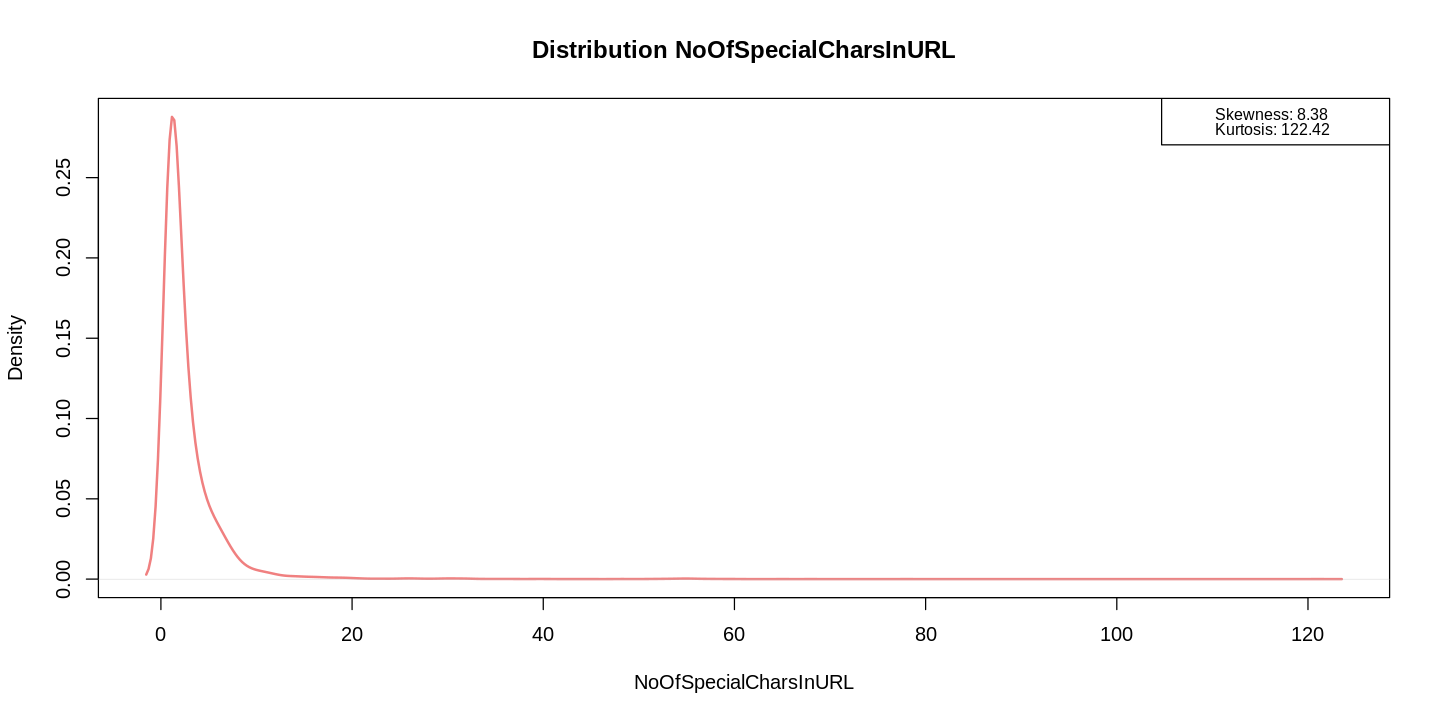

In [ ]:
skw_value <- skewness(df$NoOfSpecialCharsInURL)
kurtosis_value <- kurtosis(df$NoOfSpecialCharsInURL)

n <- length(df$NoOfSpecialCharsInURL)
h_sturges <- (max(df$NoOfSpecialCharsInURL) - min(df$NoOfSpecialCharsInURL)) / sqrt(n)
density <- density(df$NoOfSpecialCharsInURL, bw = h_sturges)

plot(density, main = "Distribution NoOfSpecialCharsInURL",
     col = "lightcoral", lwd = 2, xlab = 'NoOfSpecialCharsInURL')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

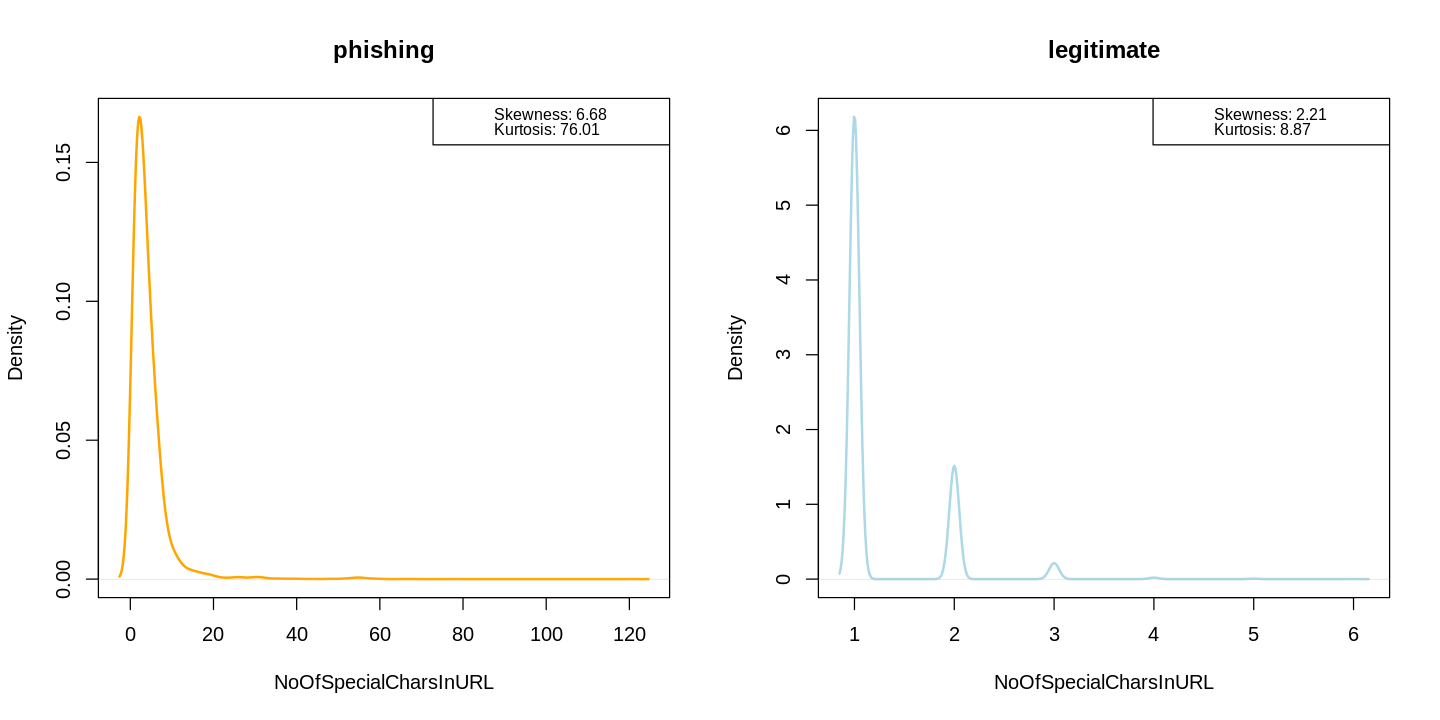

In [ ]:
skw_value_0 <- skewness(df_0$NoOfSpecialCharsInURL)
kurtosis_value_0 <- kurtosis(df_0$NoOfSpecialCharsInURL)

skw_value_1 <- skewness(df_1$NoOfSpecialCharsInURL)
kurtosis_value_1 <- kurtosis(df_1$NoOfSpecialCharsInURL)

n <- length(df_0$NoOfSpecialCharsInURL)
h_sturges <- (max(df_0$NoOfSpecialCharsInURL) - min(df_0$NoOfSpecialCharsInURL)) / sqrt(n)
density_0 <- density(df_0$NoOfSpecialCharsInURL, bw = h_sturges)

n <- length(df_1$NoOfSpecialCharsInURL)
h_sturges <- (max(df_1$NoOfSpecialCharsInURL) - min(df_1$NoOfSpecialCharsInURL)) / sqrt(n)
density_1 <- density(df_1$NoOfSpecialCharsInURL, bw = h_sturges)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "NoOfSpecialCharsInURL", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "NoOfSpecialCharsInURL", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfSpecialCharsInURL, df$label)
spearman <- cor(df$NoOfSpecialCharsInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.3719791
Spearman: 	 -0.6294684

### 28. Feature **SpecialCharRatioInUrl**

Delete this feature because has:
* lower variance tending 0 than **NoOfSpecialCharInUrl**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$SpacialCharRatioInURL)

cat('\nvar: ', var(df$SpacialCharRatioInURL), '\n')
cat('std: ', sd(df$SpacialCharRatioInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0130  0.0400  0.0530  0.0665  0.0880  0.2370 


var:  0.001127303 
std:  0.03357533

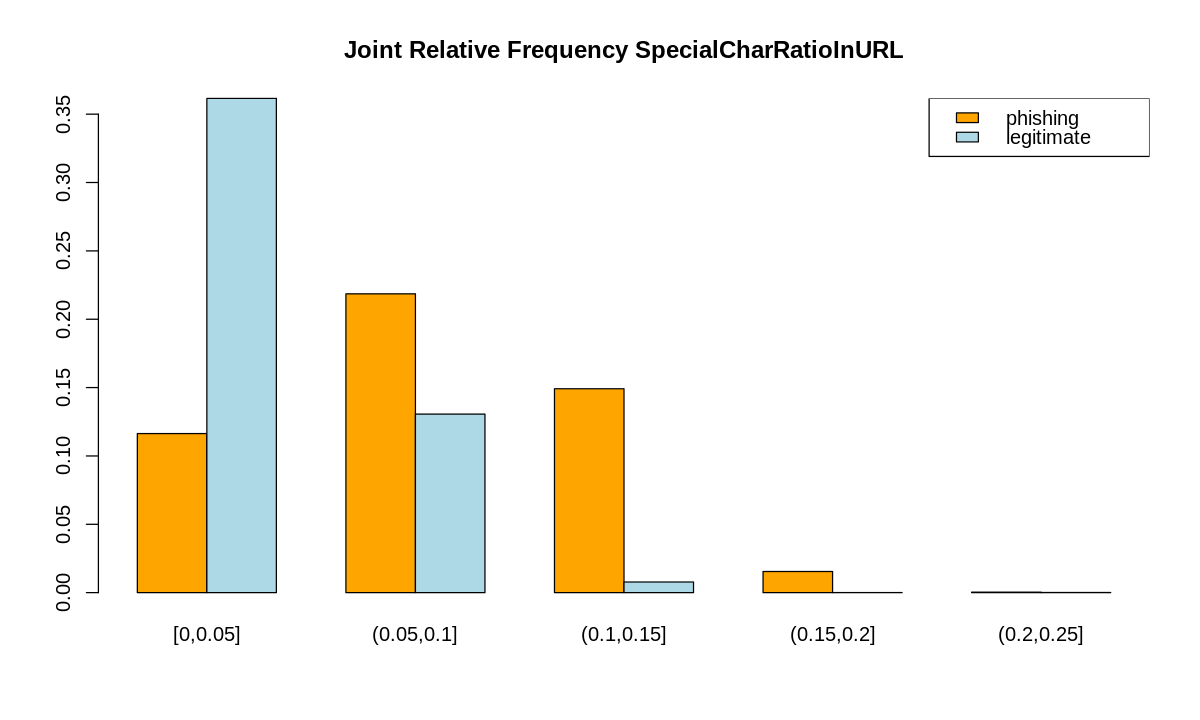

In [ ]:
# distribution
breaks = c(0, 0.05, 0.1, 0.15, 0.20, 0.25)

labels <- c("[0,0.05]", "(0.05,0.1]", "(0.1,0.15]", "(0.15,0.2]", "(0.2,0.25]")

j_freq <- table(df$label, cut(df$SpacialCharRatioInURL, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency SpecialCharRatioInURL", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$SpacialCharRatioInURL)
summary(df_1$SpacialCharRatioInURL)

outliers <- count_outliers(df, "SpacialCharRatioInURL")
outliers_0 <- count_outliers(df_0, "SpacialCharRatioInURL")
outliers_1 <- count_outliers(df_1, "SpacialCharRatioInURL")

cat('\nn. outliers SpacialCharRatioInURL: \t', outliers)
cat('\nn. outliers SpacialCharRatioInURL (0): \t', outliers_0)
cat('\nn. outliers SpacialCharRatioInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01300 0.05300 0.08100 0.08438 0.11100 0.23700 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02000 0.03600 0.04200 0.04863 0.05300 0.23100 


n. outliers SpacialCharRatioInURL: 	 214
n. outliers SpacialCharRatioInURL (0): 	 12
n. outliers SpacialCharRatioInURL (1): 	 1071

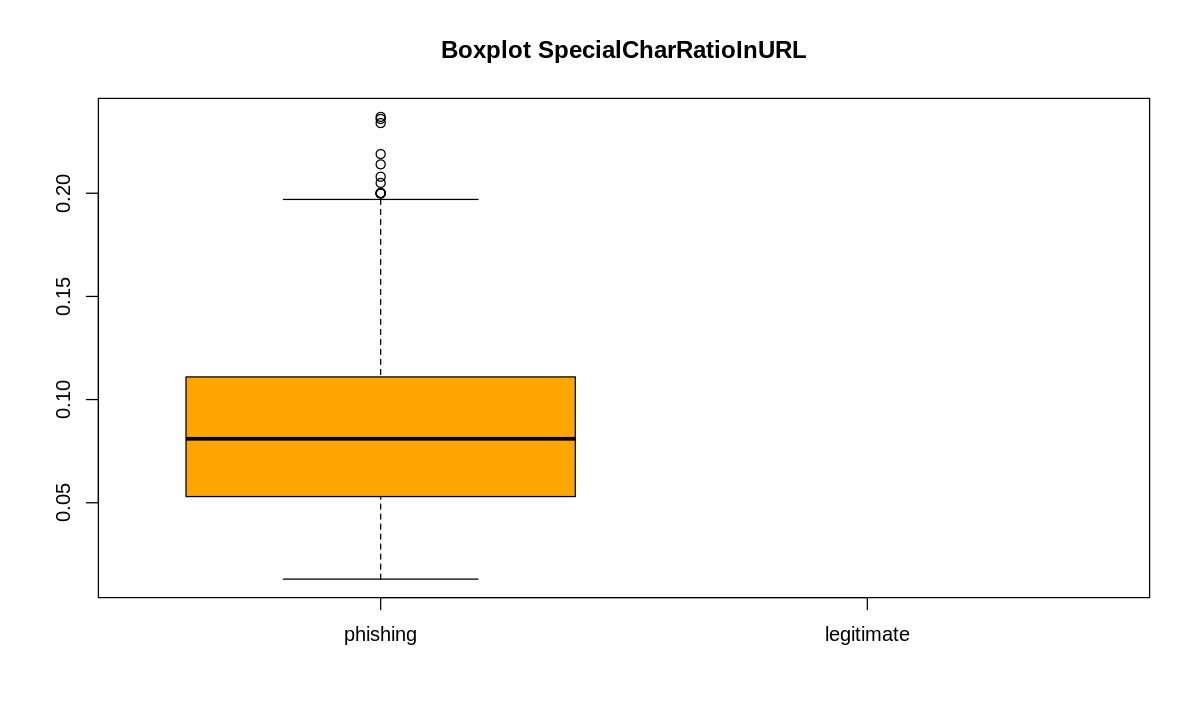

In [ ]:
boxplot(df_0$SpacialCharRatioInURL, df_1$DegitRatioInURL,
        main = 'Boxplot SpecialCharRatioInURL', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "SpacialCharRatioInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 0.0800928 M2 = 0.0819072 
Overlap df_1: M1 = 0.04173413 M2 = 0.04226587 


#### Correlation with label

In [ ]:
pearson <- cor(df$SpacialCharRatioInURL, df$label)
spearman <- cor(df$SpacialCharRatioInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.5323635
Spearman: 	 -0.5453758

#### Correlation with similar feature **NoOfSpecialCharsInURL**

In [ ]:
pearson <- cor(df$SpacialCharRatioInURL, df$NoOfSpecialCharsInURL)
spearman <- cor(df$SpacialCharRatioInURL, df$NoOfSpecialCharsInURL, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5449379
Spearman: 	 0.8511461

In [ ]:
df <- subset(df, select = -SpacialCharRatioInURL)

### 29. Feature **IsHTTPS**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$IsHTTPS)

cat('\nvar: ', var(df$IsHTTPS), '\n')
cat('std: ', sd(df$IsHTTPS))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.7585  1.0000  1.0000 


var:  0.1831625 
std:  0.4279749

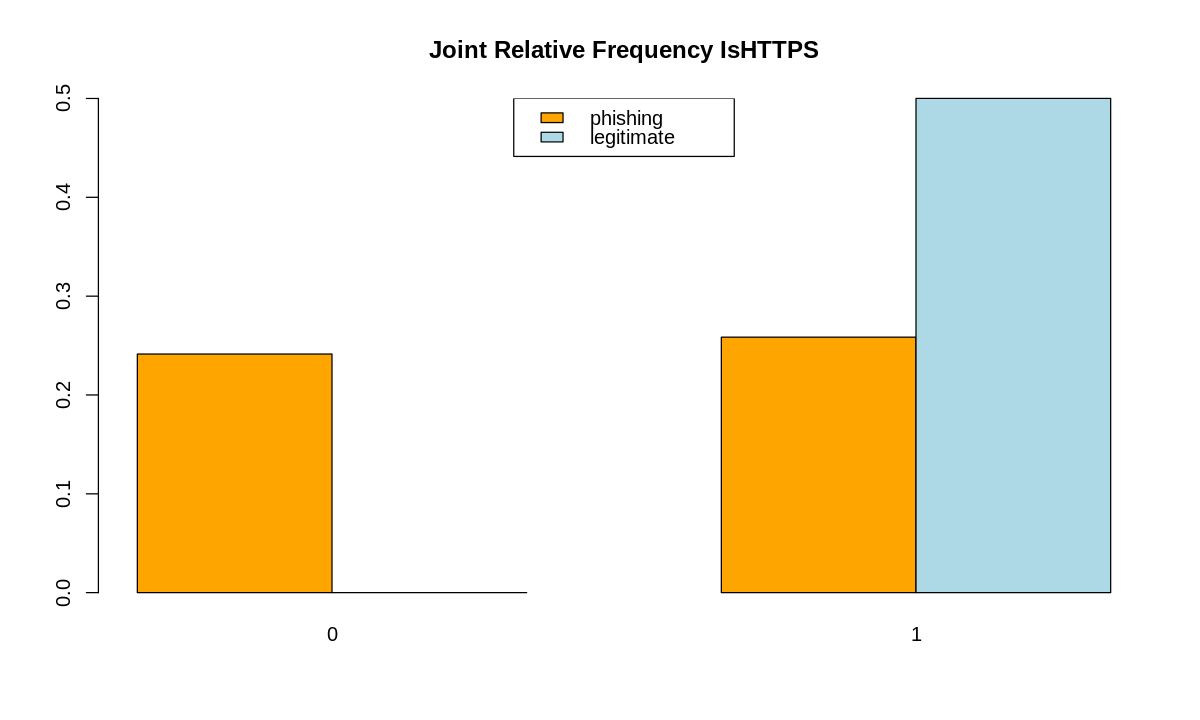

In [ ]:
j_freq <- table(df$label, df$IsHTTPS)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency IsHTTPS", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$IsHTTPS, df$label)
spearman <- cor(df$IsHTTPS, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5642734
Spearman: 	 0.5642734

### 30. Feature **LineOfCode**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$LineOfCode)

cat('\nvar: ', var(df$LineOfCode), '\n')
cat('std: ', sd(df$LineOfCode))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2      12     263    1021    1092  422798 


var:  16015766 
std:  4001.97

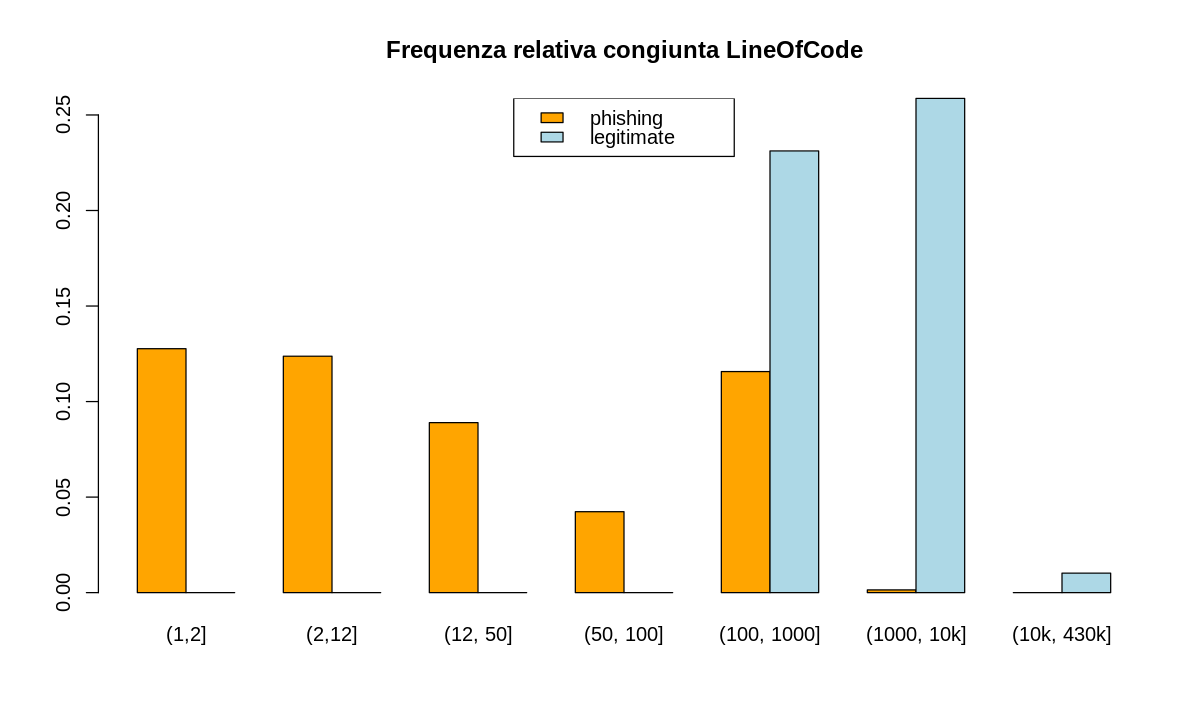

In [ ]:
breaks = c(0, 2, 12, 50, 100, 1000, 10000, 430000)

labels = c("(1,2]", "(2,12]", "(12, 50]", "(50, 100]", "(100, 1000]",
           "(1000, 10k]", "(10k, 430k]")

j_freq <- table(df$label, cut(df$LineOfCode, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Frequenza relativa congiunta LineOfCode", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$LineOfCode)
summary(df_1$LineOfCode)

outliers <- count_outliers(df, "LineOfCode")
outliers_0 <- count_outliers(df_0, "LineOfCode")
outliers_1 <- count_outliers(df_1, "LineOfCode")

cat('\nn. outliers LineOfCode: \t', outliers)
cat('\nn. outliers LineOfCode (0): \t', outliers_0)
cat('\nn. outliers LineOfCode (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     2.0    12.0    65.1    90.0  3332.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    102     597    1087    1976    2083  422798 


n. outliers LineOfCode: 	 1810
n. outliers LineOfCode (0): 	 684
n. outliers LineOfCode (1): 	 908

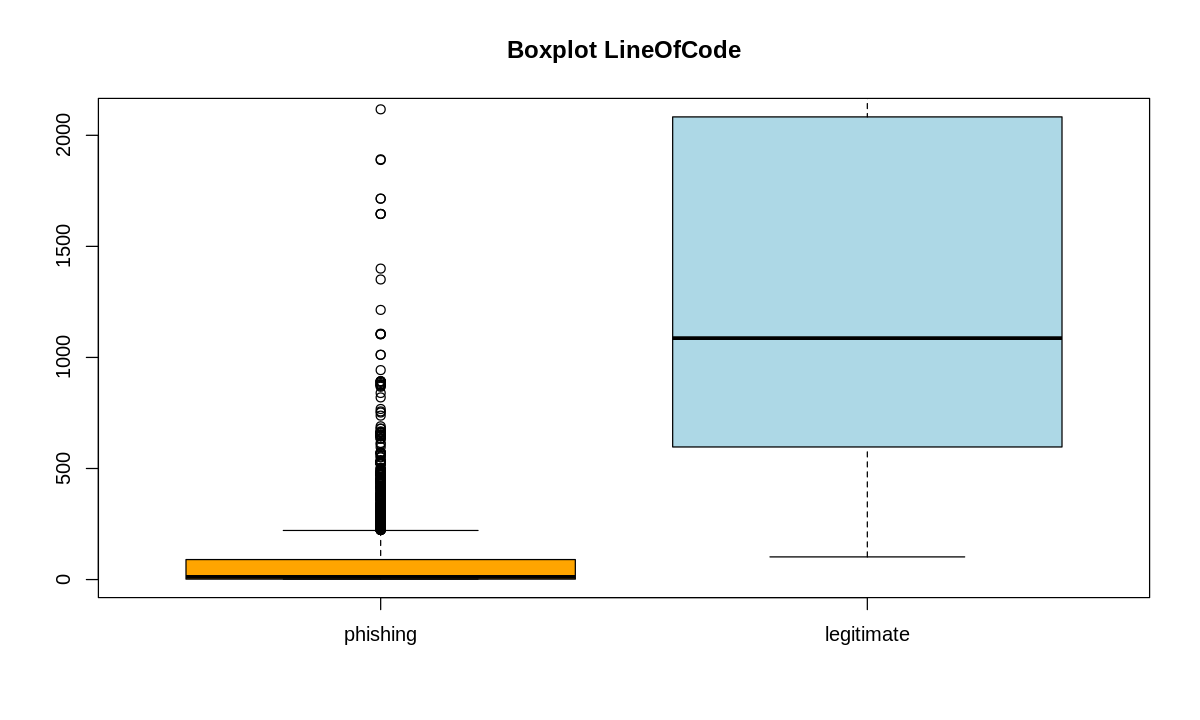

In [ ]:
boxplot(df_0$LineOfCode, df_1$LineOfCode,
        main = 'Boxplot LineOfCode', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$LineOfCode), quantile(df_1$LineOfCode, 0.75)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "LineOfCode")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 10.62355 M2 = 13.37645 
Overlap df_1: M1 = 1063.76 M2 = 1110.24 


#### Distribution Form

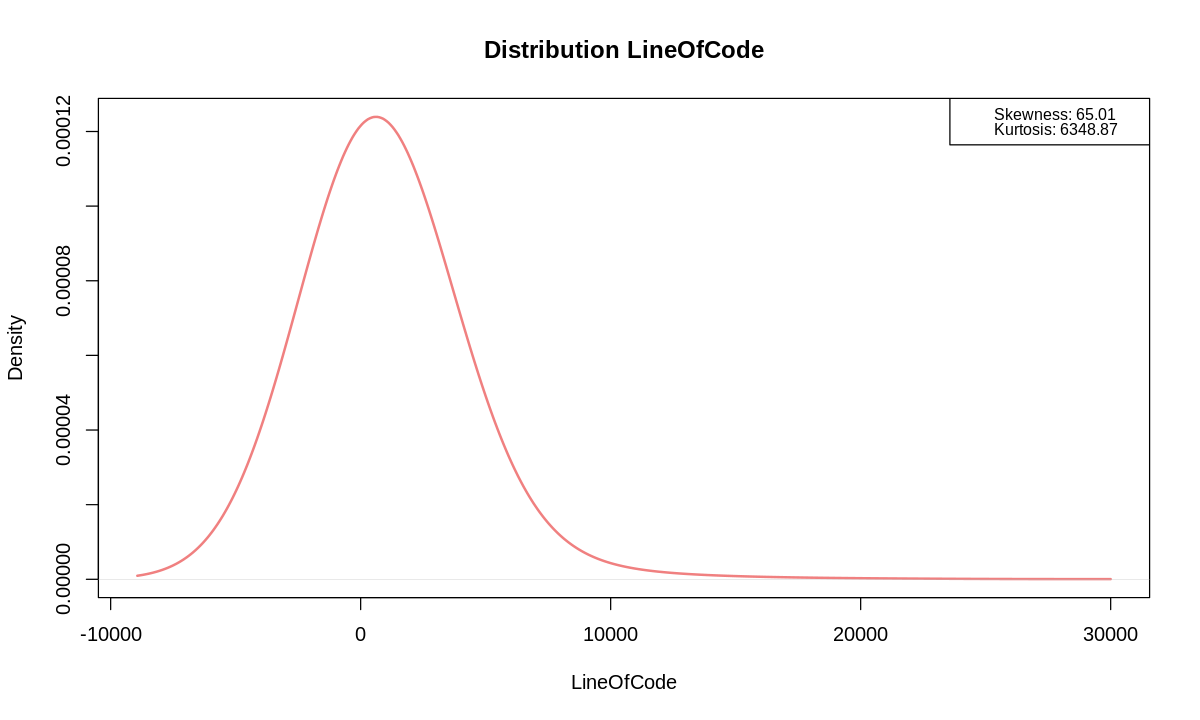

In [ ]:
skw_value <- skewness(df$LineOfCode)
kurtosis_value <- kurtosis(df$LineOfCode)

n <- length(df$LineOfCode)
h_sturges <- (max(df$LineOfCode) - min(df$LineOfCode)) / sqrt(n)
density <- density(df$LineOfCode, bw = h_sturges, to = 30000)

plot(density, main = "Distribution LineOfCode",
     col = "lightcoral", lwd = 2, xlab = 'LineOfCode')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

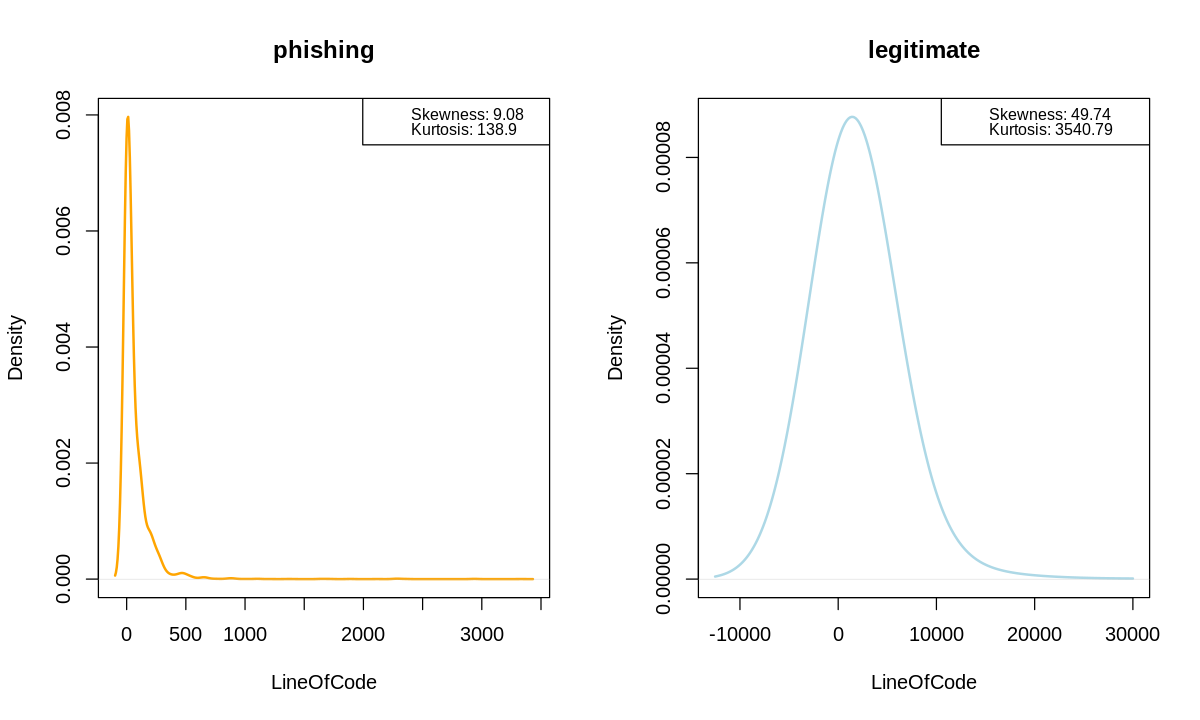

In [ ]:
skw_value_0 <- skewness(df_0$LineOfCode)
kurtosis_value_0 <- kurtosis(df_0$LineOfCode)

skw_value_1 <- skewness(df_1$LineOfCode)
kurtosis_value_1 <- kurtosis(df_1$LineOfCode)

n <- length(df_0$LineOfCode)
h_sturges <- (max(df_0$LineOfCode) - min(df_0$LineOfCode)) / sqrt(n)
density_0 <- density(df_0$LineOfCode, bw = h_sturges)

n <- length(df_1$LineOfCode)
h_sturges <- (max(df_1$LineOfCode) - min(df_1$LineOfCode)) / sqrt(n)
density_1 <- density(df_1$LineOfCode, bw = h_sturges, to=30000)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "LineOfCode", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "LineOfCode", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$LineOfCode, df$label)
spearman <- cor(df$LineOfCode, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.2388179
Spearman: 	 0.8495958

### 31. Feature **LargestLineLength**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$LargestLineLength)

cat('\nvar: ', var(df$LargestLineLength), '\n')
cat('std: ', sd(df$LargestLineLength))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
      23      140      869    14383     8047 12016074 


var:  26403760876 
std:  162492.3

#### Substitute value > 100k arbitrarily with 100k

In [ ]:
df$LargestLineLength[df$LargestLineLength > 100000] <- 100000

# update df_0 and df_1
df_0 <- df[df$label == 0, ]
df_1 <- df[df$label == 1, ]

# # dispersion
summary(df$LargestLineLength)

cat('\nvar: ', var(df$LargestLineLength), '\n')
cat('std: ', sd(df$LargestLineLength))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     23     140     869    6399    8047  100000 


var:  232342215 
std:  15242.78

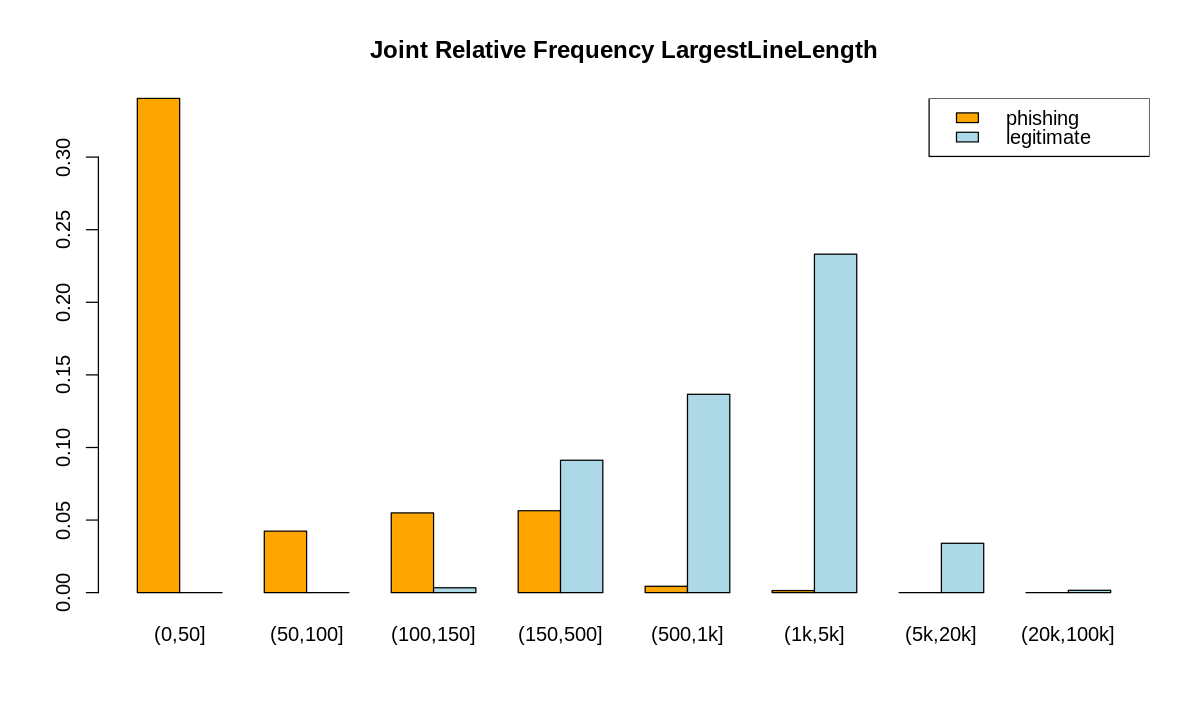

In [ ]:
breaks <- c(0, 50, 100, 150, 500, 1000, 5000, 20000, 100000)

labels <- c("(0,50]", "(50,100]", "(100,150]", "(150,500]",
            "(500,1k]", "(1k,5k]", "(5k,20k]", "(20k,100k]")

j_freq <- table(df$label, cut(df$LineOfCode, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency LargestLineLength", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$LargestLineLength)
summary(df_1$LargestLineLength)

outliers <- count_outliers(df, "LargestLineLength")
outliers_0 <- count_outliers(df_0, "LargestLineLength")
outliers_1 <- count_outliers(df_1, "LargestLineLength")

cat('\nn. outliers LargestLineLength: \t\t', outliers)
cat('\nn. outliers LargestLineLength (0): \t', outliers_0)
cat('\nn. outliers LargestLineLength (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     23      64     143    5707     869  100000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   106.0    882.2   3008.0   7090.3   9381.0 100000.0 


n. outliers LargestLineLength: 		 1460
n. outliers LargestLineLength (0): 	 2081
n. outliers LargestLineLength (1): 	 665

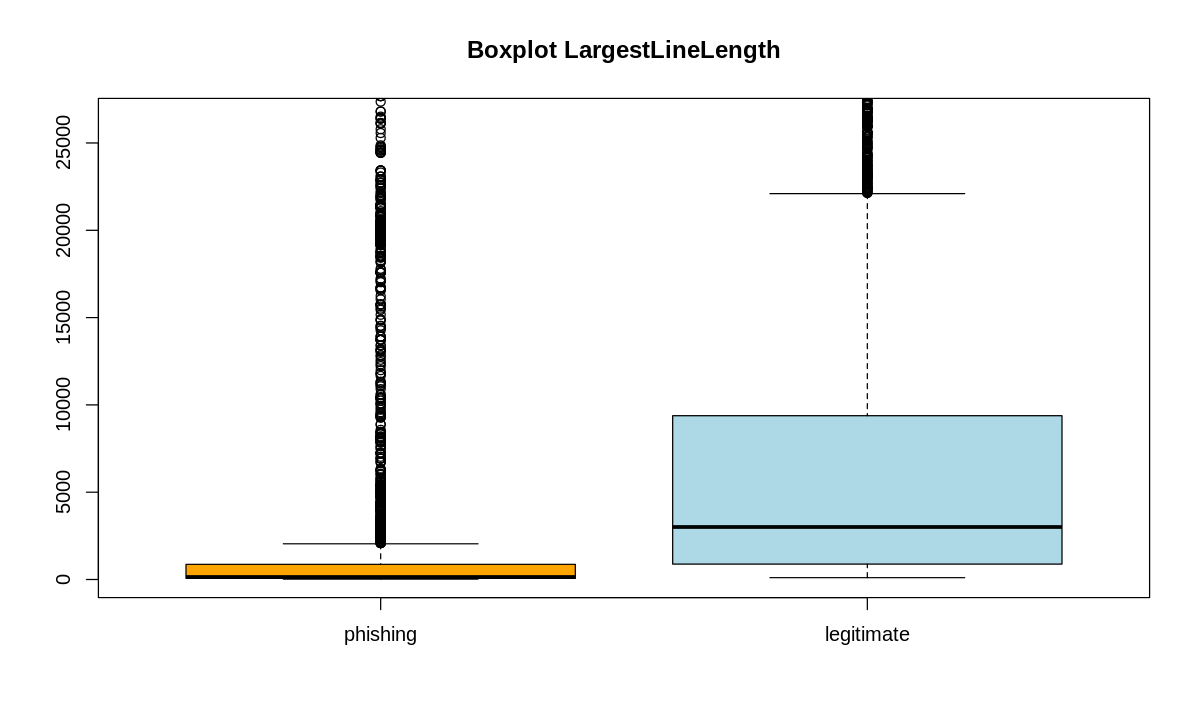

In [ ]:
boxplot(df_0$LargestLineLength, df_1$LargestLineLength,
        main = 'Boxplot LargestLineLength', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$LargestLineLength), quantile(df_1$LargestLineLength, 0.95)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "LargestLineLength")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 130.4086 M2 = 155.5914 
Overlap df_1: M1 = 2875.087 M2 = 3140.913 


#### Distribution Form

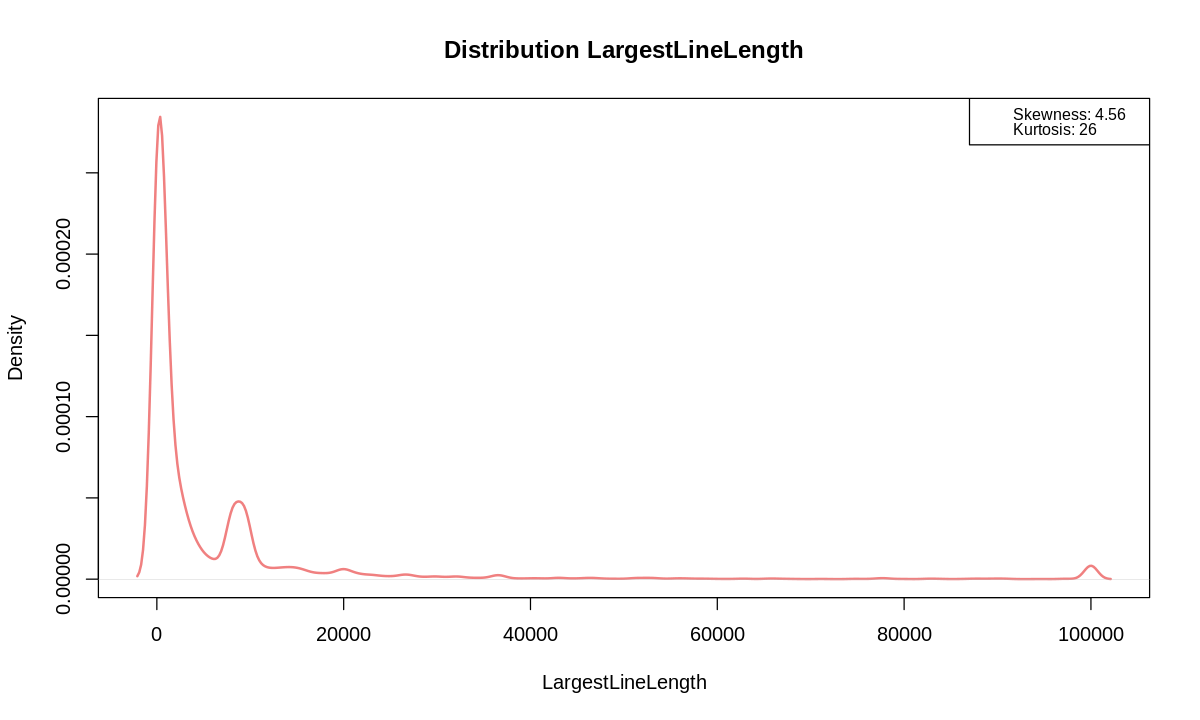

In [ ]:
skw_value <- skewness(df$LargestLineLength)
kurtosis_value <- kurtosis(df$LargestLineLength)

n <- length(df$LargestLineLength)
h_sturges <- (max(df$LargestLineLength) - min(df$LargestLineLength)) / sqrt(n)
density <- density(df$LargestLineLength, bw = h_sturges)

plot(density, main = "Distribution LargestLineLength",
     col = "lightcoral", lwd = 2, xlab = 'LargestLineLength')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

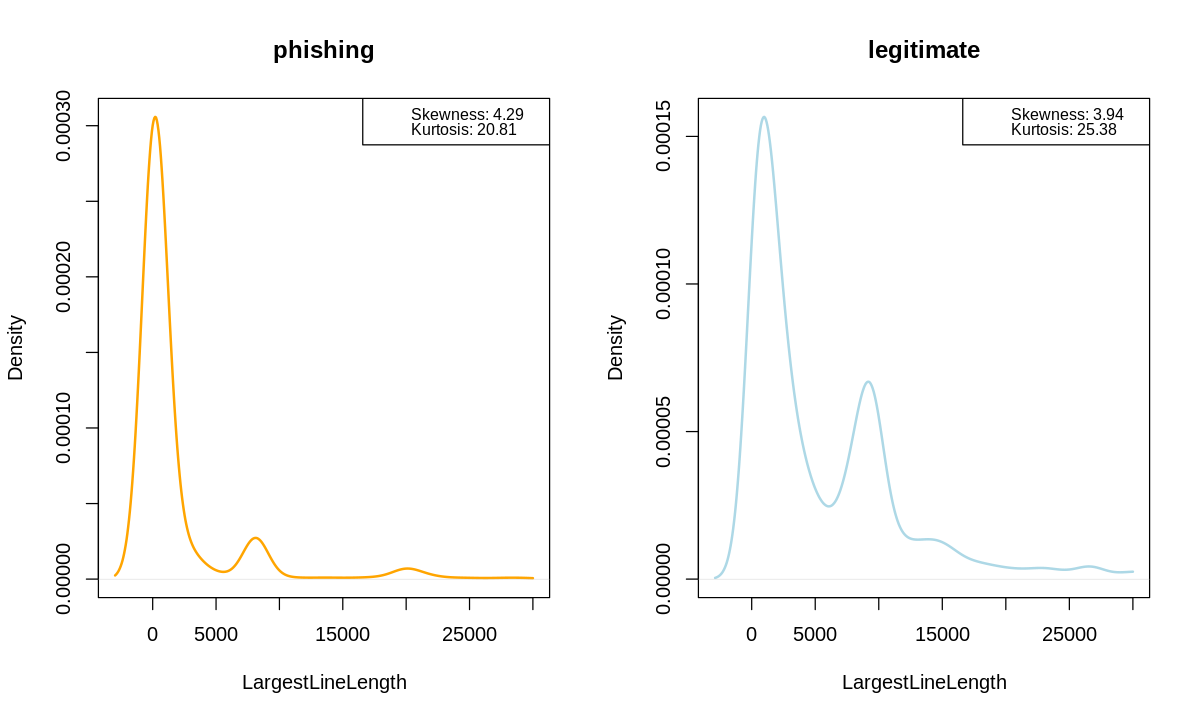

In [ ]:
skw_value_0 <- skewness(df_0$LargestLineLength)
kurtosis_value_0 <- kurtosis(df_0$LargestLineLength)

skw_value_1 <- skewness(df_1$LargestLineLength)
kurtosis_value_1 <- kurtosis(df_1$LargestLineLength)

n <- length(df_0$LargestLineLength)
h_sturges <- (max(df_0$LargestLineLength) - min(df_0$LargestLineLength)) / sqrt(n)
density_0 <- density(df_0$LargestLineLength, bw = h_sturges, to = 30000)

n <- length(df_1$LargestLineLength)
h_sturges <- (max(df_1$LargestLineLength) - min(df_1$LargestLineLength)) / sqrt(n)
density_1 <- density(df_1$LargestLineLength, bw = h_sturges, to = 30000)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "LargestLineLength", ylab = "Density",
     ylim = c(0, max(density_0$y)),
    )
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "LargestLineLength", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$LargestLineLength, df$label)
spearman <- cor(df$LargestLineLength, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.04538926
Spearman: 	 0.5390726

### 32. Feature **HasTitle**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasTitle)

cat('\nvar: ', var(df$HasTitle), '\n')
cat('std: ', sd(df$HasTitle))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.8415  1.0000  1.0000 


var:  0.1334098 
std:  0.365253

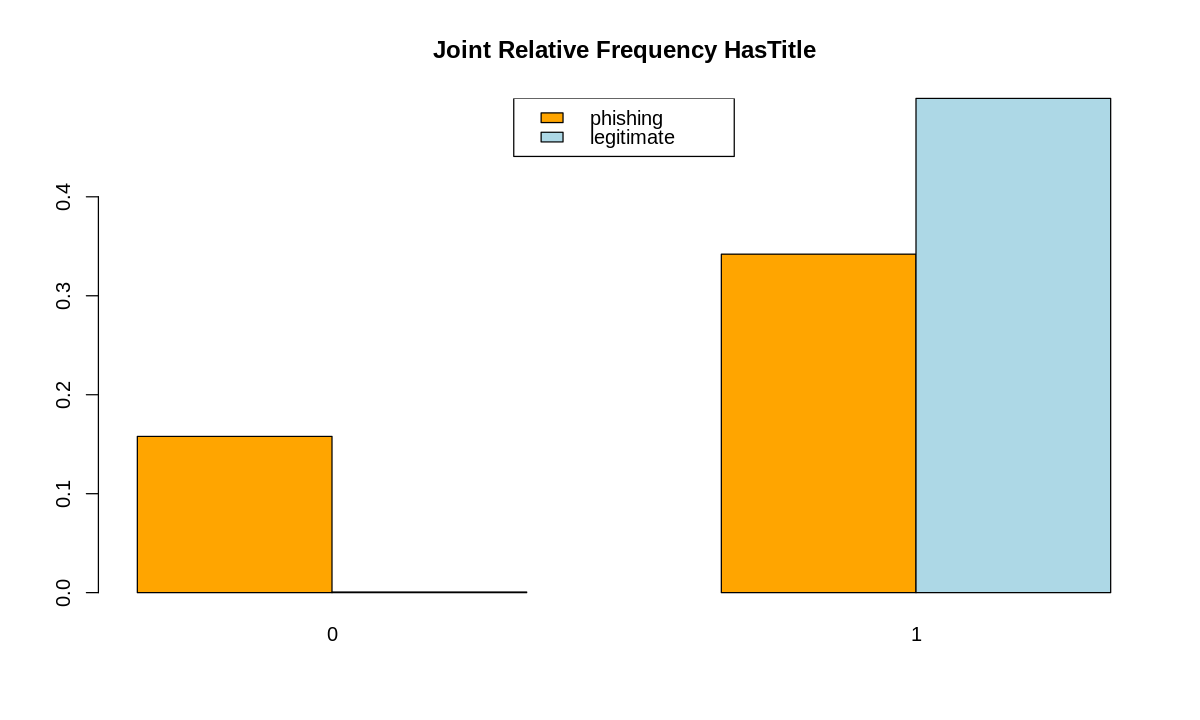

In [ ]:
j_freq <- table(df$label, df$HasTitle)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasTitle", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasTitle, df$label)
spearman <- cor(df$HasTitle, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.4305907
Spearman: 	 0.4305907

### 33. Feature **Title**

Delete this feature because has only unique value

In [ ]:
df <- subset(df, select = -Title)

### 34. Feature **Robots**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$Robots)

cat('\nvar: ', var(df$Robots), '\n')
cat('std: ', sd(df$Robots))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.2455  0.0000  1.0000 


var:  0.18525 
std:  0.4304068

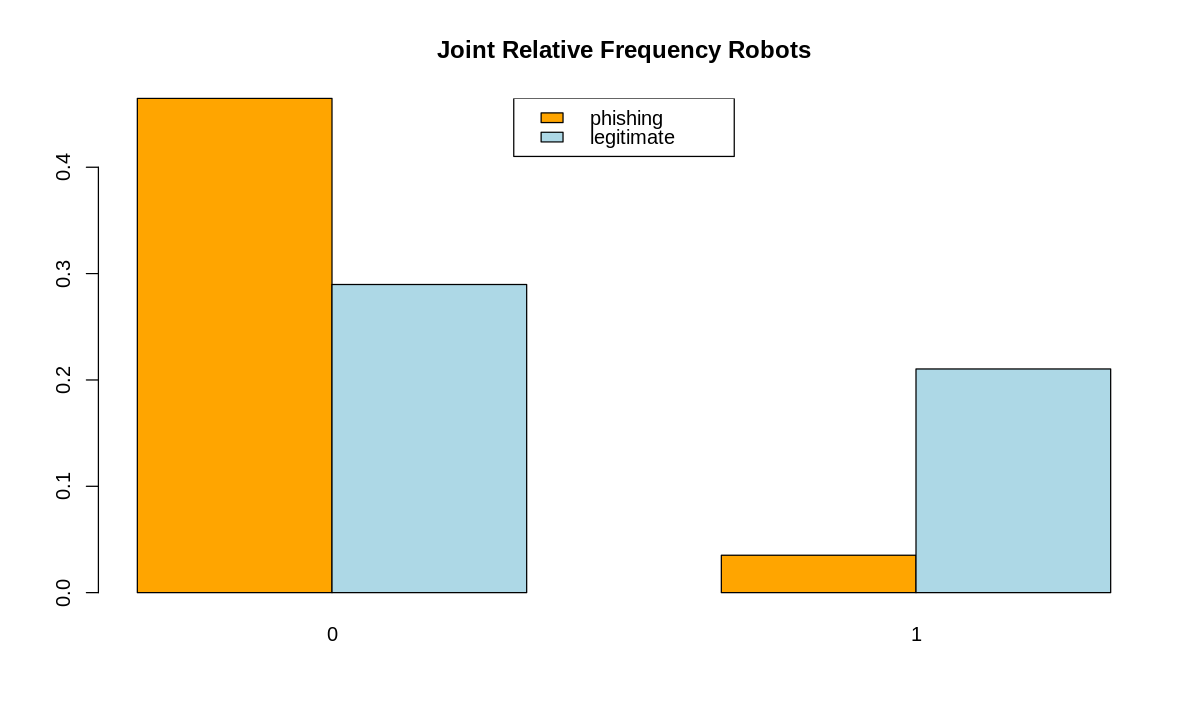

In [ ]:
j_freq <- table(df$label, df$Robots)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency Robots", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$Robots, df$label)
spearman <- cor(df$Robots, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.4068891
Spearman: 	 0.4068891

### 35. Feature **IsResponsive**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$IsResponsive)

cat('\nvar: ', var(df$IsResponsive), '\n')
cat('std: ', sd(df$IsResponsive))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.5845  1.0000  1.0000 


var:  0.2428754 
std:  0.4928239

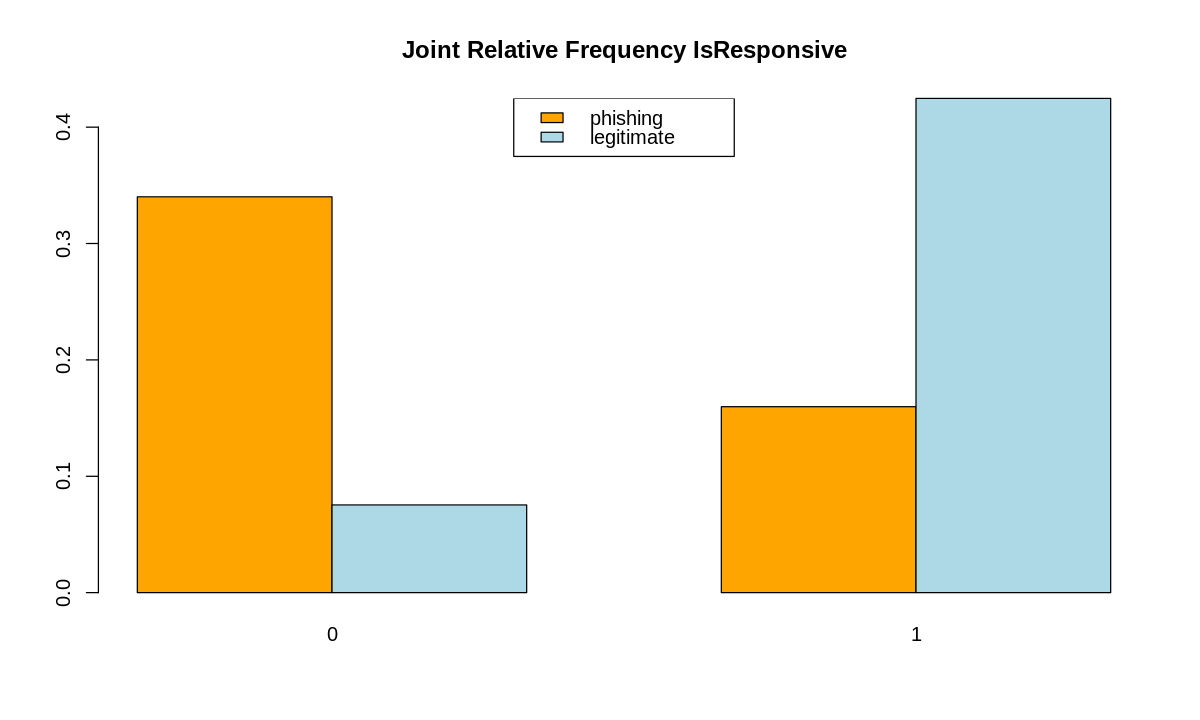

In [ ]:
j_freq <- table(df$label, df$IsResponsive)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency IsResponsive", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$IsResponsive, df$label)
spearman <- cor(df$IsResponsive, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5373987
Spearman: 	 0.5373987

### 36. Feature **NoOfURLRedirect**

Delete this feature because has:
* 95% of data is setting to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfURLRedirect)

cat('\nvar: ', var(df$NoOfURLRedirect), '\n')
cat('std: ', sd(df$NoOfURLRedirect))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.138   0.000   1.000 


var:  0.1189578 
std:  0.3449026

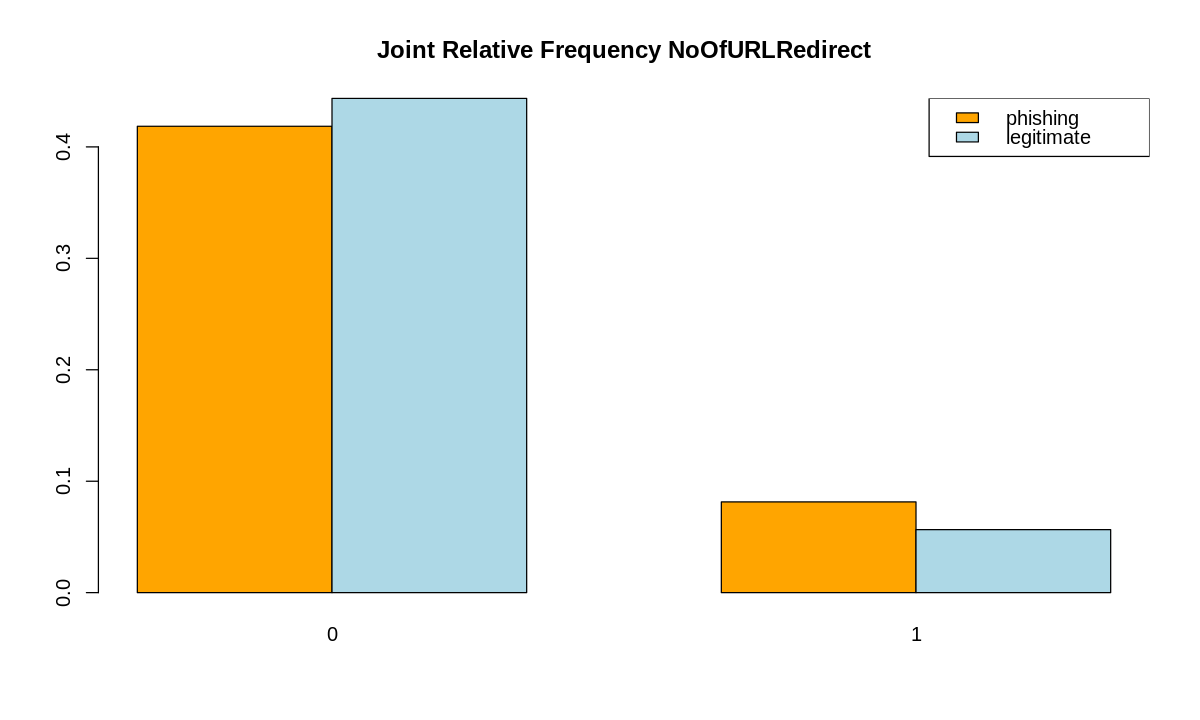

In [ ]:
# distribution
j_freq <- table(df$label, df$NoOfURLRedirect)

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfURLRedirect", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfURLRedirect)
summary(df_1$NoOfURLRedirect)

outliers <- count_outliers(df, "NoOfURLRedirect")
outliers_0 <- count_outliers(df_0, "NoOfURLRedirect")
outliers_1 <- count_outliers(df_1, "NoOfURLRedirect")

cat('\nn. outliers NoOfURLRedirect: \t\t', outliers)
cat('\nn. outliers NoOfURLRedirect (0): \t', outliers_0)
cat('\nn. outliers NoOfURLRedirect (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1629  0.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1131  0.0000  1.0000 


n. outliers NoOfURLRedirect: 		 2781
n. outliers NoOfURLRedirect (0): 	 1641
n. outliers NoOfURLRedirect (1): 	 1140

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfURLRedirect, df$label)
spearman <- cor(df$NoOfURLRedirect, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.07213915
Spearman: 	 -0.07213915

In [ ]:
df <- subset(df, select = -NoOfURLRedirect)

### 37. Feature **NoOfSelfRedirect**

Delete this feature because has:
* 96% of data is setting to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfSelfRedirect)

cat('\nvar: ', var(df$NoOfSelfRedirect), '\n')
cat('std: ', sd(df$NoOfSelfRedirect))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04277 0.00000 1.00000 


var:  0.04094531 
std:  0.2023495

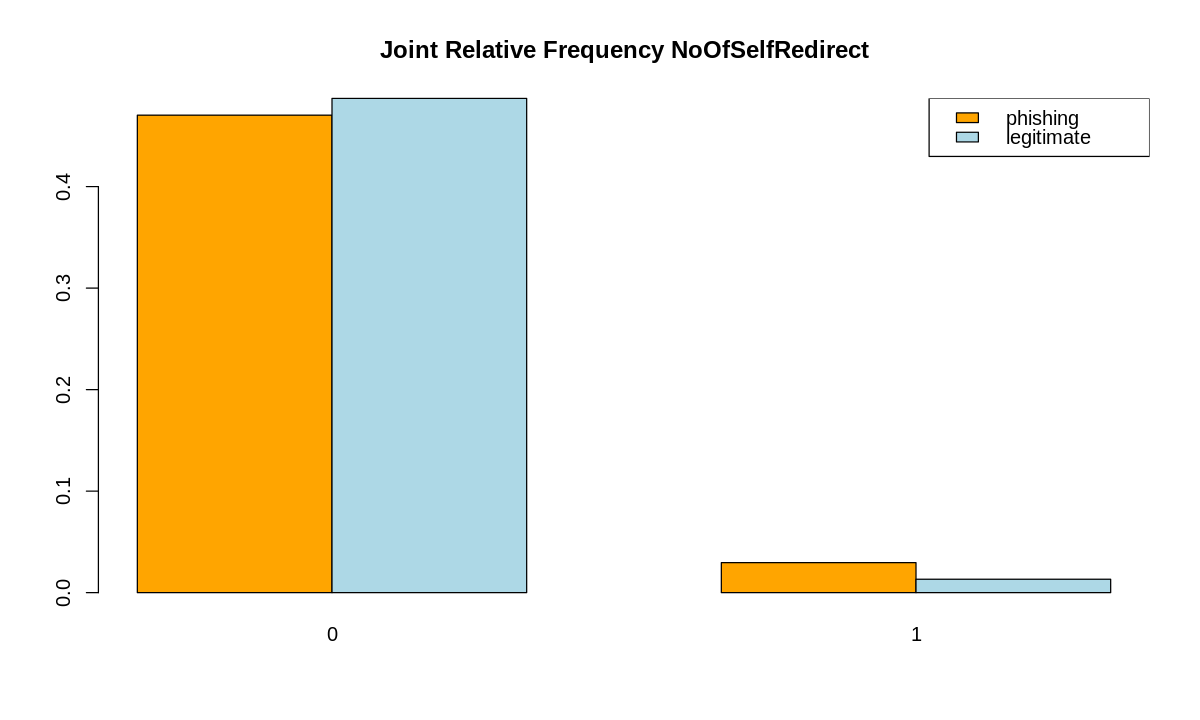

In [ ]:
# distribution
j_freq <- table(df$label, df$NoOfSelfRedirect)

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfSelfRedirect", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfSelfRedirect)
summary(df_1$NoOfSelfRedirect)

outliers <- count_outliers(df, "NoOfSelfRedirect")
outliers_0 <- count_outliers(df_0, "NoOfSelfRedirect")
outliers_1 <- count_outliers(df_1, "NoOfSelfRedirect")

cat('\nn. outliers NoOfSelfRedirect: \t\t', outliers)
cat('\nn. outliers NoOfSelfRedirect (0): \t', outliers_0)
cat('\nn. outliers NoOfSelfRedirect (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.05916 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02639 0.00000 1.00000 


n. outliers NoOfSelfRedirect: 		 862
n. outliers NoOfSelfRedirect (0): 	 596
n. outliers NoOfSelfRedirect (1): 	 266

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfSelfRedirect, df$label)
spearman <- cor(df$NoOfSelfRedirect, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.08095651
Spearman: 	 -0.08095651

In [ ]:
df <- subset(df, select = -NoOfSelfRedirect)

### 38. Feature **HasDescription**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasDescription)

cat('\nvar: ', var(df$HasDescription), '\n')
cat('std: ', sd(df$HasDescription))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3877  1.0000  1.0000 


var:  0.2373969 
std:  0.487234

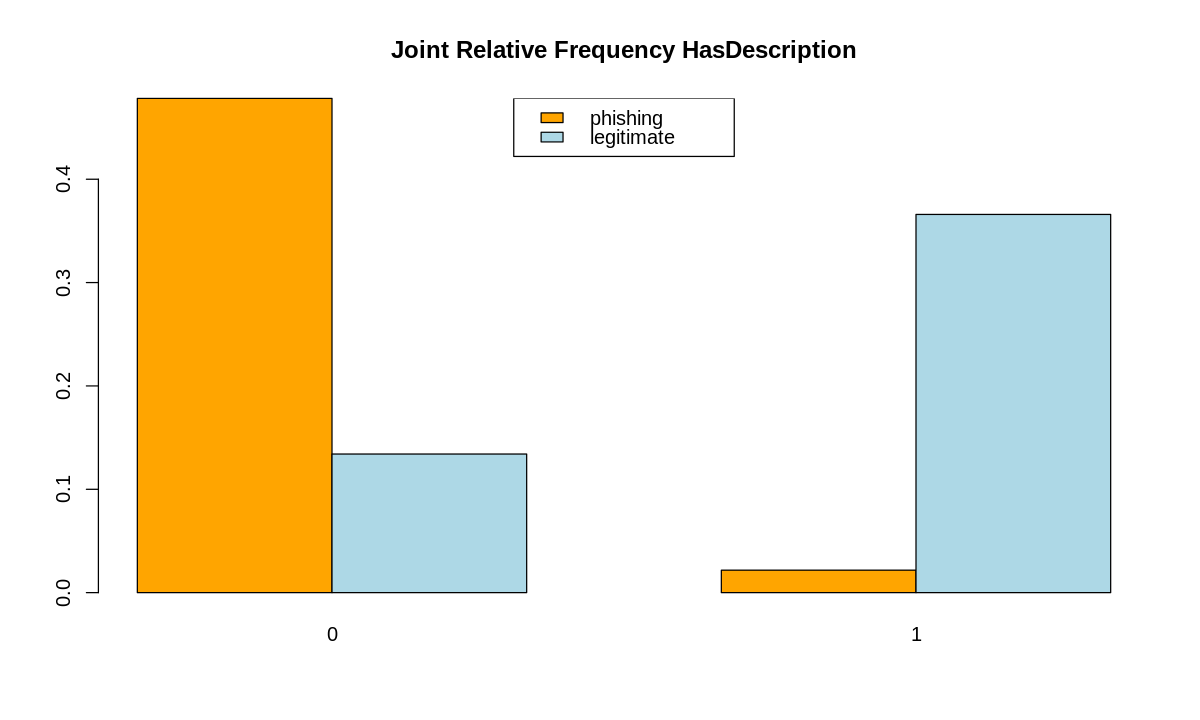

In [ ]:
j_freq <- table(df$label, df$HasDescription)
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasDescription", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasDescription, df$label)
spearman <- cor(df$HasDescription, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.7063702
Spearman: 	 0.7063702

### 39. Feature **NoOfPopup**

Delete this feature because has:
* 95% of data is setting to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfPopup)

cat('\nvar: ', var(df$NoOfPopup), '\n')
cat('std: ', sd(df$NoOfPopup))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.0000   0.0000   0.1848   0.0000 396.0000 


var:  12.67241 
std:  3.559833

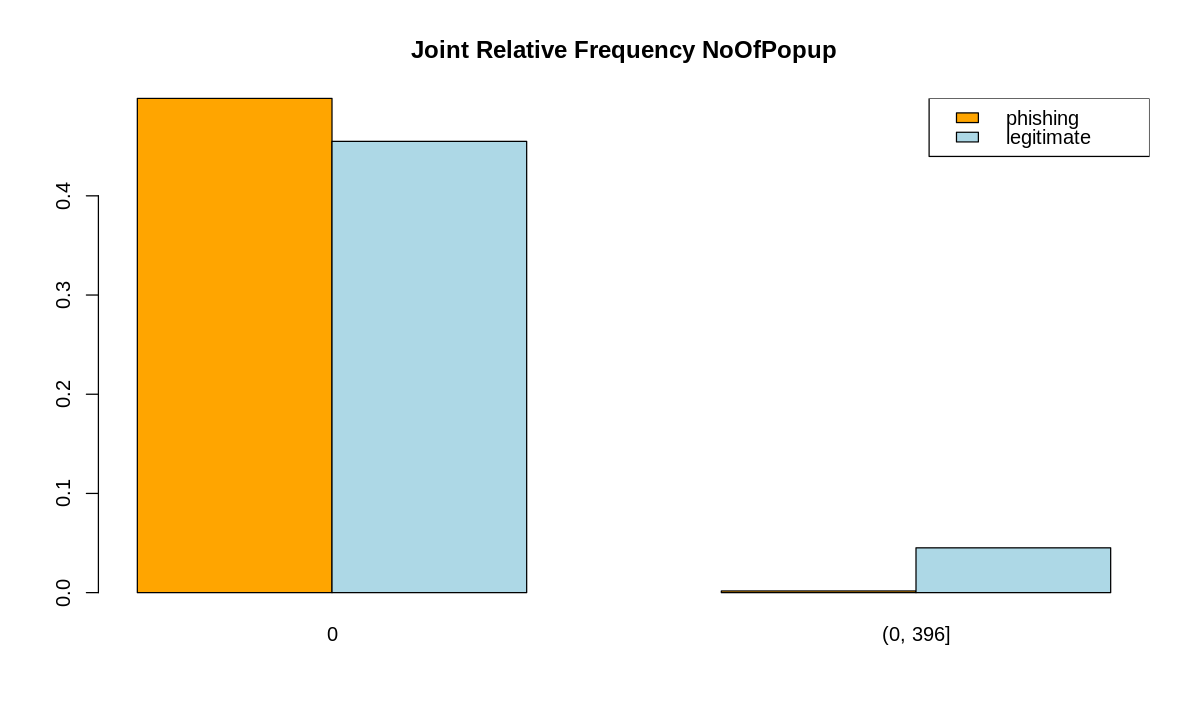

In [ ]:
# distribution
breaks = c(-Inf, 0, 396)

labels = c("0", "(0, 396]")

j_freq <- table(df$label, cut(df$NoOfPopup, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfPopup", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfPopup)
summary(df_1$NoOfPopup)

outliers <- count_outliers(df, "NoOfPopup")
outliers_0 <- count_outliers(df_0, "NoOfPopup")
outliers_1 <- count_outliers(df_1, "NoOfPopup")

cat('\nn. outliers NoOfPopup: \t\t', outliers)
cat('\nn. outliers NoOfPopup (0): \t', outliers_0)
cat('\nn. outliers NoOfPopup (1): \t', outliers_1)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.006849 0.000000 5.000000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.0000   0.0000   0.3628   0.0000 396.0000 


n. outliers NoOfPopup: 		 946
n. outliers NoOfPopup (0): 	 35
n. outliers NoOfPopup (1): 	 911

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfPopup, df$label)
spearman <- cor(df$NoOfPopup, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.04999259
Spearman: 	 0.205457

In [ ]:
df <- subset(df, select = -NoOfPopup)

### 40. Feature **HasFavicon**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasFavicon)

cat('\nvar: ', var(df$HasFavicon), '\n')
cat('std: ', sd(df$HasFavicon))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3235  1.0000  1.0000 


var:  0.2188499 
std:  0.467814

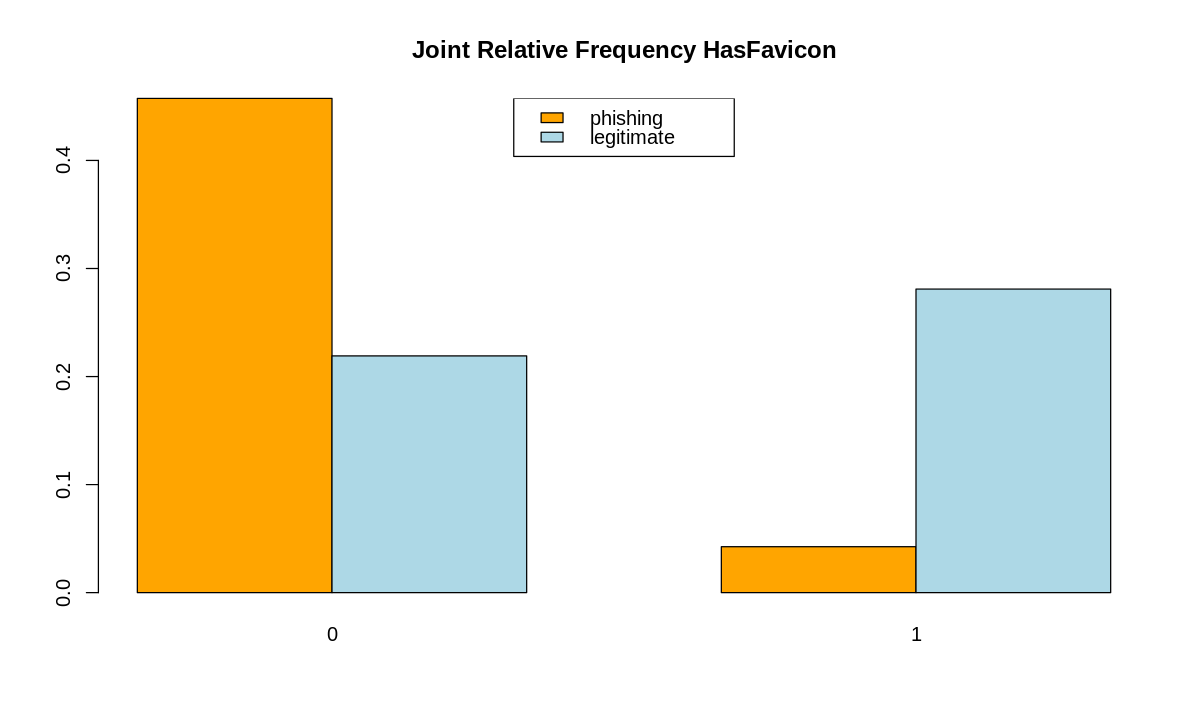

In [ ]:
j_freq <- table(df$label, df$HasFavicon)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasFavicon", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasFavicon, df$label)
spearman <- cor(df$HasFavicon, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5095696
Spearman: 	 0.5095696

### 41. Feature **NoOfiFrame**

Delete this feature because has:
* 94% of phishing sites are setting to 0
* positive correlation with label, not utils for detecting phishing sites


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfiFrame)

cat('\nvar: ', var(df$NoOfiFrame), '\n')
cat('std: ', sd(df$NoOfiFrame))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.348   1.000 172.000 


var:  17.59442 
std:  4.19457

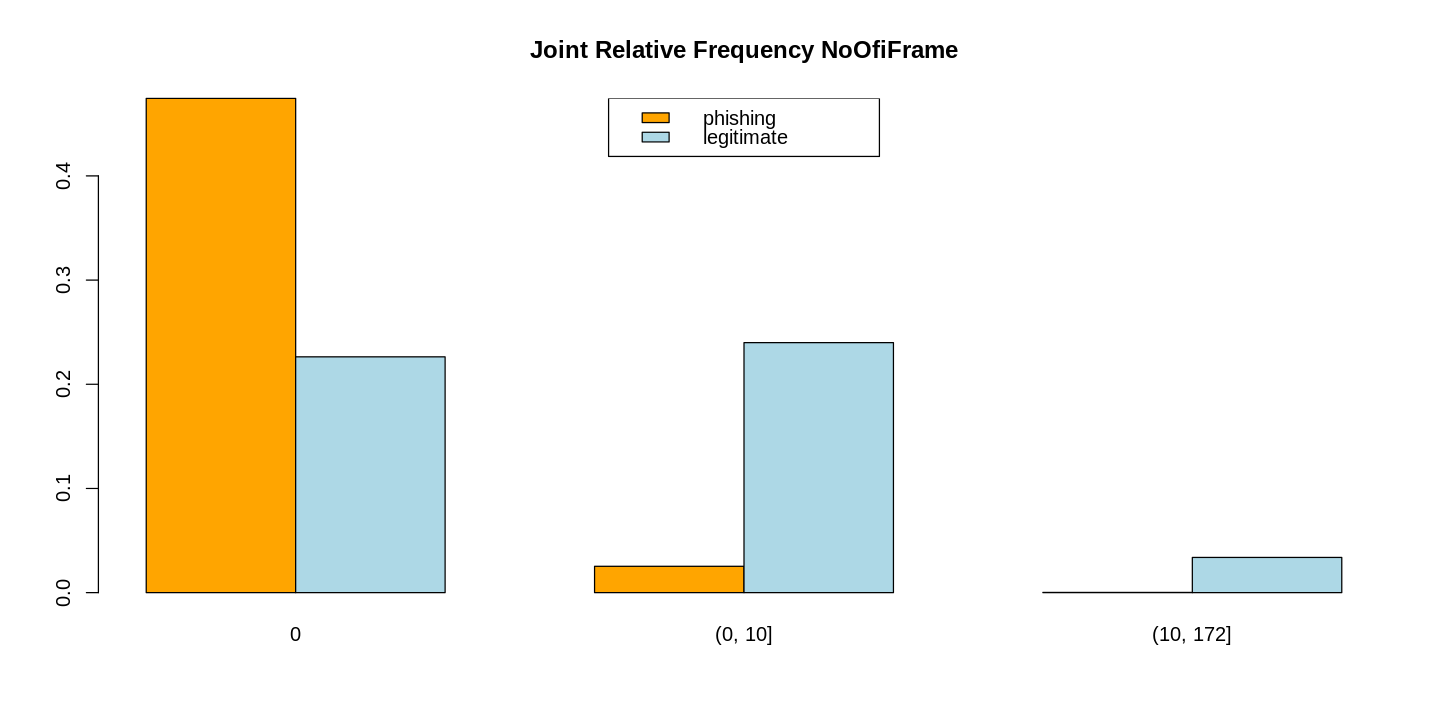

In [ ]:
breaks = c(-Inf, 0, 10, 172)

labels = c("0", "(0, 10]", "(10, 172]")

j_freq <- table(df$label, cut(df$NoOfiFrame, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfiFrame", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfiFrame)
summary(df_1$NoOfiFrame)

outliers <- count_outliers(df, "NoOfiFrame")
outliers_0 <- count_outliers(df_0, "NoOfiFrame")
outliers_1 <- count_outliers(df_1, "NoOfiFrame")

cat('\nn. outliers NoOfiFrame: \t', outliers)
cat('\nn. outliers NoOfiFrame (0): \t', outliers_0)
cat('\nn. outliers NoOfiFrame (1): \t', outliers_1)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00000  0.00000  0.00000  0.08973  0.00000 25.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   2.605   2.000 172.000 


n. outliers NoOfiFrame: 	 2556
n. outliers NoOfiFrame (0): 	 515
n. outliers NoOfiFrame (1): 	 1140

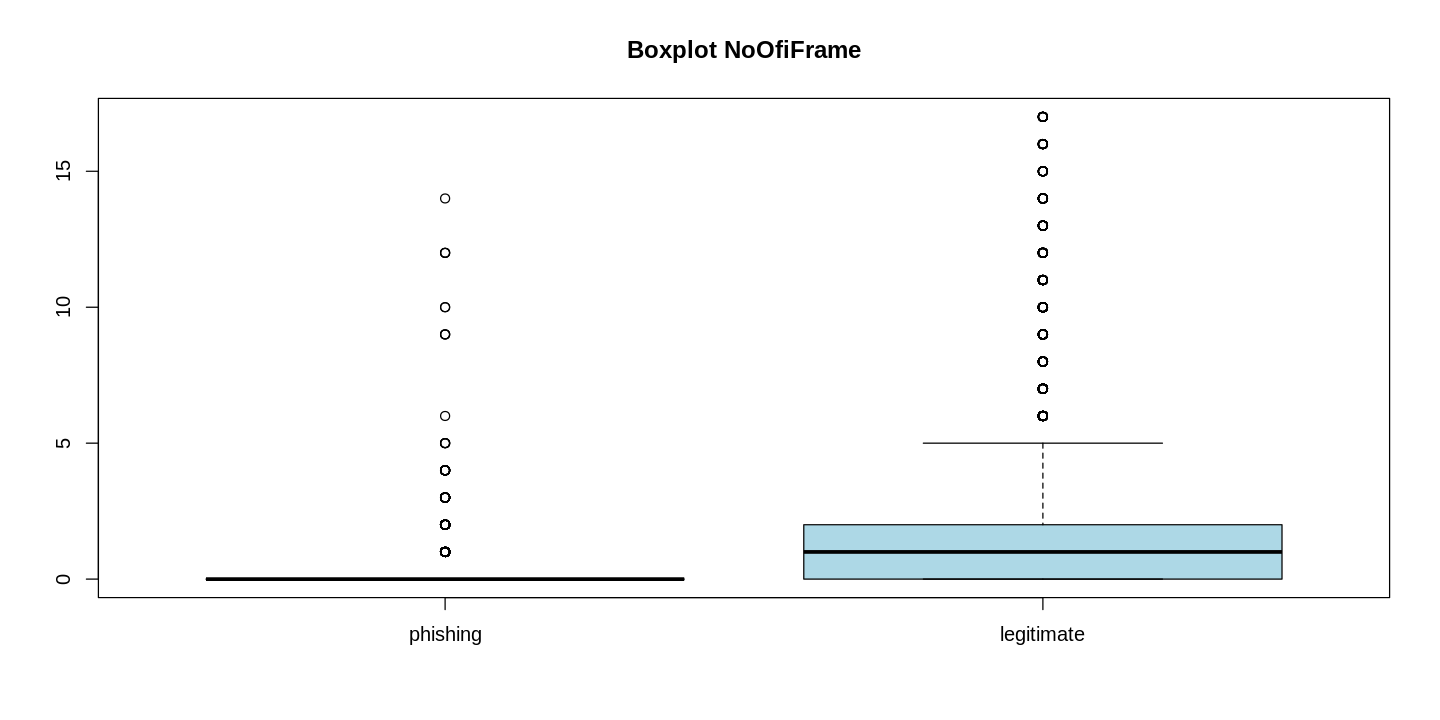

In [ ]:
boxplot(df_0$NoOfiFrame, df_1$NoOfiFrame,
        main = 'Boxplot NoOfiFrame', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfiFrame), quantile(df_1$NoOfiFrame, 0.95)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfiFrame")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 0 M2 = 0 
Overlap df_1: M1 = 0.9687217 M2 = 1.031278 


#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfiFrame, df$label)
spearman <- cor(df$NoOfiFrame, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.2998655
Spearman: 	 0.5438345

In [ ]:
df <- subset(df, select = -NoOfiFrame)

### 42. Feature **HasExternalFormSubmit**

Delete this feature because has:
* 95% of data is setting to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasExternalFormSubmit)

cat('\nvar: ', var(df$HasExternalFormSubmit), '\n')
cat('std: ', sd(df$HasExternalFormSubmit))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.03781 0.00000 1.00000 


var:  0.0363829 
std:  0.190743

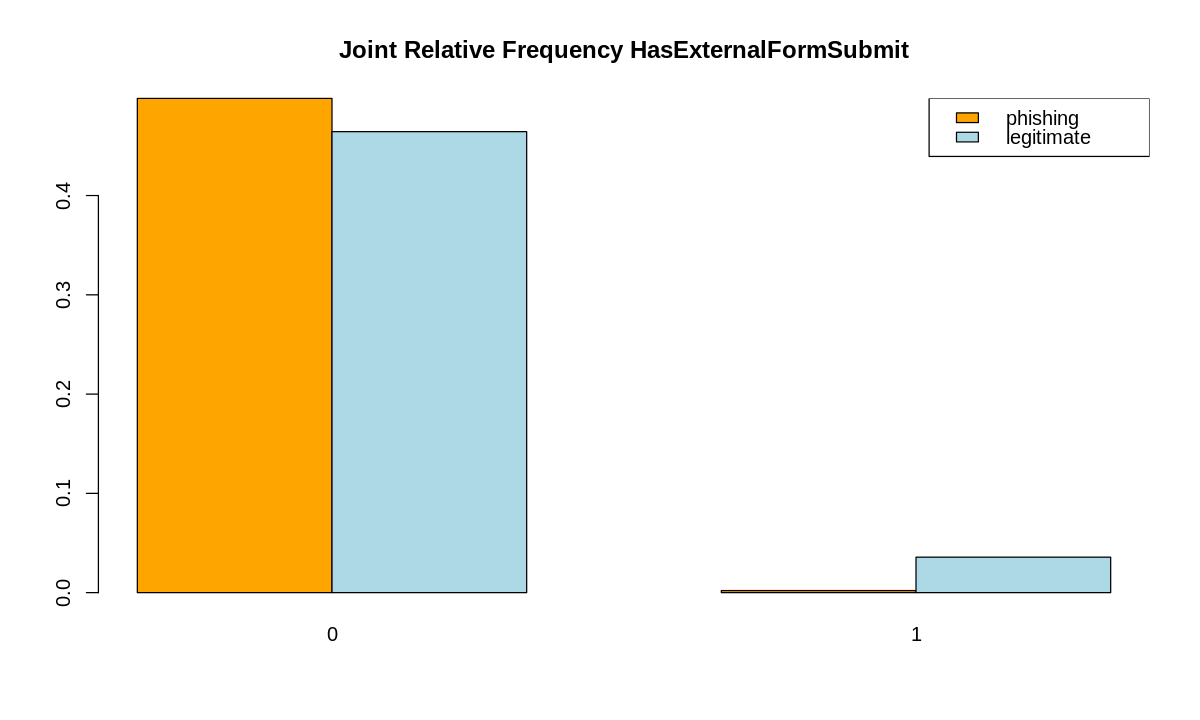

In [ ]:
# distribution
j_freq <- table(df$label, df$HasExternalFormSubmit)

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasExternalFormSubmit", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasExternalFormSubmit, df$label)
spearman <- cor(df$HasExternalFormSubmit, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1763516
Spearman: 	 0.1763516

In [ ]:
df <- subset(df, select = -HasExternalFormSubmit)

### 43. Feature **HasSocialNet**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasSocialNet)

cat('\nvar: ', var(df$HasSocialNet), '\n')
cat('std: ', sd(df$HasSocialNet))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3975  1.0000  1.0000 


var:  0.2395075 
std:  0.489395

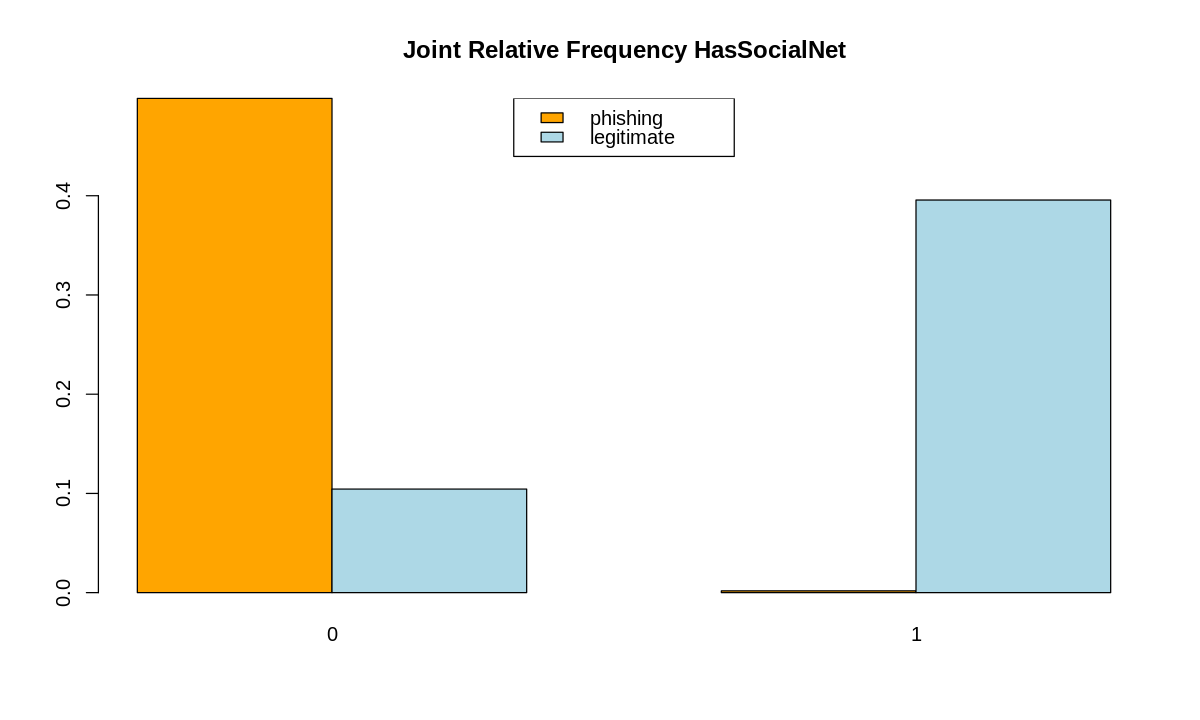

In [ ]:
j_freq <- table(df$label, df$HasSocialNet)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasSocialNet", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasSocialNet, df$label)
spearman <- cor(df$HasSocialNet, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.8046419
Spearman: 	 0.8046419

### 44. Feature **HasSubmitButton**

Delete this feature because has:
* positive correlation with label, not utils for detecting phishing sites
* 90% of phishing sites has setting to False (0)

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasSubmitButton)

cat('\nvar: ', var(df$HasSubmitButton), '\n')
cat('std: ', sd(df$HasSubmitButton))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3781  1.0000  1.0000 


var:  0.2351539 
std:  0.4849267

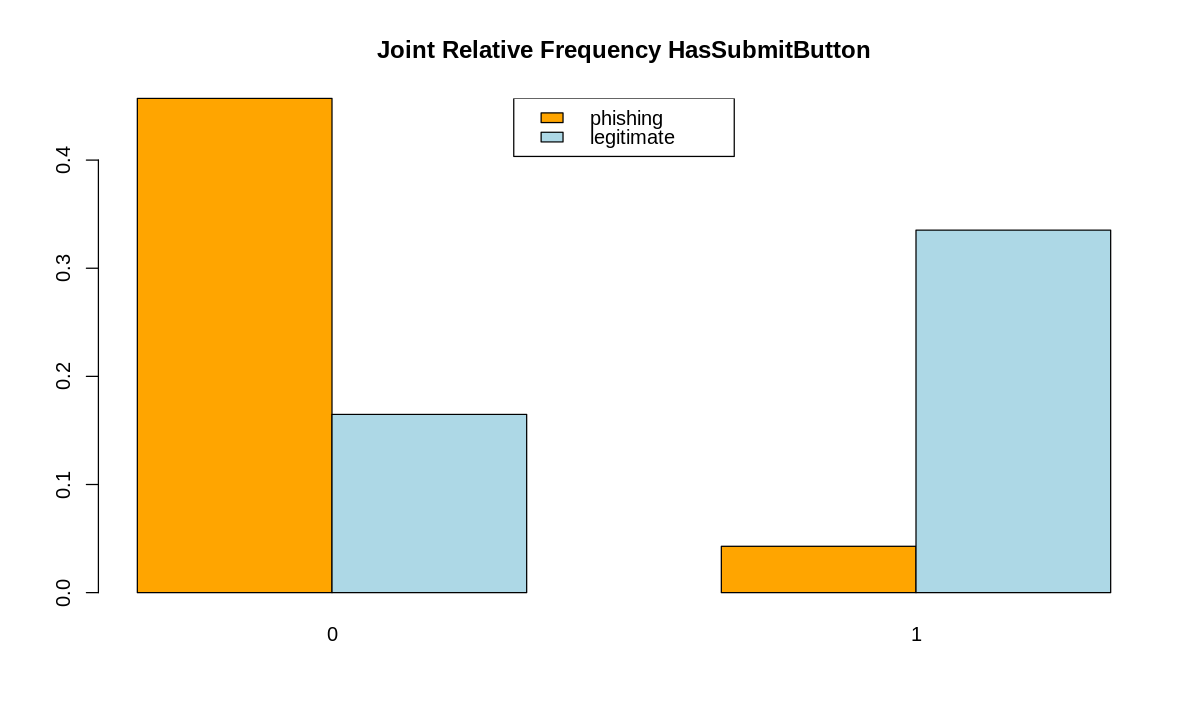

In [ ]:
j_freq <- table(df$label, df$HasSubmitButton)
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasSubmitButton", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasSubmitButton, df$label)
spearman <- cor(df$HasSubmitButton, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.6028012
Spearman: 	 0.6028012

In [ ]:
df <- subset(df, select = -HasSubmitButton)

### 45. Feature **HasHiddenFields**

Delete this feature because has:
* positive correlation with label, not utils for detecting phishing sites
* 91% of phishing sites has setting to False (0)

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasHiddenFields)

cat('\nvar: ', var(df$HasHiddenFields), '\n')
cat('std: ', sd(df$HasHiddenFields))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3415  1.0000  1.0000 


var:  0.2249007 
std:  0.474237

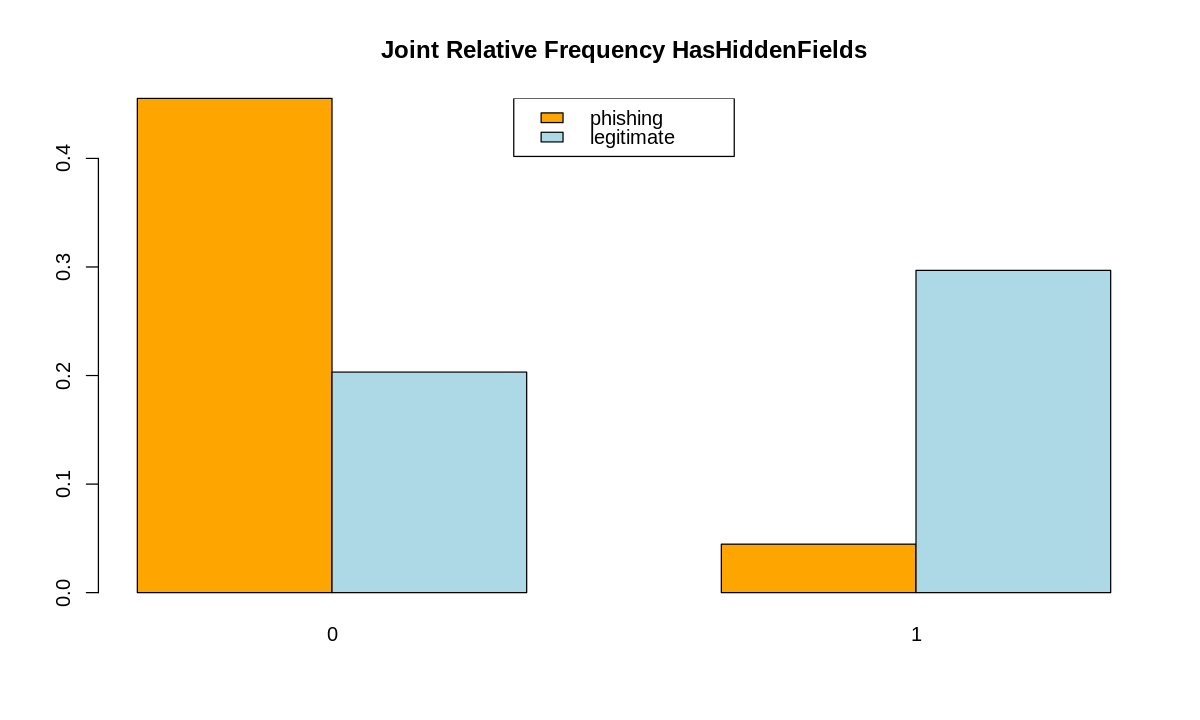

In [ ]:
j_freq <- table(df$label, df$HasHiddenFields)
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasHiddenFields", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasHiddenFields, df$label)
spearman <- cor(df$HasHiddenFields, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5317509
Spearman: 	 0.5317509

In [ ]:
df <- subset(df, select = -HasHiddenFields)

### 46. Feature **HasPasswordField**

Delete feature because has 90% of data is setting to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasPasswordField)

cat('\nvar: ', var(df$HasPasswordField), '\n')
cat('std: ', sd(df$HasPasswordField))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1003  0.0000  1.0000 


var:  0.09027033 
std:  0.3004502

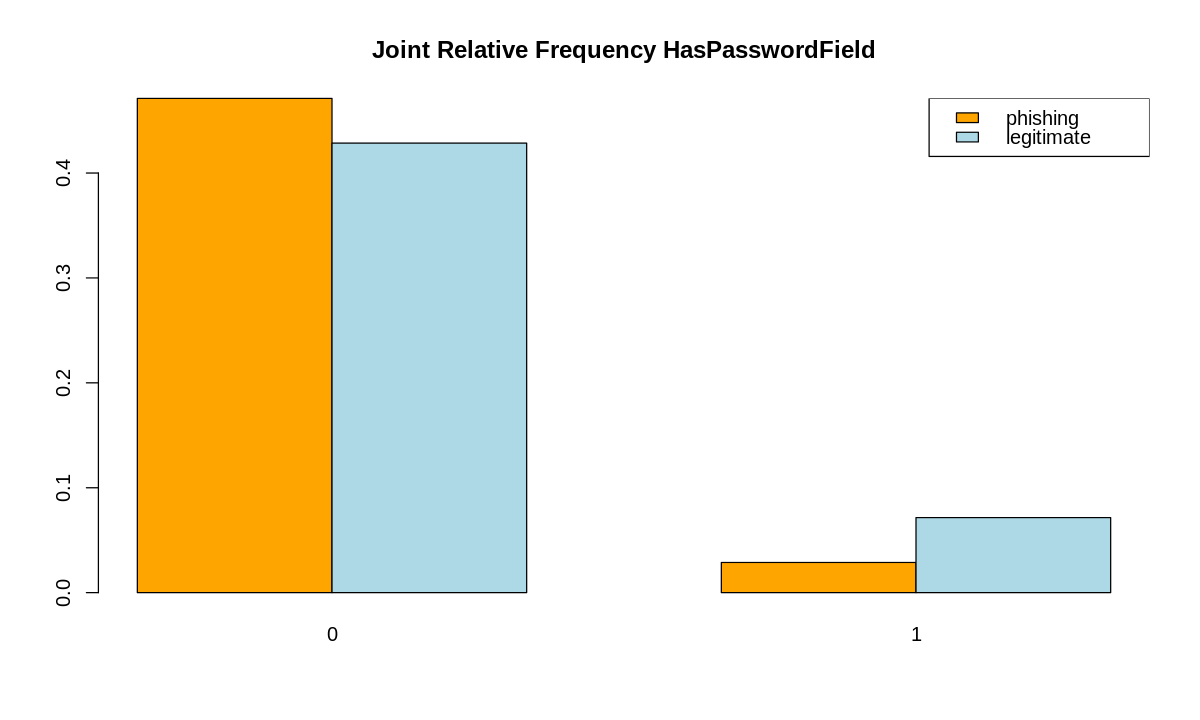

In [ ]:
j_freq <- table(df$label, df$HasPasswordField)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasPasswordField", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasPasswordField, df$label)
spearman <- cor(df$HasPasswordField, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1423161
Spearman: 	 0.1423161

In [ ]:
df <- subset(df, select = -HasPasswordField)

### 47. Feature **Bank**

Delete feature because has:
* 87% of data is setting to 0
* 94% of phishing sites has setting to False (0)

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$Bank)

cat('\nvar: ', var(df$Bank), '\n')
cat('std: ', sd(df$Bank))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.116   0.000   1.000 


var:  0.1025206 
std:  0.3201884

   
             0          1
  0 0.47471840 0.02520717
  1 0.40931871 0.09075572

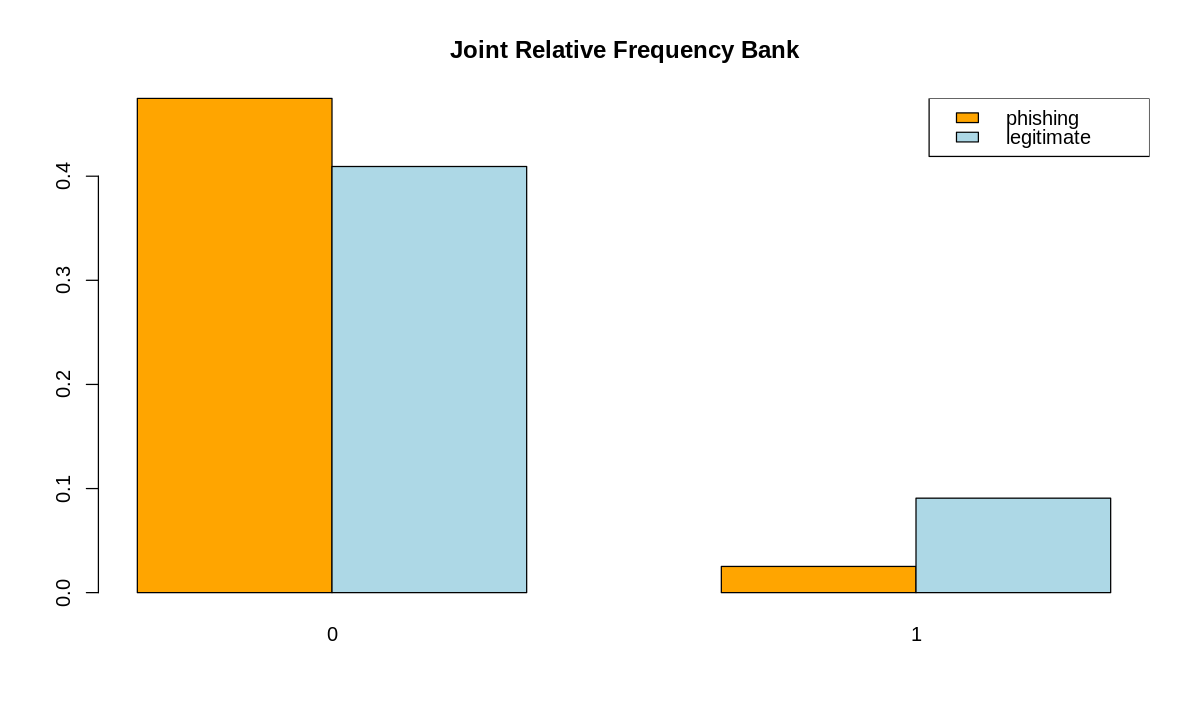

In [ ]:
j_freq <- table(df$label, df$Bank)
j_freq_rel <- prop.table(j_freq)
j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency Bank", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$Bank, df$label)
spearman <- cor(df$Bank, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.2046699
Spearman: 	 0.2046699

In [ ]:
df <- subset(df, select = -Bank)

### 48. Feature **Pay**

Delete feature because has:
* 78% of data is setting to 0
* 94% of phishing sites has setting to False (0)

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$Pay)

cat('\nvar: ', var(df$Pay), '\n')
cat('std: ', sd(df$Pay))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.2168  0.0000  1.0000 


var:  0.1698014 
std:  0.4120696

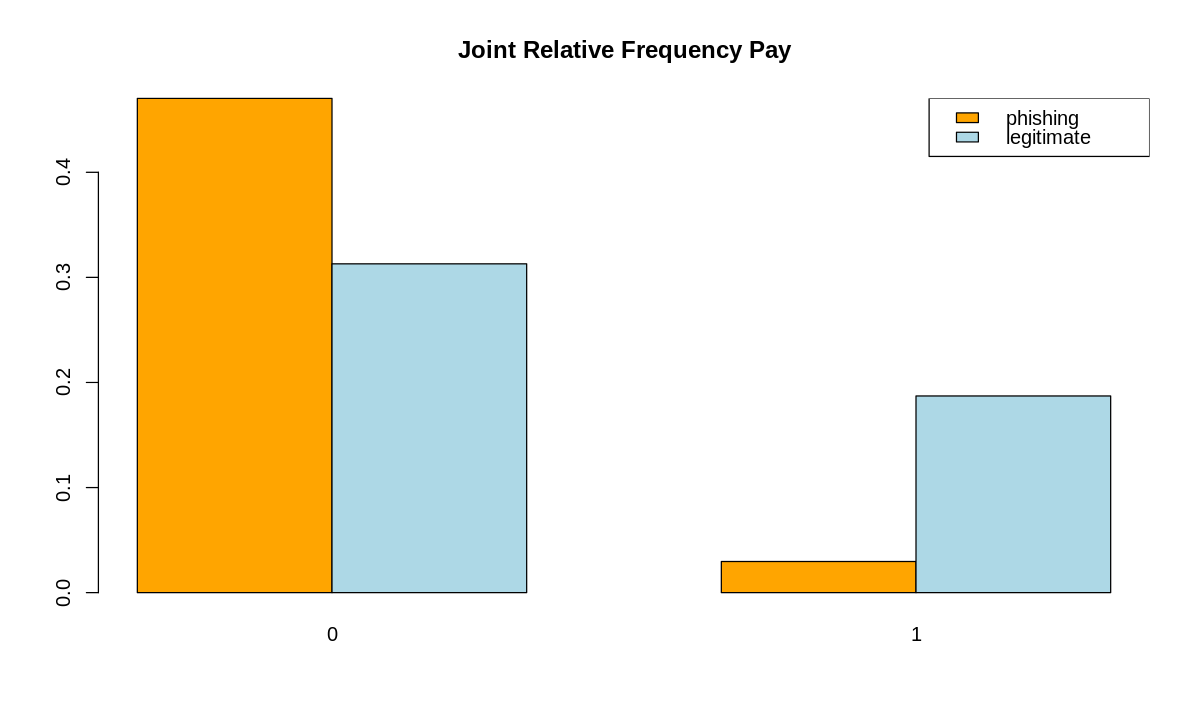

In [ ]:
j_freq <- table(df$label, df$Pay)
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency Pay", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$Pay, df$label)
spearman <- cor(df$Pay, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.3822568
Spearman: 	 0.3822568

In [ ]:
df <- subset(df, select = -Pay)

### 49. Feature **Crypto**

Delete feature because has:
* 98% of data is setting to 0

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$Crypto)

cat('\nvar: ', var(df$Crypto), '\n')
cat('std: ', sd(df$Crypto))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.0201  0.0000  1.0000 


var:  0.01969338 
std:  0.1403331

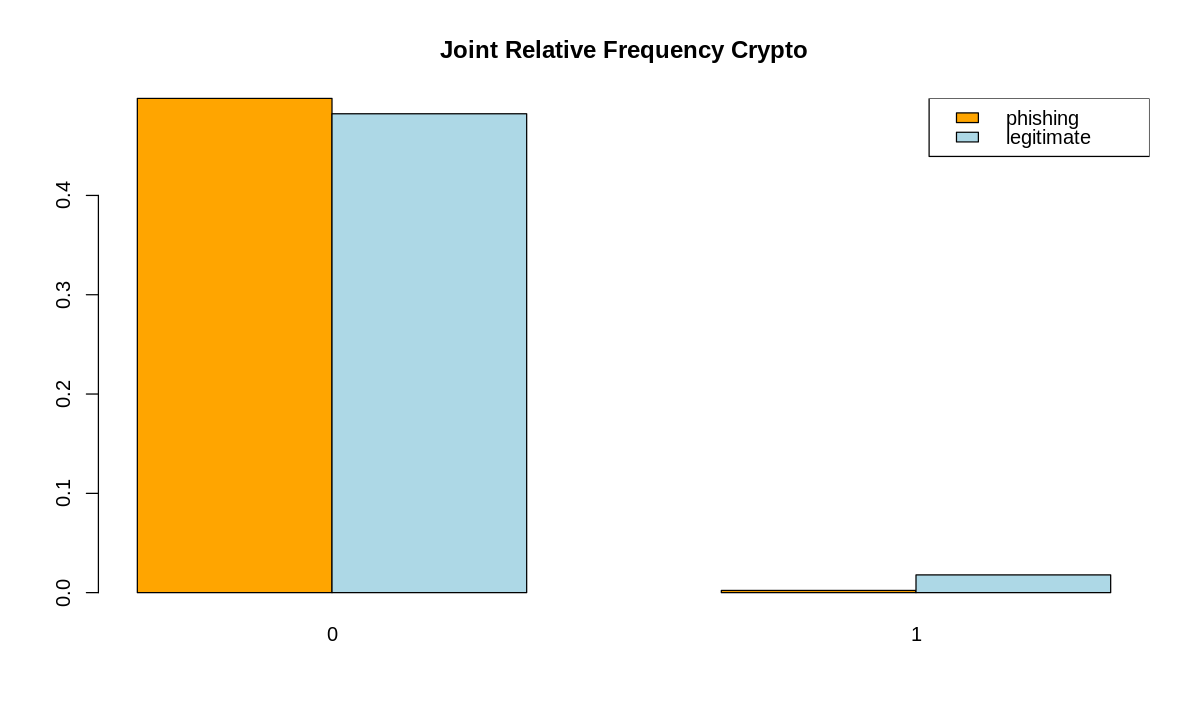

In [ ]:
j_freq <- table(df$label, df$Crypto)
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency Crypto", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$Crypto, df$label)
spearman <- cor(df$Crypto, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1113623
Spearman: 	 0.1113623

In [ ]:
df <- subset(df, select = -Crypto)

### 50. Feature **HasCopyrightInfo**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$HasCopyrightInfo)

cat('\nvar: ', var(df$HasCopyrightInfo), '\n')
cat('std: ', sd(df$HasCopyrightInfo))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4308  1.0000  1.0000 


var:  0.2452173 
std:  0.4951942

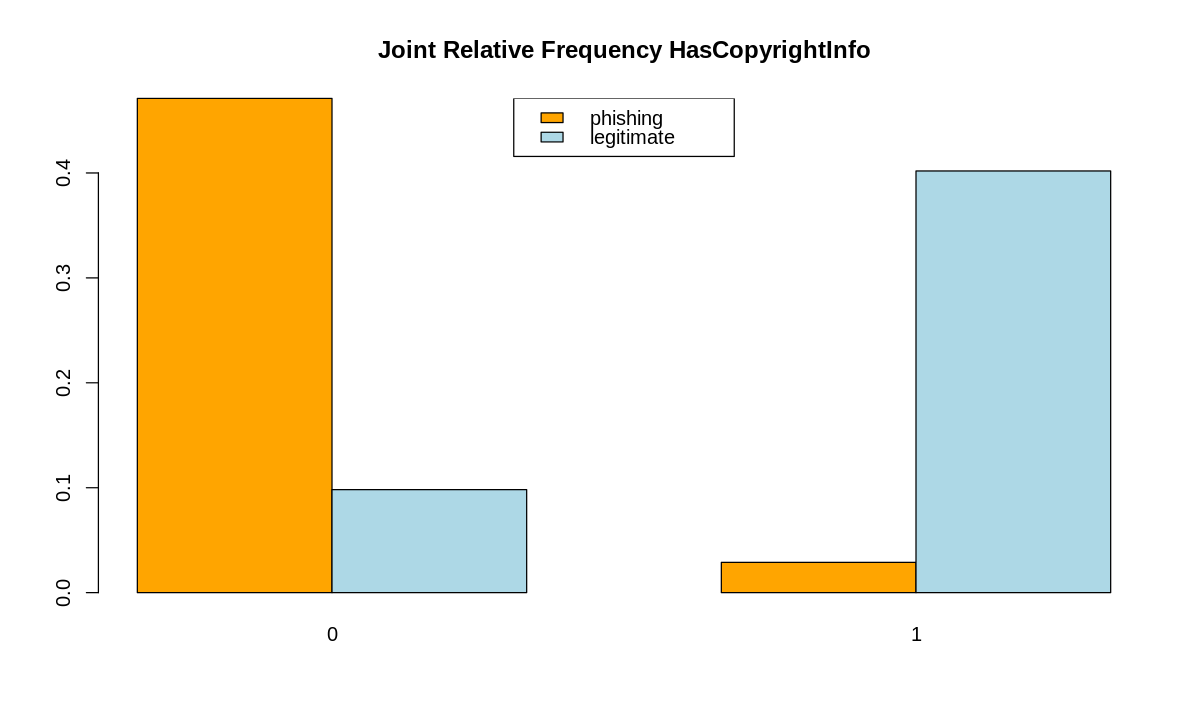

In [ ]:
j_freq <- table(df$label, df$HasCopyrightInfo)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasCopyrightInfo", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasCopyrightInfo, df$label)
spearman <- cor(df$HasCopyrightInfo, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.7531222
Spearman: 	 0.7531222

### 51. Feature **NoOfImage**

Threat actors can use screenshots of legitimate web sites and design phishing websites to make them appear more legiti mate. **More images used in respectively small websites may indicate phishing websites**.


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfImage)

cat('\nvar: ', var(df$NoOfImage), '\n')
cat('std: ', sd(df$NoOfImage))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    3.00   23.15   25.00 8956.00 


var:  10387.36 
std:  101.9184

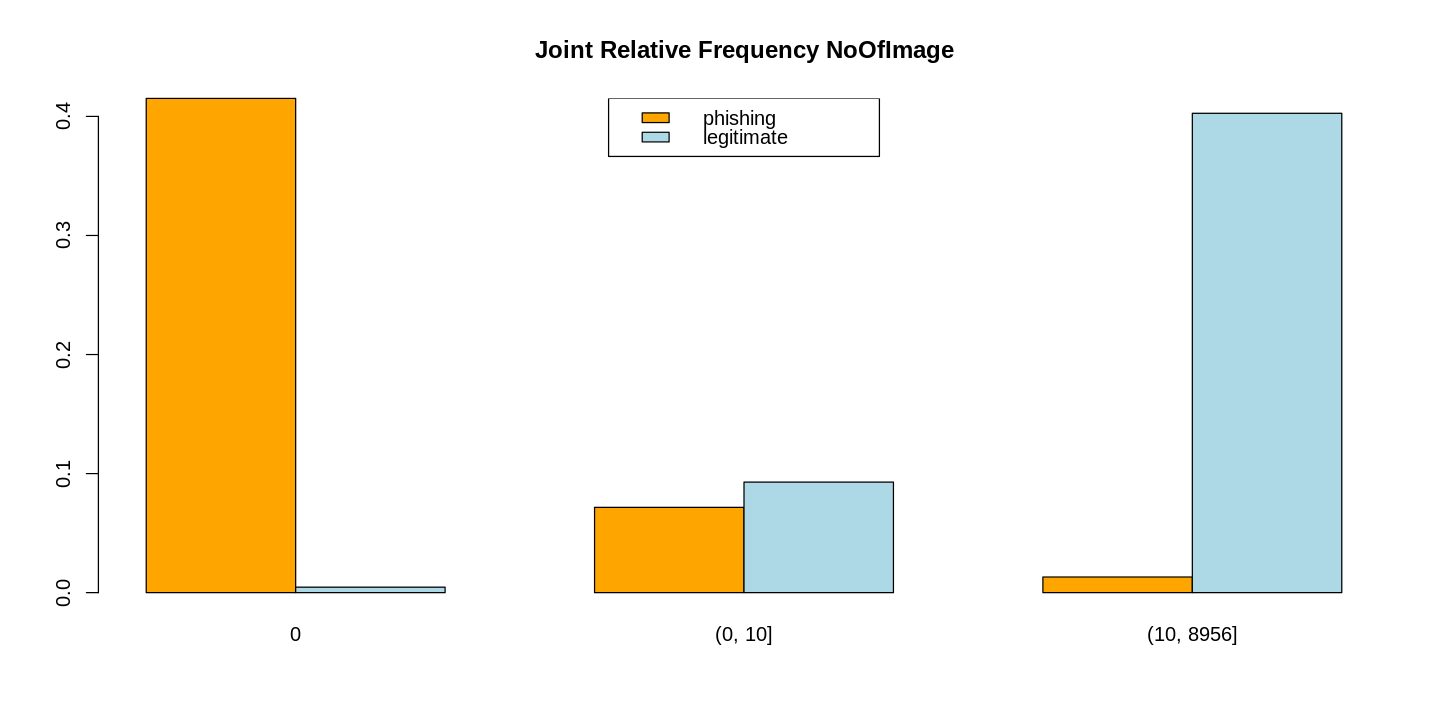

In [ ]:
breaks = c(-Inf, 0, 10, 8956)

labels = c("0", "(0, 10]", "(10, 8956]")

j_freq <- table(df$label, cut(df$NoOfImage, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfImage", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfImage)
summary(df_1$NoOfImage)

outliers <- count_outliers(df, "NoOfImage")
outliers_0 <- count_outliers(df_0, "NoOfImage")
outliers_1 <- count_outliers(df_1, "NoOfImage")

cat('\nn. outliers NoOfImage: \t\t', outliers)
cat('\nn. outliers NoOfImage (0): \t', outliers_0)
cat('\nn. outliers NoOfImage (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.8374  0.0000 31.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   13.00   25.00   45.46   46.75 8956.00 


n. outliers NoOfImage: 		 1685
n. outliers NoOfImage (0): 	 1709
n. outliers NoOfImage (1): 	 847

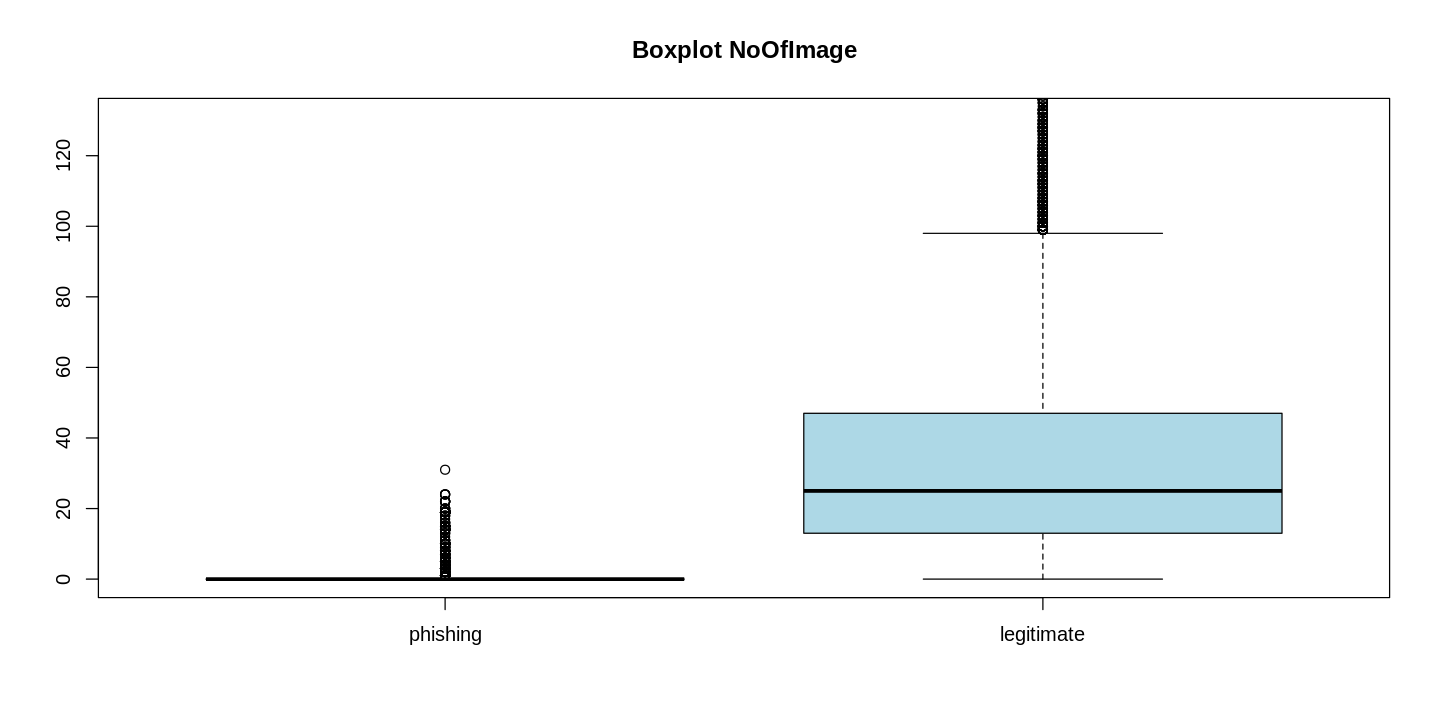

In [ ]:
boxplot(df_0$NoOfImage, df_1$NoOfImage,
        main = 'Boxplot NoOfImage', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfImage), quantile(df_1$NoOfImage, 0.95)),
        names = c('phishing', 'legitimate'))

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfImage, df$label)
spearman <- cor(df$NoOfImage, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.2189105
Spearman: 	 0.8643507

### 52. Feature **NoOfCSS**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfCSS)

cat('\nvar: ', var(df$NoOfCSS), '\n')
cat('std: ', sd(df$NoOfCSS))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     1.00     7.19     6.00 35820.00 


var:  63768.62 
std:  252.5245

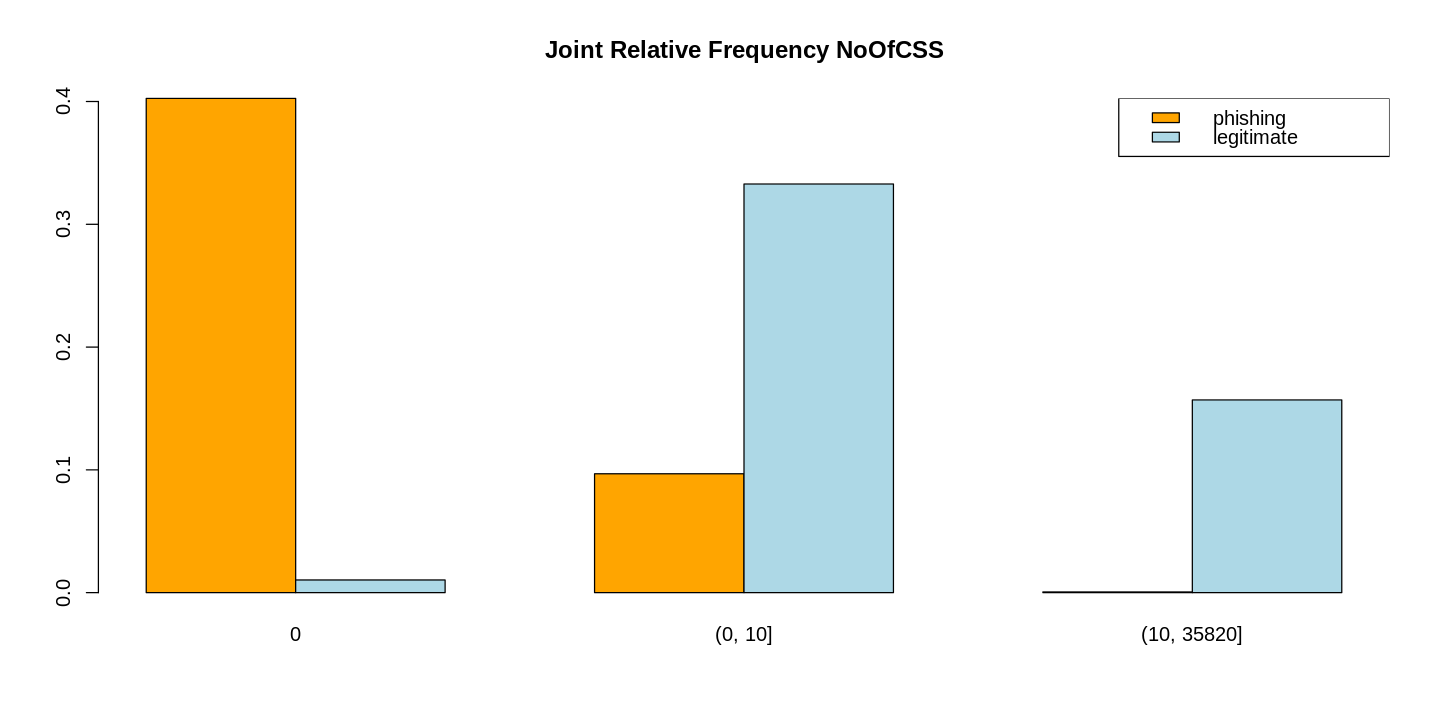

In [ ]:
breaks = c(-Inf, 0, 10, 35820)

labels = c("0", "(0, 10]", "(10, 35820]")

j_freq <- table(df$label, cut(df$NoOfCSS, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfCSS", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfCSS)
summary(df_1$NoOfCSS)

outliers <- count_outliers(df, "NoOfCSS")
outliers_0 <- count_outliers(df_0, "NoOfCSS")
outliers_1 <- count_outliers(df_1, "NoOfCSS")

cat('\nn. outliers NoOfCSS: \t\t', outliers)
cat('\nn. outliers NoOfCSS (0): \t', outliers_0)
cat('\nn. outliers NoOfCSS (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3943  0.0000 23.0000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     3.00     6.00    13.99    13.00 35820.00 


n. outliers NoOfCSS: 		 1974
n. outliers NoOfCSS (0): 	 1963
n. outliers NoOfCSS (1): 	 715

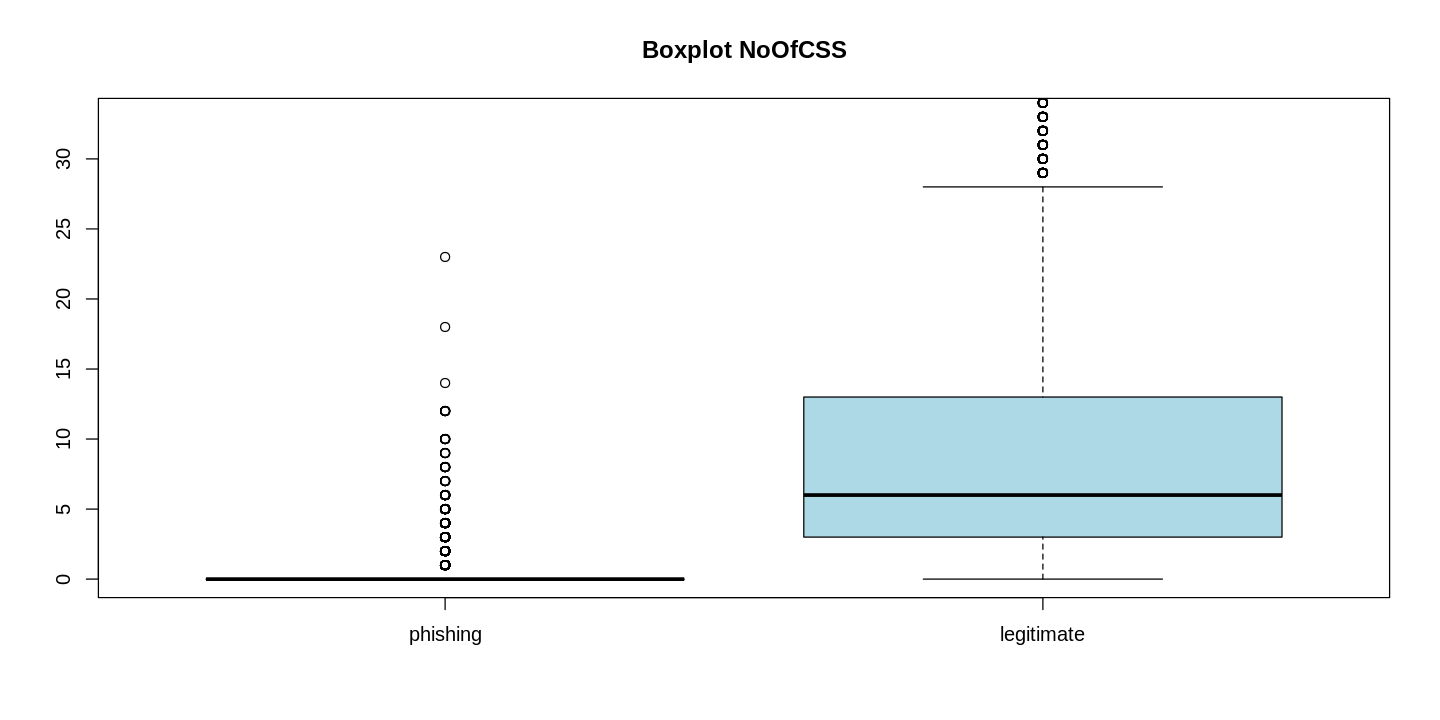

In [ ]:
boxplot(df_0$NoOfCSS, df_1$NoOfCSS,
        main = 'Boxplot NoOfCSS', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfCSS), quantile(df_1$NoOfCSS, 0.95)),
        names = c('phishing', 'legitimate'))

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfCSS, df$label)
spearman <- cor(df$NoOfCSS, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.0269262
Spearman: 	 0.8274702

### 53. Feature **NoOfJS**

Phishing websites may use JavaScript to create pop-up windows or other misleading elements that trick users into revealing sensitive information. **A large number of JavaScript included in a webpage can make it suspicious**.


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfJS)

cat('\nvar: ', var(df$NoOfJS), '\n')
cat('std: ', sd(df$NoOfJS))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   3.000   9.183  14.000 462.000 


var:  220.343 
std:  14.84395

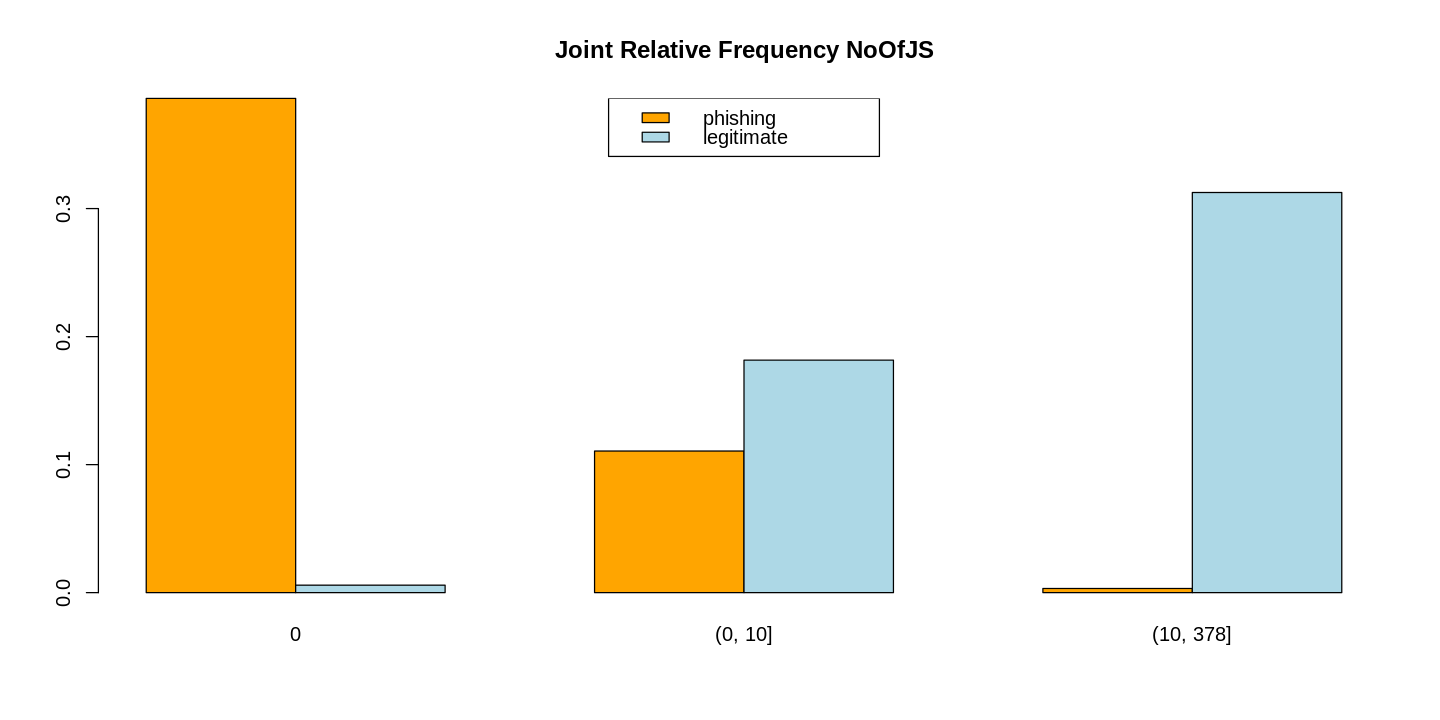

In [ ]:
breaks = c(-Inf, 0, 10, 378)

labels = c("0", "(0, 10]", "(10, 378]")

j_freq <- table(df$label, cut(df$NoOfJS, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfJS", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfJS)
summary(df_1$NoOfJS)

outliers <- count_outliers(df, "NoOfJS")
outliers_0 <- count_outliers(df_0, "NoOfJS")
outliers_1 <- count_outliers(df_1, "NoOfJS")

cat('\nn. outliers NoOfJS: \t\t', outliers)
cat('\nn. outliers NoOfJS (0): \t', outliers_0)
cat('\nn. outliers NoOfJS (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.8231  0.0000 69.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    8.00   13.00   17.54   22.00  462.00 


n. outliers NoOfJS: 		 1006
n. outliers NoOfJS (0): 	 2295
n. outliers NoOfJS (1): 	 571

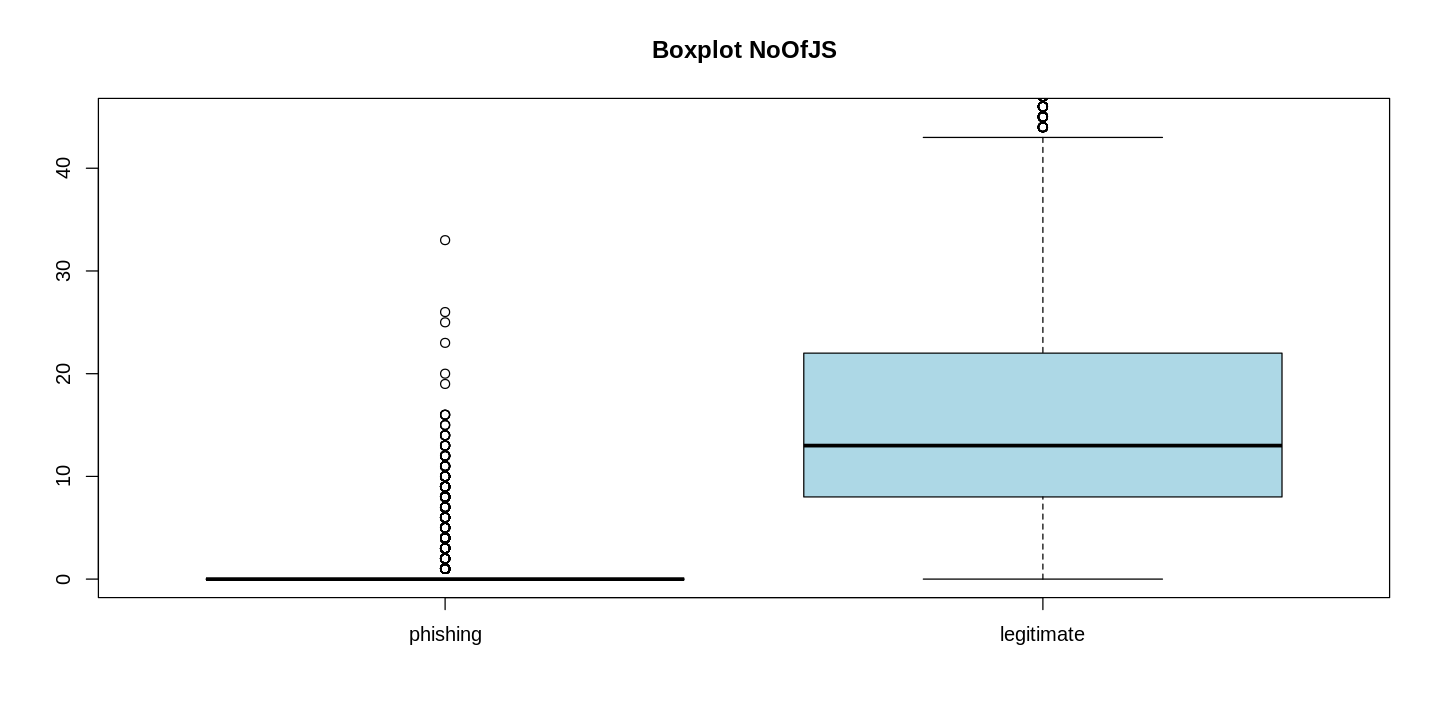

In [ ]:
boxplot(df_0$NoOfJS, df_1$NoOfJS,
        main = 'Boxplot NoOfJS', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfJS), quantile(df_1$NoOfJS, 0.95)),
        names = c('phishing', 'legitimate'))

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfJS, df$label)
spearman <- cor(df$NoOfJS, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5631072
Spearman: 	 0.8437781

### 53. Feature **NoOfExternalFiles**

Create a new feature that aggregate values of:
* NoOfImage
* NoOfCSS
* NoOfJS

**This feature should captures the complexity of sites.**


In [ ]:
df['NoOfExternalFiles'] <- df['NoOfImage'] +
                    df['NoOfCSS'] +
                           df['NoOfJS']

df <- subset(df, select = -NoOfImage)
df <- subset(df, select = -NoOfCSS)
df <- subset(df, select = -NoOfJS)

# reorder column
cols_order <- append(names(df), 'NoOfExternalFiles', after = 15)
df <- df[, cols_order]

df <- subset(df, select = -NoOfExternalFiles.1)

# update df_0 and df_1
df_0 <- df[df$label == 0, ]
df_1 <- df[df$label == 1, ]

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfExternalFiles)

cat('\nvar: ', var(df$NoOfExternalFiles), '\n')
cat('std: ', sd(df$NoOfExternalFiles))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00    12.00    39.53    52.00 44793.00 


var:  107139.7 
std:  327.322

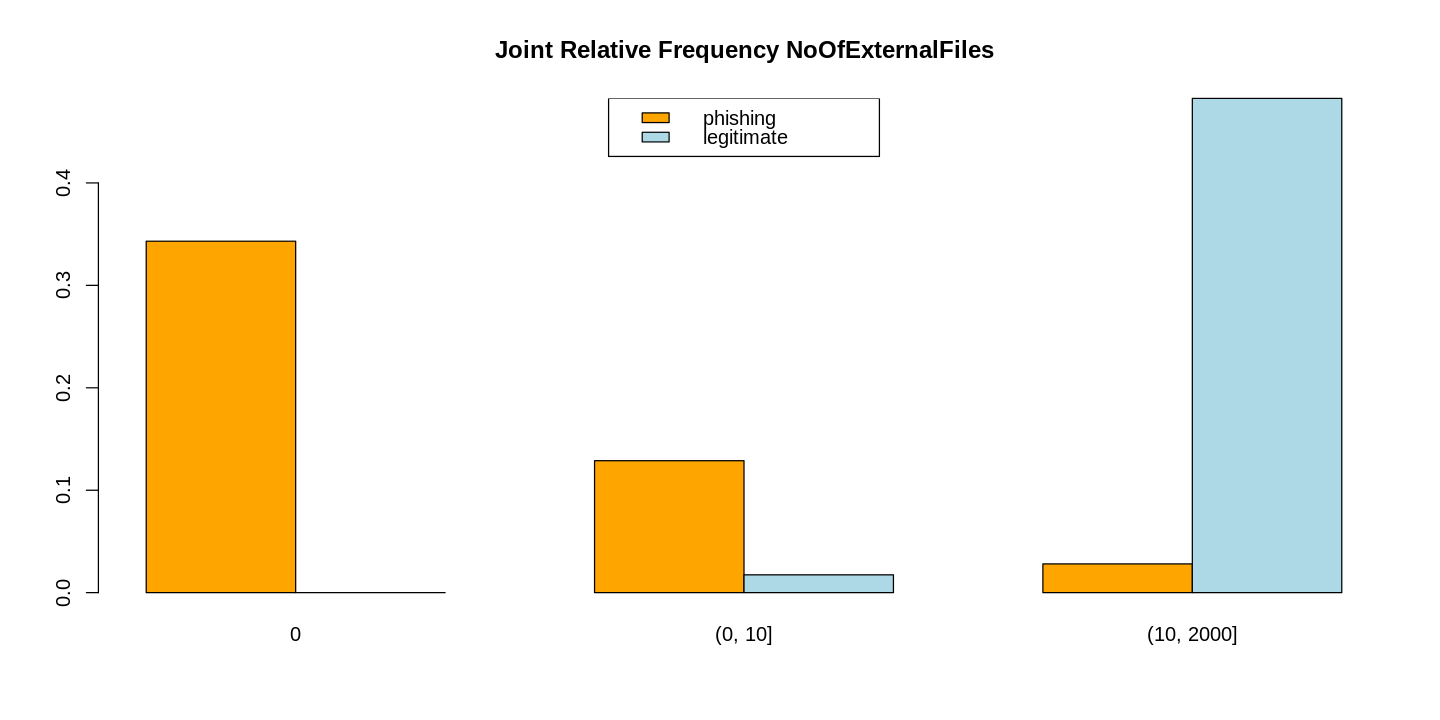

In [ ]:
breaks = c(-Inf, 0, 10, 2000)

labels = c("0", "(0, 10]", "(10, 2000]")

j_freq <- table(df$label, cut(df$NoOfExternalFiles, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfExternalFiles", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfExternalFiles)
summary(df_1$NoOfExternalFiles)

outliers <- count_outliers(df, "NoOfExternalFiles")
outliers_0 <- count_outliers(df_0, "NoOfExternalFiles")
outliers_1 <- count_outliers(df_1, "NoOfExternalFiles")

cat('\nn. outliers NoOfExternalFiles: \t\t', outliers)
cat('\nn. outliers NoOfExternalFiles (0): \t', outliers_0)
cat('\nn. outliers NoOfExternalFiles (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   2.055   1.000 104.000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    1.00    31.00    52.00    76.99    85.00 44793.00 


n. outliers NoOfExternalFiles: 		 1086
n. outliers NoOfExternalFiles (0): 	 1669
n. outliers NoOfExternalFiles (1): 	 602

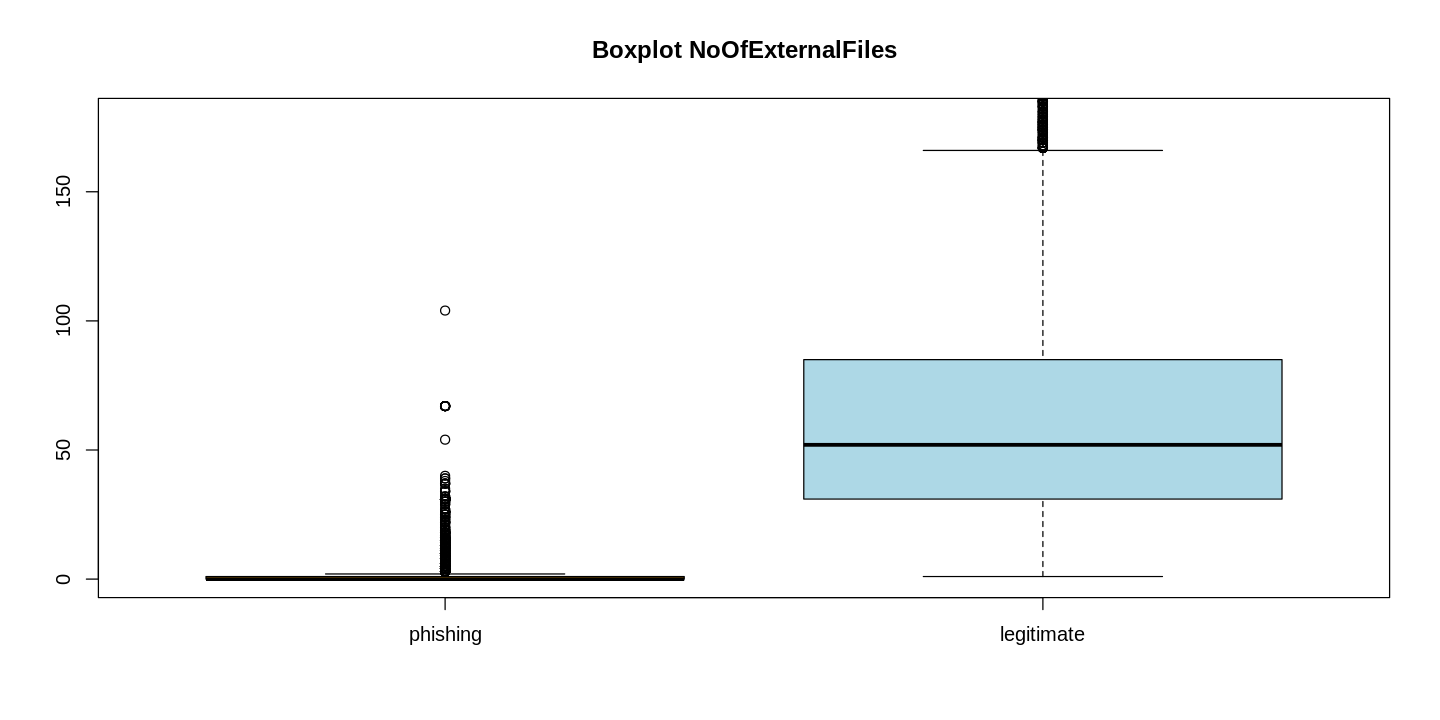

In [ ]:
boxplot(df_0$NoOfExternalFiles, df_1$NoOfExternalFiles,
        main = 'Boxplot NoOfExternalFiles', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfExternalFiles), quantile(df_1$NoOfExternalFiles, 0.95)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfExternalFiles")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = -0.01564145 M2 = 0.01564145 
Overlap df_1: M1 = 51.15549 M2 = 52.84451 


#### Distribution form

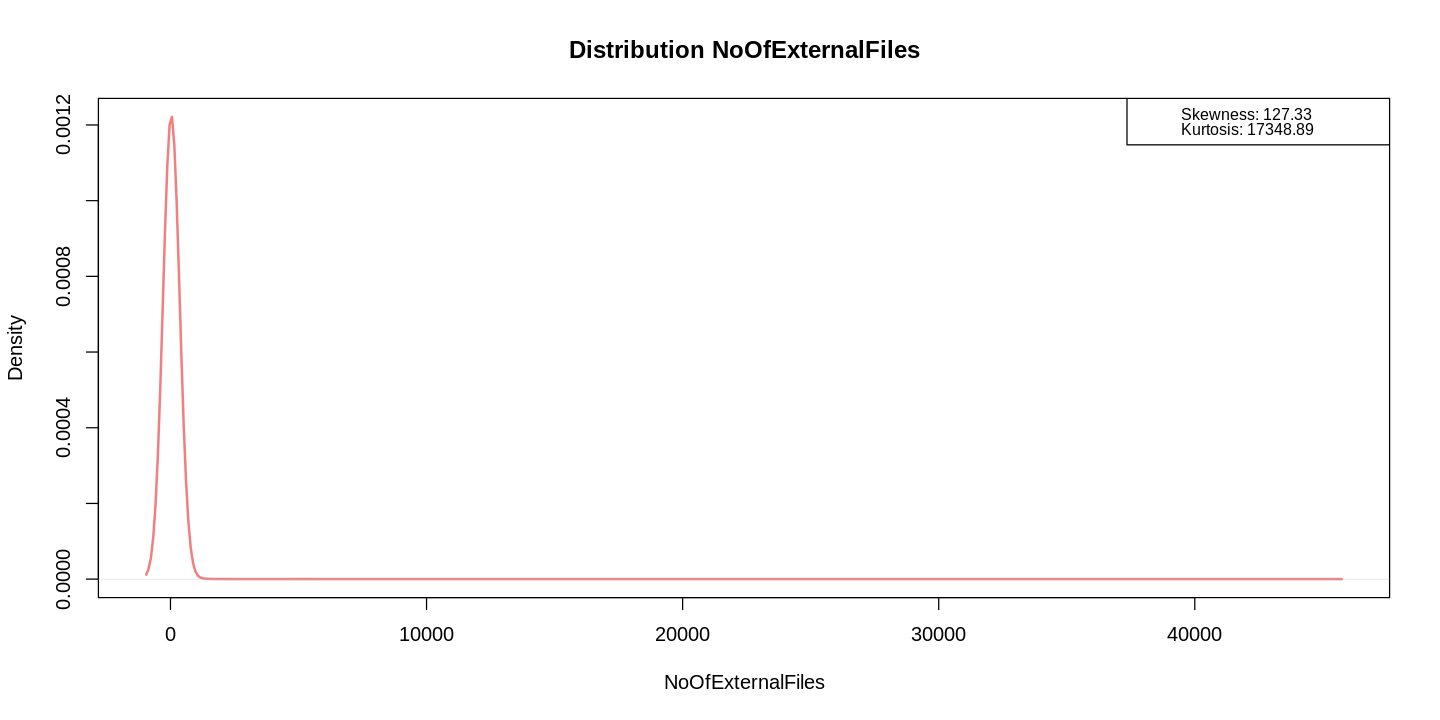

In [ ]:
skw_value <- skewness(df$NoOfExternalFiles)
kurtosis_value <- kurtosis(df$NoOfExternalFiles)

n <- length(df$NoOfExternalFiles)
h_sturges <- (max(df$NoOfExternalFiles) - min(df$NoOfExternalFiles)) / sqrt(n)
density <- density(df$NoOfExternalFiles, bw = h_sturges)

plot(density, main = "Distribution NoOfExternalFiles",
     col = "lightcoral", lwd = 2, xlab = 'NoOfExternalFiles')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

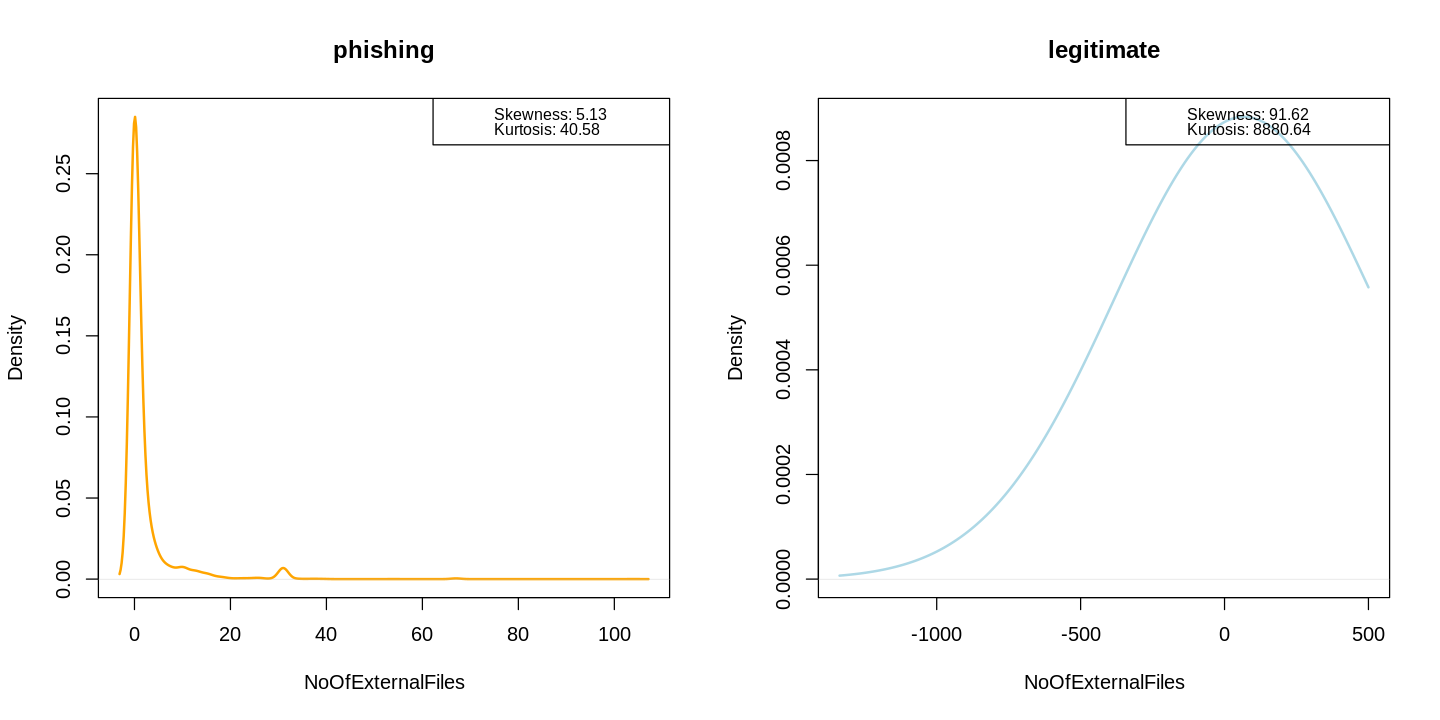

In [ ]:
skw_value_0 <- skewness(df_0$NoOfExternalFiles)
kurtosis_value_0 <- kurtosis(df_0$NoOfExternalFiles)

skw_value_1 <- skewness(df_1$NoOfExternalFiles)
kurtosis_value_1 <- kurtosis(df_1$NoOfExternalFiles)

n <- length(df_0$NoOfExternalFiles)
h_sturges <- (max(df_0$NoOfExternalFiles) - min(df_0$NoOfExternalFiles)) / sqrt(n)
density_0 <- density(df_0$NoOfExternalFiles, bw = h_sturges)

n <- length(df_1$NoOfExternalFiles)
h_sturges <- (max(df_1$NoOfExternalFiles) - min(df_1$NoOfExternalFiles)) / sqrt(n)
density_1 <- density(df_1$NoOfExternalFiles, bw = h_sturges, to = 500)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "NoOfExternalFiles", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "NoOfExternalFiles", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfExternalFiles, df$label)
spearman <- cor(df$NoOfExternalFiles, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1144722
Spearman: 	 0.8669355

### 54. Feature **NoOfSelfRef**


#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfSelfRef)

cat('\nvar: ', var(df$NoOfSelfRef), '\n')
cat('std: ', sd(df$NoOfSelfRef))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     2.00    56.62    74.00 19046.00 


var:  33520.76 
std:  183.0867

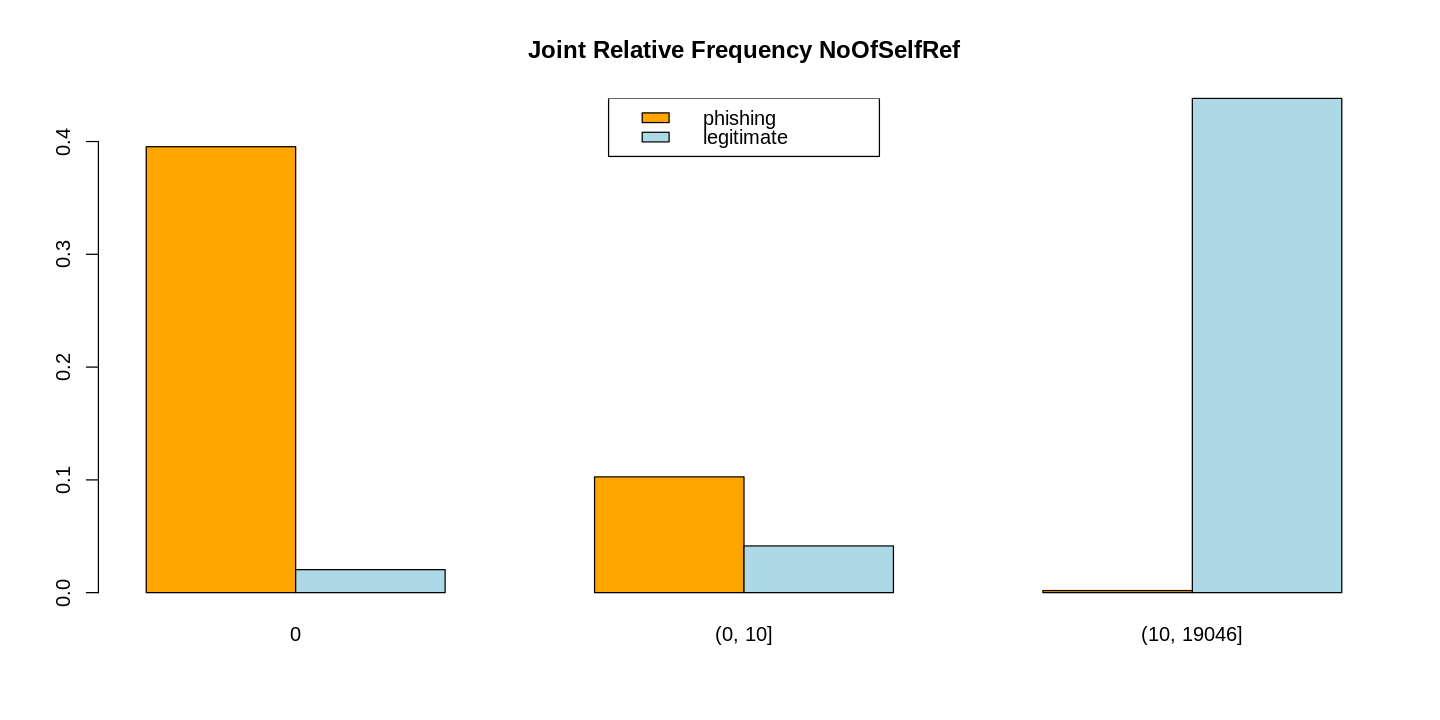

In [ ]:
breaks = c(-Inf, 0, 10, 19046)

labels = c("0", "(0, 10]", "(10, 19046]")

j_freq <- table(df$label, cut(df$NoOfSelfRef, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfSelfRef", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfSelfRef)
summary(df_1$NoOfSelfRef)

outliers <- count_outliers(df, "NoOfSelfRef")
outliers_0 <- count_outliers(df_0, "NoOfSelfRef")
outliers_1 <- count_outliers(df_1, "NoOfSelfRef")

cat('\nn. outliers NoOfSelfRef: \t', outliers)
cat('\nn. outliers NoOfSelfRef (0): \t', outliers_0)
cat('\nn. outliers NoOfSelfRef (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4536  0.0000 67.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    34.0    74.0   112.8   139.0 19046.0 


n. outliers NoOfSelfRef: 	 1554
n. outliers NoOfSelfRef (0): 	 2106
n. outliers NoOfSelfRef (1): 	 598

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfSelfRef, df$label)
spearman <- cor(df$NoOfSelfRef, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.3067298
Spearman: 	 0.8473392

### 55. Feature **NoOfEmptyRef**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfEmptyRef)

cat('\nvar: ', var(df$NoOfEmptyRef), '\n')
cat('std: ', sd(df$NoOfEmptyRef))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    0.000    1.975    1.000 1336.000 


var:  221.6065 
std:  14.88645

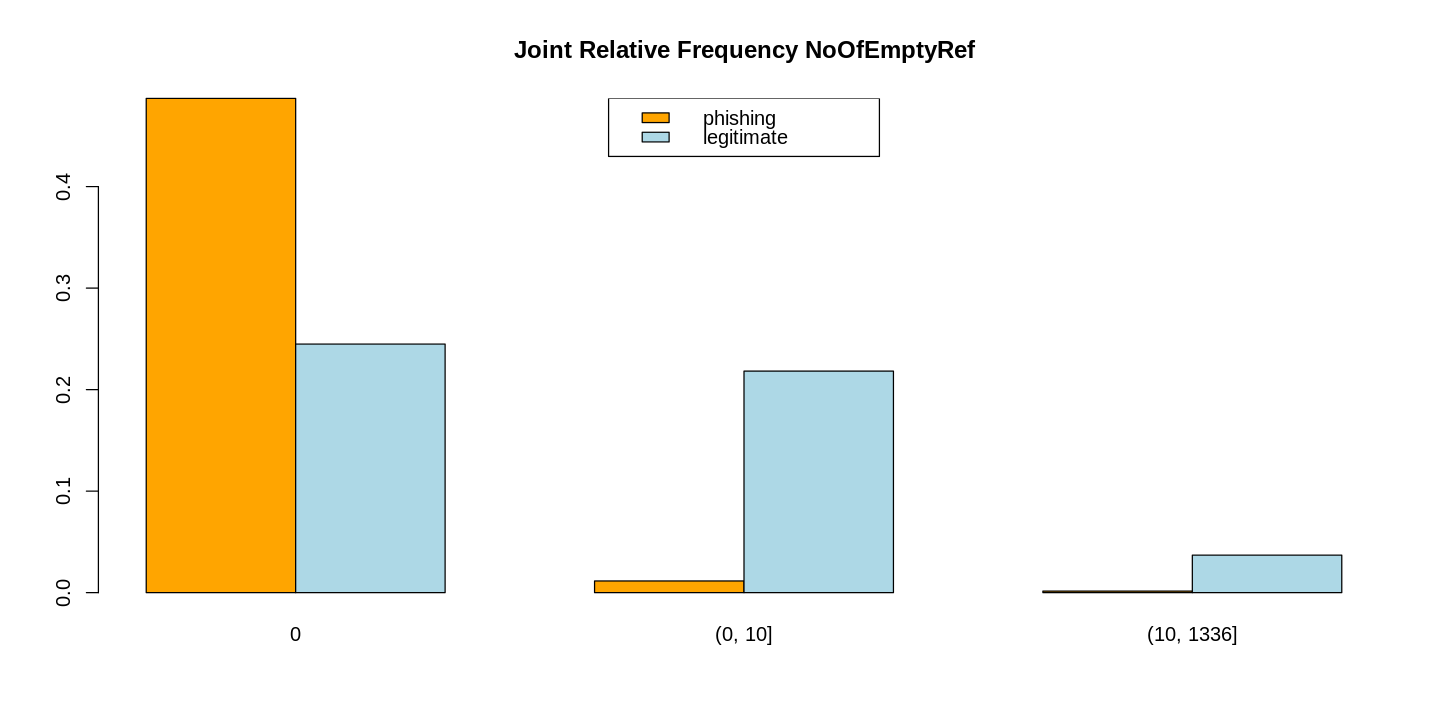

In [ ]:
breaks = c(-Inf, 0, 10, 1336)

labels = c("0", "(0, 10]", "(10, 1336]")

j_freq <- table(df$label, cut(df$NoOfEmptyRef, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfEmptyRef", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfEmptyRef)
summary(df_1$NoOfEmptyRef)

outliers <- count_outliers(df, "NoOfEmptyRef")
outliers_0 <- count_outliers(df_0, "NoOfEmptyRef")
outliers_1 <- count_outliers(df_1, "NoOfEmptyRef")

cat('\nn. outliers NoOfEmptyRef: \t', outliers)
cat('\nn. outliers NoOfEmptyRef (0): \t', outliers_0)
cat('\nn. outliers NoOfEmptyRef (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1394  0.0000 78.0000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    1.000    3.809    3.000 1336.000 


n. outliers NoOfEmptyRef: 	 2875
n. outliers NoOfEmptyRef (0): 	 263
n. outliers NoOfEmptyRef (1): 	 1143

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfEmptyRef, df$label)
spearman <- cor(df$NoOfEmptyRef, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1232639
Spearman: 	 0.5393087

### 56. Feature **NoOfExternalRef**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfExternalRef)

cat('\nvar: ', var(df$NoOfExternalRef), '\n')
cat('std: ', sd(df$NoOfExternalRef))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     4.00    43.38    45.00 19147.00 


var:  28733.19 
std:  169.5087

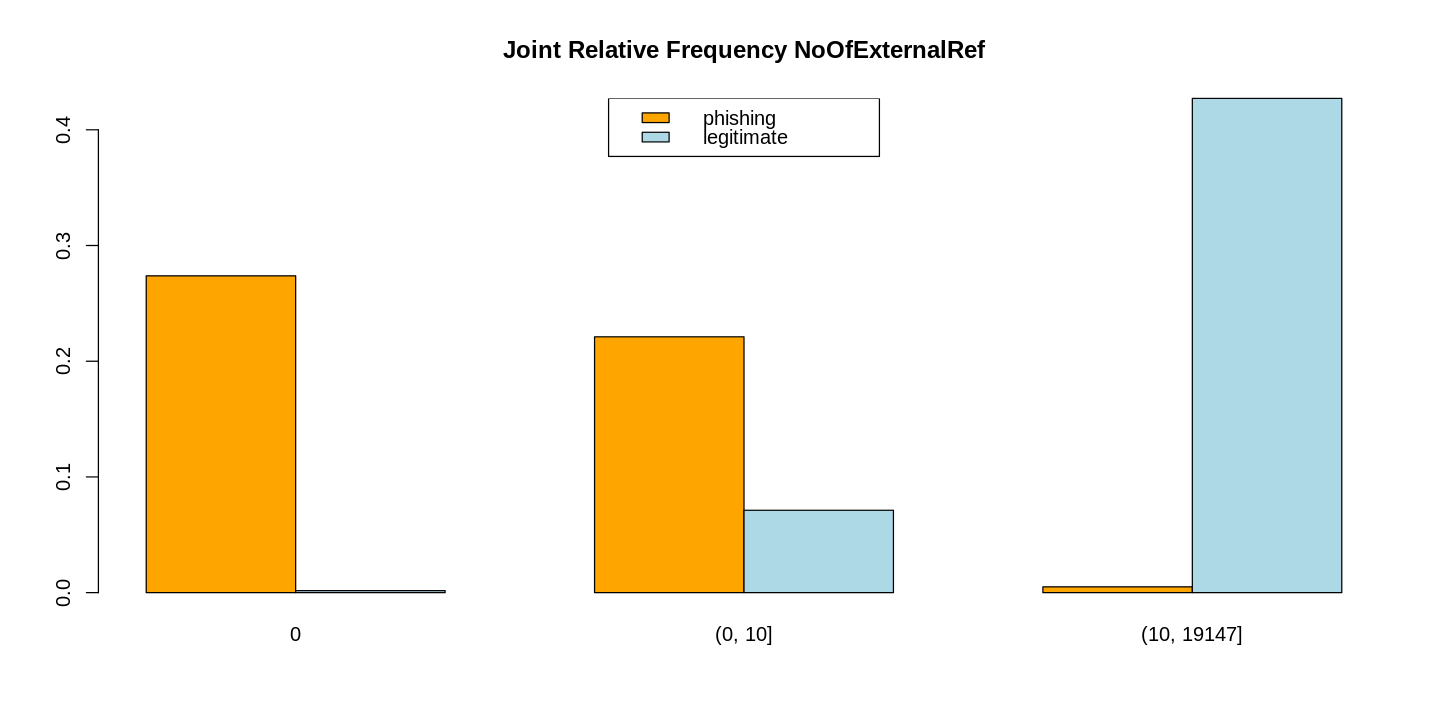

In [ ]:
breaks = c(-Inf, 0, 10, 19147)

labels = c("0", "(0, 10]", "(10, 19147]")

j_freq <- table(df$label, cut(df$NoOfExternalRef, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfExternalRef", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfExternalRef)
summary(df_1$NoOfExternalRef)

outliers <- count_outliers(df, "NoOfExternalRef")
outliers_0 <- count_outliers(df_0, "NoOfExternalRef")
outliers_1 <- count_outliers(df_1, "NoOfExternalRef")

cat('\nn. outliers NoOfExternalRef: \t\t', outliers)
cat('\nn. outliers NoOfExternalRef (0): \t', outliers_0)
cat('\nn. outliers NoOfExternalRef (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.082   1.000  93.000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00    17.00    45.00    85.66   106.00 19147.00 


n. outliers NoOfExternalRef: 		 2341
n. outliers NoOfExternalRef (0): 	 1447
n. outliers NoOfExternalRef (1): 	 648

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfExternalRef, df$label)
spearman <- cor(df$NoOfExternalRef, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.249483
Spearman: 	 0.8555959

### 57. Feature **NoOfReference**

Phishing websites may use hyperlinks
that appear to direct to a legitimate webpage, but instead, they redirect
the user to a phishing page.  
**A large number of hyperlinks navigating to
itself, navigating to empty links, or navigating to external links can be
suspicious**.

Create a new feature that aggregate the values of:
- NoOfSelfRef
- NoOfEmptyRef
- NoOfExternalRef

In [ ]:
df['NoOfReference'] <- df['NoOfSelfRef'] +
                       df['NoOfEmptyRef'] +
                       df['NoOfExternalRef']

df <- subset(df, select = -NoOfSelfRef)
df <- subset(df, select = -NoOfEmptyRef)
df <- subset(df, select = -NoOfExternalRef)

# reorder column
cols_order <- append(names(df), 'NoOfReference', after = 10)
df <- df[, cols_order]

df <- subset(df, select = -NoOfReference.1)

# update df_0 and df_1
df_0 <- df[df$label == 0, ]
df_1 <- df[df$label == 1, ]

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$NoOfReference)

cat('\nvar: ', var(df$NoOfReference), '\n')
cat('std: ', sd(df$NoOfReference))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       9     102     133   38193 


var:  118661.1 
std:  344.4722

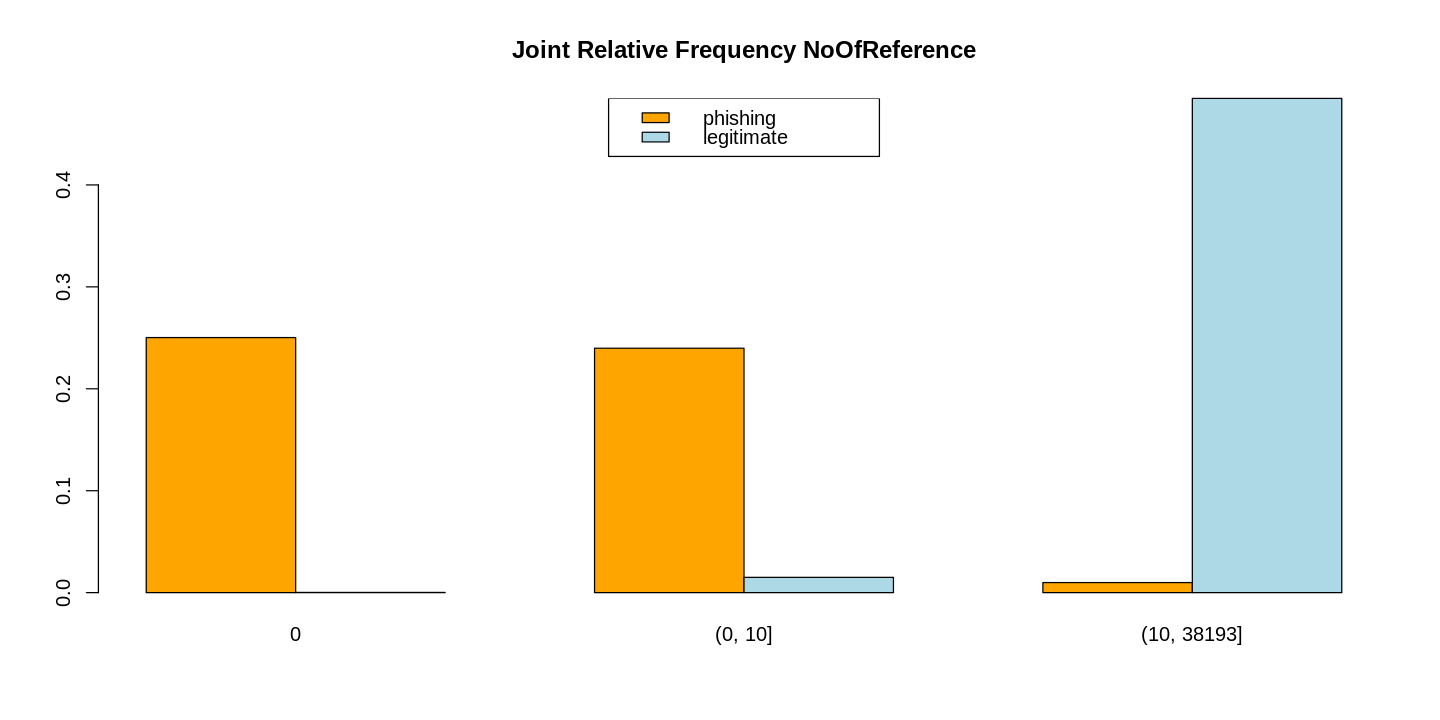

In [ ]:
breaks = c(-Inf, 0, 10, 38193)

labels = c("0", "(0, 10]", "(10, 38193]")

j_freq <- table(df$label, cut(df$NoOfReference, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfReference", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfReference)
summary(df_1$NoOfReference)

outliers <- count_outliers(df, "NoOfReference")
outliers_0 <- count_outliers(df_0, "NoOfReference")
outliers_1 <- count_outliers(df_1, "NoOfReference")

cat('\nn. outliers NoOfReference: \t', outliers)
cat('\nn. outliers NoOfReference (0): \t', outliers_0)
cat('\nn. outliers NoOfReference (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.675   2.000 155.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    64.0   133.0   202.2   247.0 38193.0 


n. outliers NoOfReference: 	 1572
n. outliers NoOfReference (0): 	 401
n. outliers NoOfReference (1): 	 602

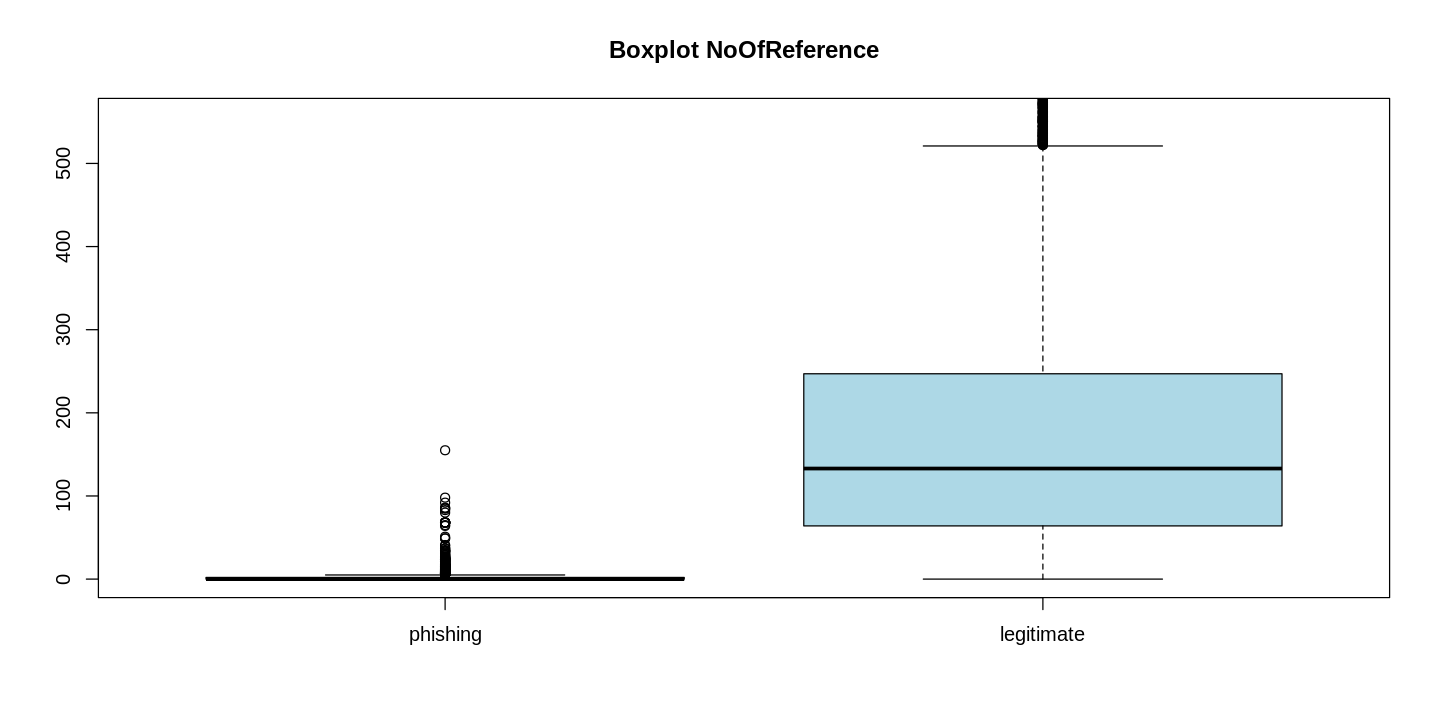

In [ ]:
boxplot(df_0$NoOfReference, df_1$NoOfReference,
        main = 'Boxplot NoOfReference', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfReference), quantile(df_1$NoOfReference, 0.95)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfReference")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = -0.03128291 M2 = 0.03128291 
Overlap df_1: M1 = 130.138 M2 = 135.862 


#### Distribution form

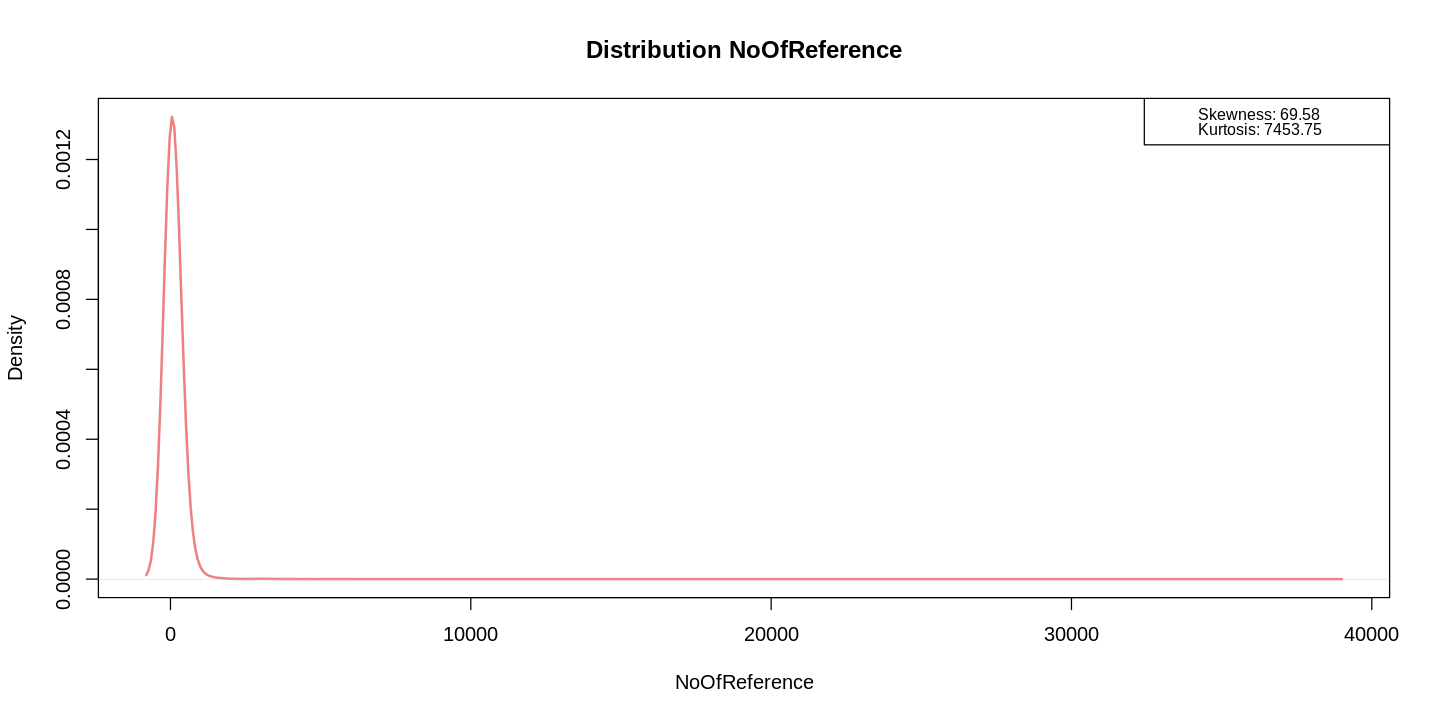

In [ ]:
skw_value <- skewness(df$NoOfReference)
kurtosis_value <- kurtosis(df$NoOfReference)

n <- length(df$NoOfReference)
h_sturges <- (max(df$NoOfReference) - min(df$NoOfReference)) / sqrt(n)
density <- density(df$NoOfReference, bw = h_sturges)

plot(density, main = "Distribution NoOfReference",
     col = "lightcoral", lwd = 2, xlab = 'NoOfReference')
legend("topright", legend = c(paste("Skewness:", round(skw_value, 2)),
                              paste("Kurtosis:", round(kurtosis_value, 2))),
                              bty = "o", col = "black", cex = 0.8, inset = c(-0.05, 0))

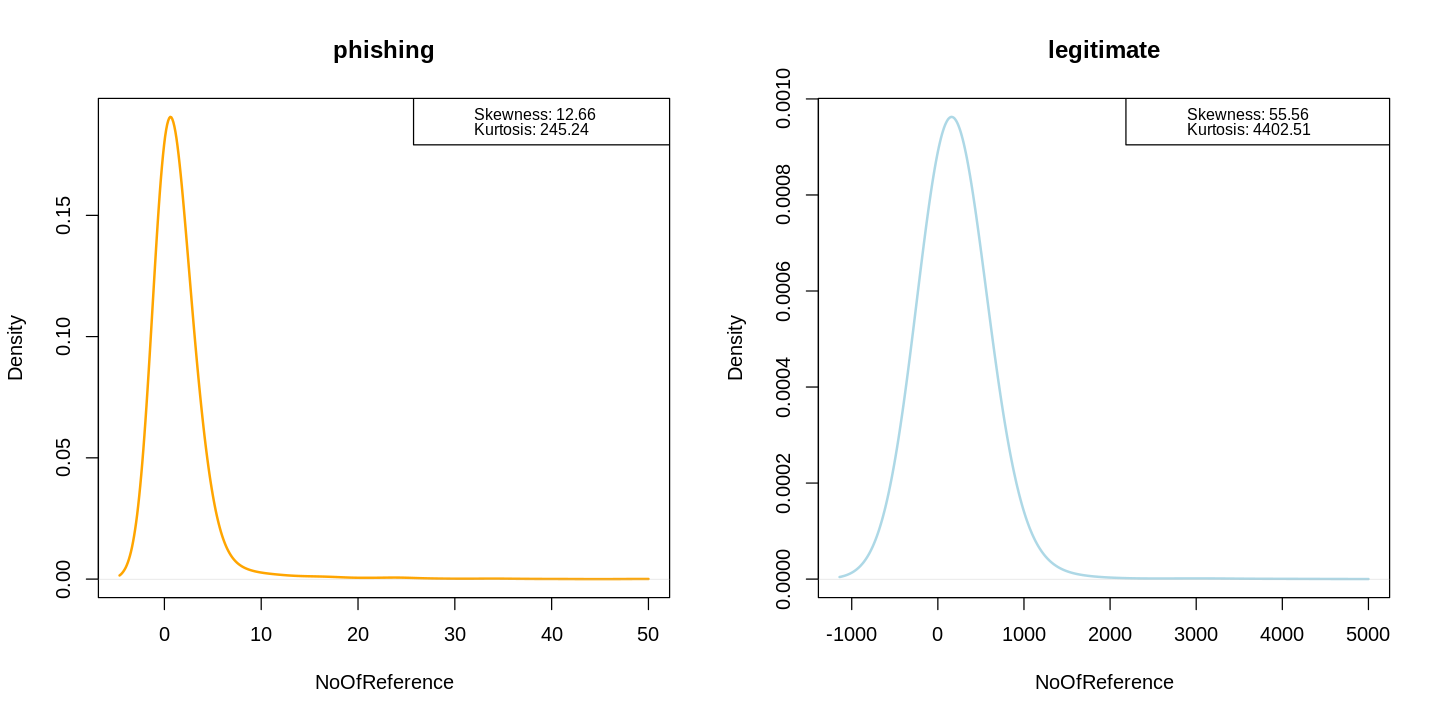

In [ ]:
skw_value_0 <- skewness(df_0$NoOfReference)
kurtosis_value_0 <- kurtosis(df_0$NoOfReference)

skw_value_1 <- skewness(df_1$NoOfReference)
kurtosis_value_1 <- kurtosis(df_1$NoOfReference)

n <- length(df_0$NoOfReference)
h_sturges <- (max(df_0$NoOfReference) - min(df_0$NoOfReference)) / sqrt(n)
density_0 <- density(df_0$NoOfReference, bw = h_sturges, to = 50)

n <- length(df_1$NoOfReference)
h_sturges <- (max(df_1$NoOfReference) - min(df_1$NoOfReference)) / sqrt(n)
density_1 <- density(df_1$NoOfReference, bw = h_sturges, to = 5000)

# 1 row, 2 columns
par(mfrow = c(1, 2))

# phishing
plot(density_0, main = "phishing",
     col = "orange", lwd = 2, xlab = "NoOfReference", ylab = "Density",
     ylim = c(0, max(density_0$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = "orange", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# legitimate
plot(density_1, main = "legitimate",
     col = "lightblue", lwd = 2, xlab = "NoOfReference", ylab = "Density",
     ylim = c(0, max(density_1$y)))
legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = "lightblue", bty = "o", cex = 0.8, inset = c(-0.15, 0))

# reset plot layout
par(mfrow = c(1, 1))

#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfReference, df$label)
spearman <- cor(df$NoOfReference, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.2911197
Spearman: 	 0.8666207

## **Saving filtered real dataset**

In [ ]:
write.csv(df, "Phishing_URL_Dataset_3_Filtered.csv", row.names = FALSE)